# DATA CHALLENGE / December 2018
## TANG David / david.tang@telecom-paristech.fr

### Fusion of algorithms for face recognition

The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.  
In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.  
Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.  
You are provided a label set of training data and a test set without labels. You should submit a .csv file with labels for each entry of this test set.

### The properties of the dataset

#### Training data:
The training set consist of two files, xtrain_challenge.csv and xtest_challenge.csv.  
File xtrain_challenge.csv contains one observation per row which contains following entries based on a pair of images, A and B say:  
- columns 1-14 - 14 qualities on image A;
- columns 15-28 - 14 qualities on image B;
- columns 29-36 - 8 matching scores between A and B.  

File ytrain_challenge.csv contains one line with each entry corresponding to one observation in xtrain_challenge.csv, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.  
There are in total 3.196.465 training observations.

#### Test data:
File xtest_challenge.csv has the same structure as file xtrain_challenge.csv.

There are in total 1.598.219 test observations.

-------------------------------------------------
# 1. PRELIMINARY WORK

### Importing the libraries

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

### Loading Training and Test Set

In [2]:
# Load training data
xtrain = pd.read_csv('xtrain_challenge.csv')
ytrain = pd.read_csv('ytrain_challenge.csv')
# Load test data
xtest = pd.read_csv('xtest_challenge.csv')

__________________________________________________

# 2. Data Investigation

### Check the number of observations and properties

In [3]:
print(xtrain.head())

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10   ...    fB13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00   ...    0.04   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01   ...    0.01   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00   ...    0.07   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01   ...    0.10   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01   ...    0.01   

     fB14      s1      s2      s3      s4      s5      s6      s7      s8  
0  271.80  2464.1  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9  1949.8  
1  157.15  3975.9  2640.9  2672.6  4233.8  3357.9  2224.0  3341.1  3611.5  
2  283.33  3401.1  2644.3  2514.2  3551.3  3019.7  3414.7  2763.6  3252.2  
3  298.40  2418.6  2659.6  2742.1  3422.4  2602.6  2784.0  2697.4  2505.1  
4  248.69  2309.1  2164.0  1755.6  2377.4  1994.6  2147.6  1902.9  2599.5  

[5 rows x 36 columns]


In [4]:
print('\nxtrain shape:', xtrain.shape)
print('ytrain shape:', ytrain.shape)
print('xtest shape:', xtest.shape)


xtrain shape: (3196465, 36)
ytrain shape: (3196465, 1)
xtest shape: (1598219, 36)


### Basic statistics of each features

In [5]:
xtrain.describe()

fA1           fA2           fA3           fA4           fA5  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   3.123656e+00  7.200140e-01  8.895844e-02  2.938227e+01  9.112188e-01   
std    1.618458e+00  4.224322e-01  2.824698e-01  9.793075e+00  2.757797e-01   
min   -4.500000e-01  0.000000e+00  0.000000e+00  1.800000e+01  0.000000e+00   
25%    1.950000e+00  2.500000e-01  0.000000e+00  2.200000e+01  1.000000e+00   
50%    3.390000e+00  1.000000e+00  0.000000e+00  2.600000e+01  1.000000e+00   
75%    4.380000e+00  1.000000e+00  0.000000e+00  3.400000e+01  1.000000e+00   
max    7.940000e+00  1.000000e+00  1.000000e+00  7.400000e+01  1.000000e+00   

                fA6           fA7           fA8           fA9          fA10  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   4.165448e-03  8.456615e-02  1.323673e-01  2.970159e-02 -2.833317e-04   
std    4.433567e-02  2.729676e-01  4.159110e-01  1.279389e-01  2.096133e-02   
min    0.000000e+00  0.000000e+00 -2.550000e+00 -3.030000e+00 -3.000000e-01   
25%    0.000000e+00  0.000000e+00 -2.000000e-02 -2.000000e-02  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  2.000000e-02  0.000000e+00   
75%    0.000000e+00  0.000000e+00  1.000000e-01  8.000000e-02  1.000000e-02   
max    1.000000e+00  1.000000e+00  2.500000e+00  7.600000e-01  2.600000e-01   

           ...               fB13          fB14            s1            s2  \
count      ...       3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean       ...      -4.888641e-03  2.477718e+02  3.874350e+03  2.434998e+03   
std        ...       5.770911e-02  1.221232e+02  2.063822e+03  2.272729e+02   
min        ...      -4.200000e-01 -3.087900e+02  1.212700e+03  1.511400e+03   
25%        ...      -3.000000e-02  2.214200e+02  2.420300e+03  2.296300e+03   
50%        ...       0.000000e+00  2.766400e+02  3.062600e+03  2.439800e+03   
75%        ...       2.000000e-02  3.216600e+02  4.442500e+03  2.589300e+03   
max        ...       4.400000e-01  4.814200e+02  1.204420e+04  3.035900e+03   

                 s3            s4            s5            s6            s7  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   4.200151e+03  4.242067e+03  3.488791e+03  3.399066e+03  3.509614e+03   
std    2.954367e+03  2.127659e+03  1.360081e+03  1.363354e+03  1.066627e+03   
min    7.218000e+02  1.133800e+03  6.682000e+02  7.200000e+02  1.358000e+03   
25%    2.086200e+03  2.735400e+03  2.457200e+03  2.335000e+03  2.742600e+03   
50%    3.073300e+03  3.402000e+03  3.063300e+03  2.999800e+03  3.151800e+03   
75%    5.143800e+03  4.898800e+03  4.406800e+03  4.375500e+03  3.926300e+03   
max    1.666650e+04  1.181290e+04  7.731000e+03  7.580100e+03  6.949500e+03   

                 s8  
count  3.196465e+06  
mean   3.745971e+03  
std    1.548290e+03  
min    7.107000e+02  
25%    2.620100e+03  
50%    3.218800e+03  
75%    4.396900e+03  
max    8.524900e+03  

[8 rows x 36 columns]

In [6]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196465 entries, 0 to 3196464
Data columns (total 36 columns):
fA1     float64
fA2     float64
fA3     float64
fA4     int64
fA5     float64
fA6     float64
fA7     float64
fA8     float64
fA9     float64
fA10    float64
fA11    float64
fA12    float64
fA13    float64
fA14    float64
fB1     float64
fB2     float64
fB3     float64
fB4     int64
fB5     float64
fB6     float64
fB7     float64
fB8     float64
fB9     float64
fB10    float64
fB11    float64
fB12    float64
fB13    float64
fB14    float64
s1      float64
s2      float64
s3      float64
s4      float64
s5      float64
s6      float64
s7      float64
s8      float64
dtypes: float64(34), int64(2)
memory usage: 877.9 MB


**fA4 and fB4 are integers**

### Categorical variables in our dataset :  
**The third, fourth, fifth, sixth and seventh features of an Image A and B look like categorical**

In [7]:
# Check the number of distinct values (modalities) of features that look like categorical variables
print('modalities for A3: ', xtrain.fA3.nunique(),
      '\nmodalities for A4: ',xtrain.fA4.nunique(),
      '\nmodalities for A5: ',xtrain.fA5.nunique(),
      '\nmodalities for A6: ',xtrain.fA6.nunique(),
      '\nmodalities for A7: ',xtrain.fA7.nunique())

print('modalities for B3: ',xtrain.fB3.nunique())
print('modalities for B4: ',xtrain.fB4.nunique())
print('modalities for B5: ',xtrain.fB5.nunique())
print('modalities for B6: ',xtrain.fB6.nunique())
print('modalities for B7: ',xtrain.fB7.nunique())

modalities for A3:  101 
modalities for A4:  57 
modalities for A5:  101 
modalities for A6:  101 
modalities for A7:  101
modalities for B3:  101
modalities for B4:  56
modalities for B5:  101
modalities for B6:  100
modalities for B7:  96


**For now, I won't try to encoding the independent variable that might be categorical due to the large dataset.  
But so far, fA4 and fB4 might be the ones to be categorical.**

**With that many observations and features, I decide to check for missing data and outliers, and potentially remove them.  
We will first use the interquartile range (IQR) score: Box plots use the IQR method to display data and outliers.**

In [8]:
# Check for missing data
xtrain.isnull().sum()

fA1     0
fA2     0
fA3     0
fA4     0
fA5     0
fA6     0
fA7     0
fA8     0
fA9     0
fA10    0
fA11    0
fA12    0
fA13    0
fA14    0
fB1     0
fB2     0
fB3     0
fB4     0
fB5     0
fB6     0
fB7     0
fB8     0
fB9     0
fB10    0
fB11    0
fB12    0
fB13    0
fB14    0
s1      0
s2      0
s3      0
s4      0
s5      0
s6      0
s7      0
s8      0
dtype: int64

### Let's check outliers with interquartile range

In [12]:
Q1 = xtrain.quantile(0.25)
Q3 = xtrain.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

fA1        2.43
fA2        0.75
fA3        0.00
fA4       12.00
fA5        0.00
fA6        0.00
fA7        0.00
fA8        0.12
fA9        0.10
fA10       0.01
fA11       0.09
fA12       0.11
fA13       0.05
fA14     106.05
fB1        2.35
fB2        0.73
fB3        0.00
fB4       11.00
fB5        0.00
fB6        0.00
fB7        0.00
fB8        0.08
fB9        0.09
fB10       0.01
fB11       0.09
fB12       0.11
fB13       0.05
fB14     100.24
s1      2022.20
s2       293.00
s3      3057.60
s4      2163.40
s5      1949.60
s6      2040.50
s7      1183.70
s8      1776.80
dtype: float64


**I am now checking, whether the matching score features s1 to s8, have outliers in their datasets.**

In [19]:
def outliers(train,n,cols):
    outlier_index = []
    
    for col in cols:
        Q1 = np.percentile(train[col], 1)
        Q99 = np.percentile(train[col],99)
        outlier_list = train[(train[col] < Q1) | (train[col] > Q99)].index
        outlier_index.extend(outlier_list)
    return outlier_index

# detect outliers from matching scores columns
out = outliers(xtrain,2,["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8"])
print('number of outliers:', len(out),
      '\nnumber of observations:', len(xtrain), 
      '\nratio of outliers:', len(out)/len(xtrain)*100, '%')

number of outliers: 511283 
number of observations: 3196465 
ratio of outliers: 15.995263517667174 %


In [20]:
#Check Outliers
xtrain.loc[out]

fA1   fA2   fA3  fA4   fA5   fA6   fA7   fA8   fA9  fA10   ...    \
25       4.85  1.00  0.00   22  1.00  0.00  0.00  0.33 -0.02 -0.02   ...     
41      -0.16  0.56  1.00   27  0.04  0.00  0.96  1.51  0.01  0.00   ...     
91       0.35  1.00  0.00   21  1.00  0.00  0.00  0.01  0.04  0.01   ...     
102      3.62  1.00  0.00   22  1.00  0.00  0.00  0.06 -0.19  0.01   ...     
190      2.15  0.40  0.76   37  0.16  0.00  0.84  0.42  0.35 -0.03   ...     
195      0.07  0.83  1.00   32  0.03  0.00  0.97  1.56 -0.08 -0.01   ...     
239     -0.17  0.25  0.00   31  0.01  0.00  0.99  1.32  0.04  0.00   ...     
383     -0.16  0.50  1.00   33  0.03  0.00  0.97  1.49  0.10 -0.02   ...     
437      1.85  1.00  0.00   22  1.00  0.00  0.00  0.19 -0.09  0.00   ...     
461      0.45  0.77  1.00   28  0.11  0.00  0.89  1.41 -0.03  0.00   ...     
511      5.11  1.00  0.00   21  1.00  0.00  0.00  0.02 -0.06  0.00   ...     
632      0.51  0.19  0.00   44  0.00  0.00  1.00  1.29  0.13 -0.01   ...     
665      0.43  0.26  1.00   34  0.25  0.00  0.75 -1.62 -2.28  0.02   ...     
682      2.06  1.00  1.00   44  0.99  0.01  0.00  0.04  0.02  0.00   ...     
755      3.96  1.00  0.00   23  1.00  0.00  0.00 -0.07 -0.14 -0.01   ...     
812     -0.07  0.46  1.00   35  0.00  0.00  1.00  1.49  0.01  0.00   ...     
824      5.43  1.00  0.00   27  1.00  0.00  0.00  0.02 -0.14 -0.01   ...     
844      4.59  1.00  0.00   21  1.00  0.00  0.00  0.00  0.20  0.00   ...     
916      5.01  1.00  0.00   20  1.00  0.00  0.00 -0.05 -0.02  0.00   ...     
968      4.17  1.00  0.00   19  1.00  0.00  0.00  0.04 -0.04 -0.01   ...     
1022     0.50  0.17  0.00   40  0.00  0.00  1.00  1.50  0.07  0.00   ...     
1069     3.64  1.00  0.00   47  1.00  0.00  0.00  0.00 -0.01  0.00   ...     
1162     3.97  0.00  0.00   28  1.00  0.00  0.00  0.01  0.05  0.01   ...     
1192     1.12  0.87  1.00   32  0.02  0.00  0.98  1.30  0.02  0.00   ...     
1197     1.02  0.23  0.00   46  0.04  0.00  0.96  1.37  0.08  0.00   ...     
1203    -0.22  0.35  0.00   32  0.05  0.00  0.95  1.26  0.03  0.01   ...     
1277     5.40  1.00  0.00   21  1.00  0.00  0.00 -0.02  0.23 -0.01   ...     
1321    -0.09  0.28  1.00   27  0.01  0.00  0.99  1.23  0.07  0.00   ...     
1343    -0.15  0.31  0.00   39  0.00  0.00  1.00  1.52  0.04  0.00   ...     
1401    -0.27  0.41  0.00   26  0.23  0.00  0.77  1.26 -0.02  0.01   ...     
...       ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...     
3194737  0.81  0.23  0.96   36  0.00  0.00  1.00  1.47 -0.01  0.00   ...     
3194780  4.20  0.00  0.00   25  1.00  0.00  0.00  0.04  0.13  0.00   ...     
3194792  2.86  1.00  0.00   22  1.00  0.00  0.00  0.00 -0.23 -0.01   ...     
3194873  0.01  0.18  0.00   28  0.00  0.00  1.00  1.52  0.09  0.01   ...     
3194889  0.19  0.22  0.00   32  0.00  0.00  1.00  1.53  0.00  0.00   ...     
3194929  4.71  1.00  0.00   25  1.00  0.00  0.00  0.31 -0.07 -0.01   ...     
3195013  3.44  1.00  0.00   21  1.00  0.00  0.00 -0.14  0.03  0.00   ...     
3195016  1.68  1.00  0.00   24  1.00  0.00  0.00 -0.04 -0.10  0.00   ...     
3195155  4.10  1.00  0.00   20  1.00  0.00  0.00 -0.02  0.21  0.00   ...     
3195202  5.16  1.00  0.00   26  1.00  0.00  0.00 -0.18  0.06  0.01   ...     
3195239  0.47  0.12  1.00   30  0.05  0.00  0.95  1.36  0.07 -0.01   ...     
3195299  3.43  0.73  0.00   26  1.00  0.00  0.00  0.03  0.18  0.00   ...     
3195333 -0.04  0.31  0.00   41  0.00  0.00  1.00  1.46  0.10  0.00   ...     
3195339  5.72  1.00  0.00   42  1.00  0.00  0.00  0.01  0.02  0.00   ...     
3195428  5.21  1.00  0.00   20  1.00  0.00  0.00  0.00 -0.03  0.01   ...     
3195496  5.54  1.00  0.00   27  1.00  0.00  0.00  0.02  0.28  0.00   ...     
3195530  5.19  1.00  0.00   22  1.00  0.00  0.00  0.19  0.01 -0.01   ...     
3195744  4.62  1.00  0.00   20  1.00  0.00  0.00  0.34  0.11 -0.01   ...     
3195753  3.45  1.00  0.00   53  1.00  0.00  0.00  0.00  0.02  0.00   ...     
3195760  4.96  1.00  0.00   23  

**Since, I didn't scaled the data, nor did I try to tranform the distribution of the data, I won't delete these observations for now. Besides, my goal is to perform Gradient Boosting Methods.**

**Let's check if at some point in the training dataset, we compare the 2 same images.**

In [3]:
same_images = xtrain.loc[(xtrain.iloc[:,0] == xtrain.iloc[:,14])&
                         (xtrain.iloc[:,1] == xtrain.iloc[:,15])&
                         (xtrain.iloc[:,2] == xtrain.iloc[:,16])&
                         (xtrain.iloc[:,3] == xtrain.iloc[:,17])&
                         (xtrain.iloc[:,4] == xtrain.iloc[:,18])&
                         (xtrain.iloc[:,5] == xtrain.iloc[:,19])&
                         (xtrain.iloc[:,6] == xtrain.iloc[:,20])&
                         (xtrain.iloc[:,7] == xtrain.iloc[:,21])&
                         (xtrain.iloc[:,8] == xtrain.iloc[:,22])&
                         (xtrain.iloc[:,9] == xtrain.iloc[:,23])&
                         (xtrain.iloc[:,10] == xtrain.iloc[:,24])&
                         (xtrain.iloc[:,11] == xtrain.iloc[:,25])&
                         (xtrain.iloc[:,12] == xtrain.iloc[:,26])&
                         (xtrain.iloc[:,13] == xtrain.iloc[:,27])]

In [4]:
print(same_images)

         fA1  fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10   ...    fB13  \
514038  2.69  0.0  0.0   33  1.0  0.0  0.0  0.26  0.02  0.02   ...   -0.05   
755325  4.01  0.0  0.0   27  1.0  0.0  0.0 -0.03 -0.03  0.00   ...    0.02   

          fB14       s1      s2       s3       s4      s5      s6      s7  \
514038  278.39  10448.6  3023.8  13981.4  10588.7  6860.1  7025.5  6941.1   
755325  217.08   9939.2  2991.3  16470.3  11522.6  6545.8  5971.9  5925.5   

            s8  
514038  8002.3  
755325  8524.9  

[2 rows x 36 columns]


**From the above dataframe, we can see that the training set compares 2 identical images.  
For the index 755325 in the training set, we notice that the value for s8 (8524.9) is the feature's maximum.  
Besides, when checking rows with label y = 1, there are high values for the matching scores values.**

### Correlation Matrix  
**I want to take a look at the correlation matrix to get an idea of which columns of the features matrix I can expect to be significant; And as expected the matching score are the most linearly correlated features**

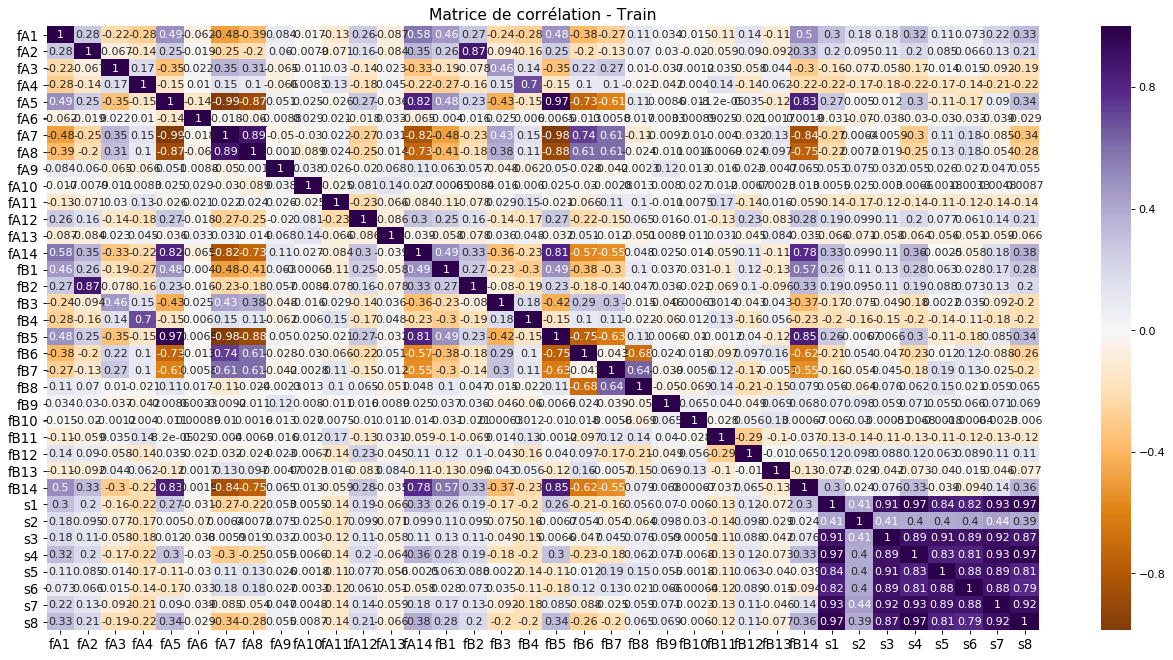

In [21]:
# Correlation Matrix
# Peut-être virer des variables non corrélées avec les autres pour faire un K-Means dessus par exemple
plt.figure(figsize=(20,10), dpi=80)
sns.heatmap(xtrain.corr(), xticklabels=xtrain.corr().columns, yticklabels=xtrain.corr().columns, cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Train', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Let's plot the distribution of each features

In [22]:
xtrain.columns

Index(['fA1', 'fA2', 'fA3', 'fA4', 'fA5', 'fA6', 'fA7', 'fA8', 'fA9', 'fA10',
       'fA11', 'fA12', 'fA13', 'fA14', 'fB1', 'fB2', 'fB3', 'fB4', 'fB5',
       'fB6', 'fB7', 'fB8', 'fB9', 'fB10', 'fB11', 'fB12', 'fB13', 'fB14',
       's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'],
      dtype='object')

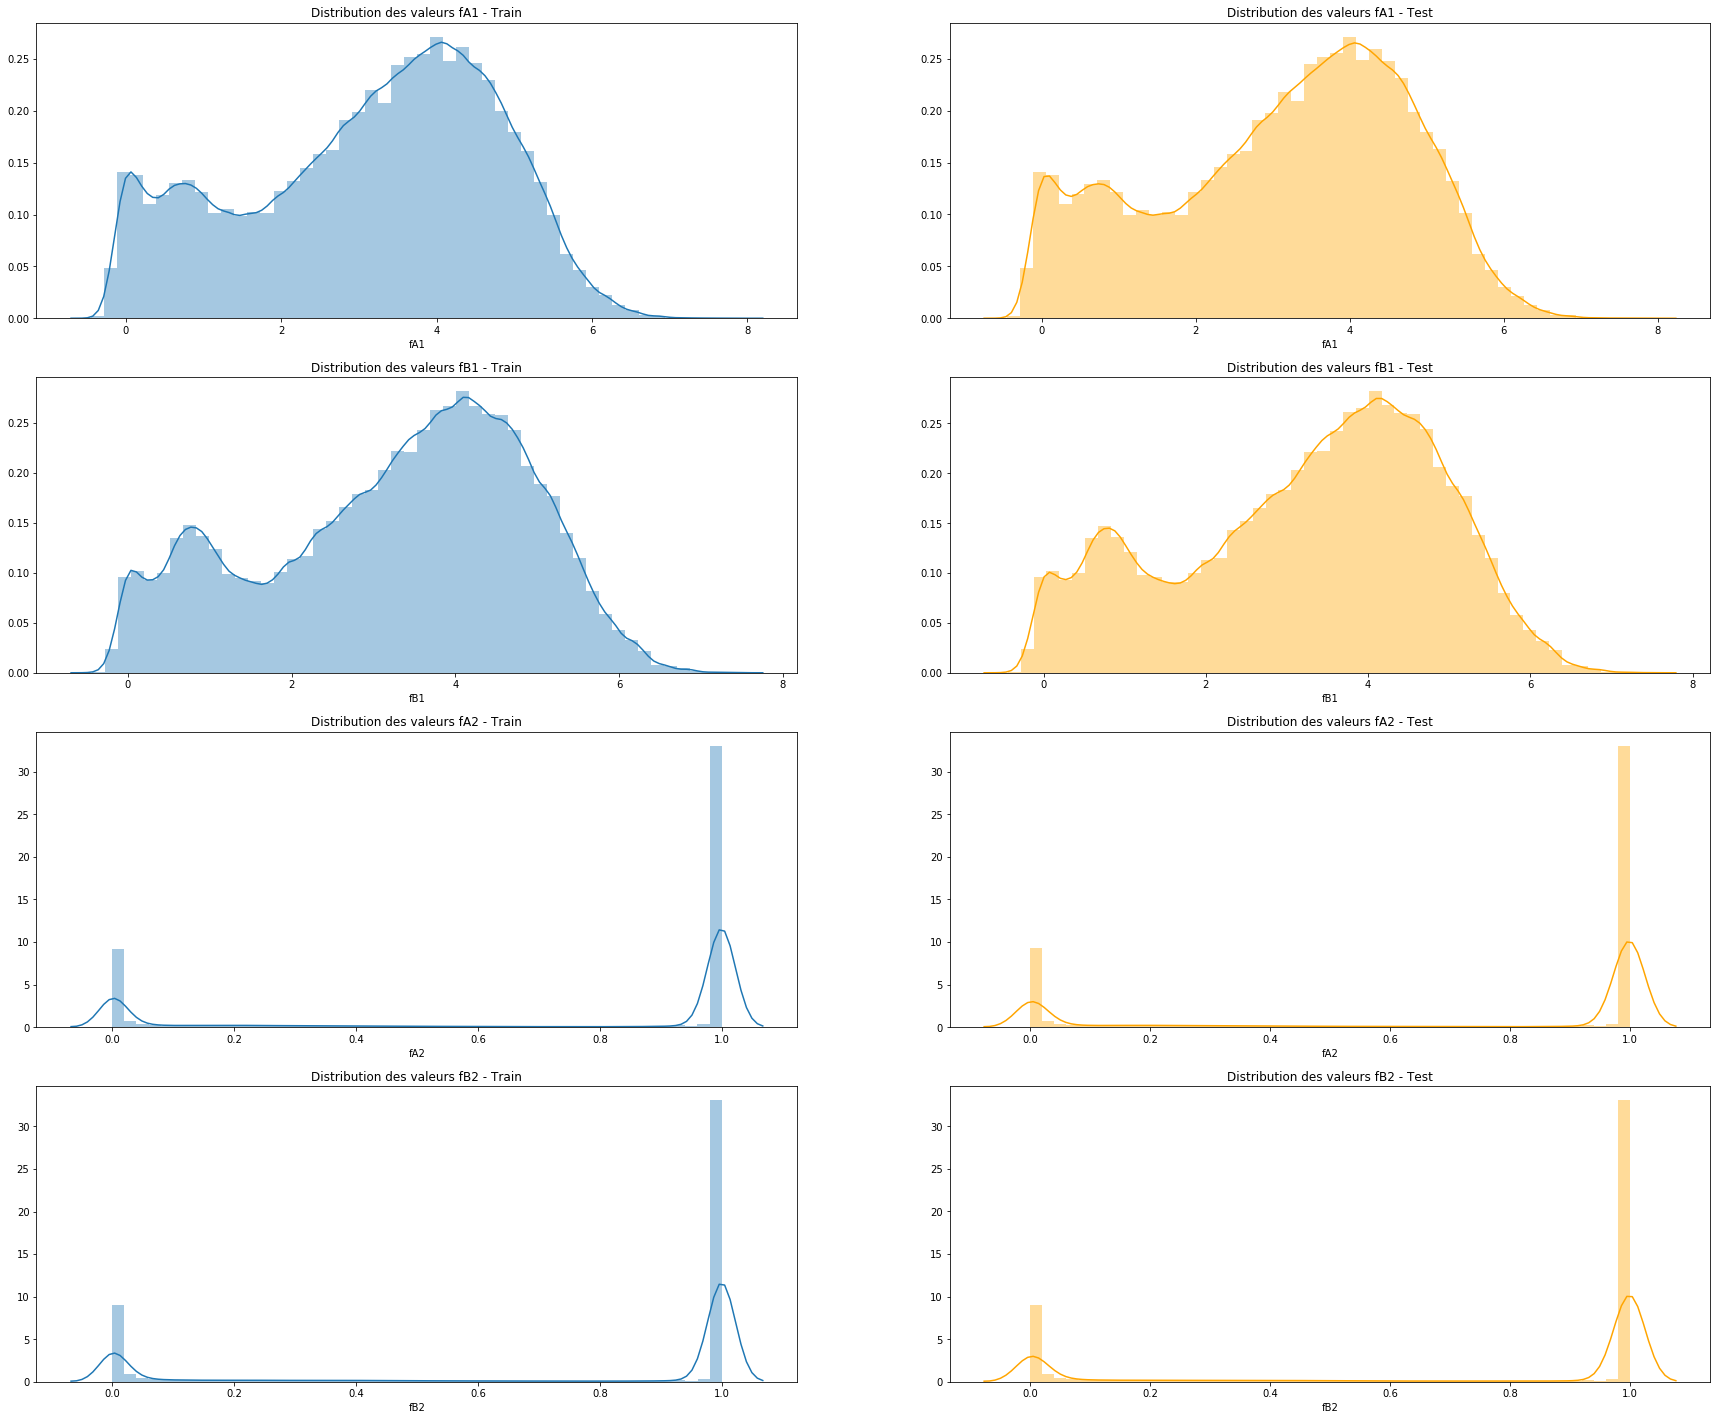

In [23]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA1)
plt.title("Distribution des valeurs fA1 - Train")

plt.subplot(422)
sns.distplot(xtest.fA1, color='orange')
plt.title("Distribution des valeurs fA1 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB1)
plt.title("Distribution des valeurs fB1 - Train")

plt.subplot(424)
sns.distplot(xtest.fB1, color='orange')
plt.title("Distribution des valeurs fB1 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA2)
plt.title("Distribution des valeurs fA2 - Train")

plt.subplot(426)
sns.distplot(xtest.fA2, color='orange')
plt.title("Distribution des valeurs fA2 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB2)
plt.title("Distribution des valeurs fB2 - Train")

plt.subplot(428)
sns.distplot(xtest.fB2, color='orange')
plt.title("Distribution des valeurs fB2 - Test")

plt.show()

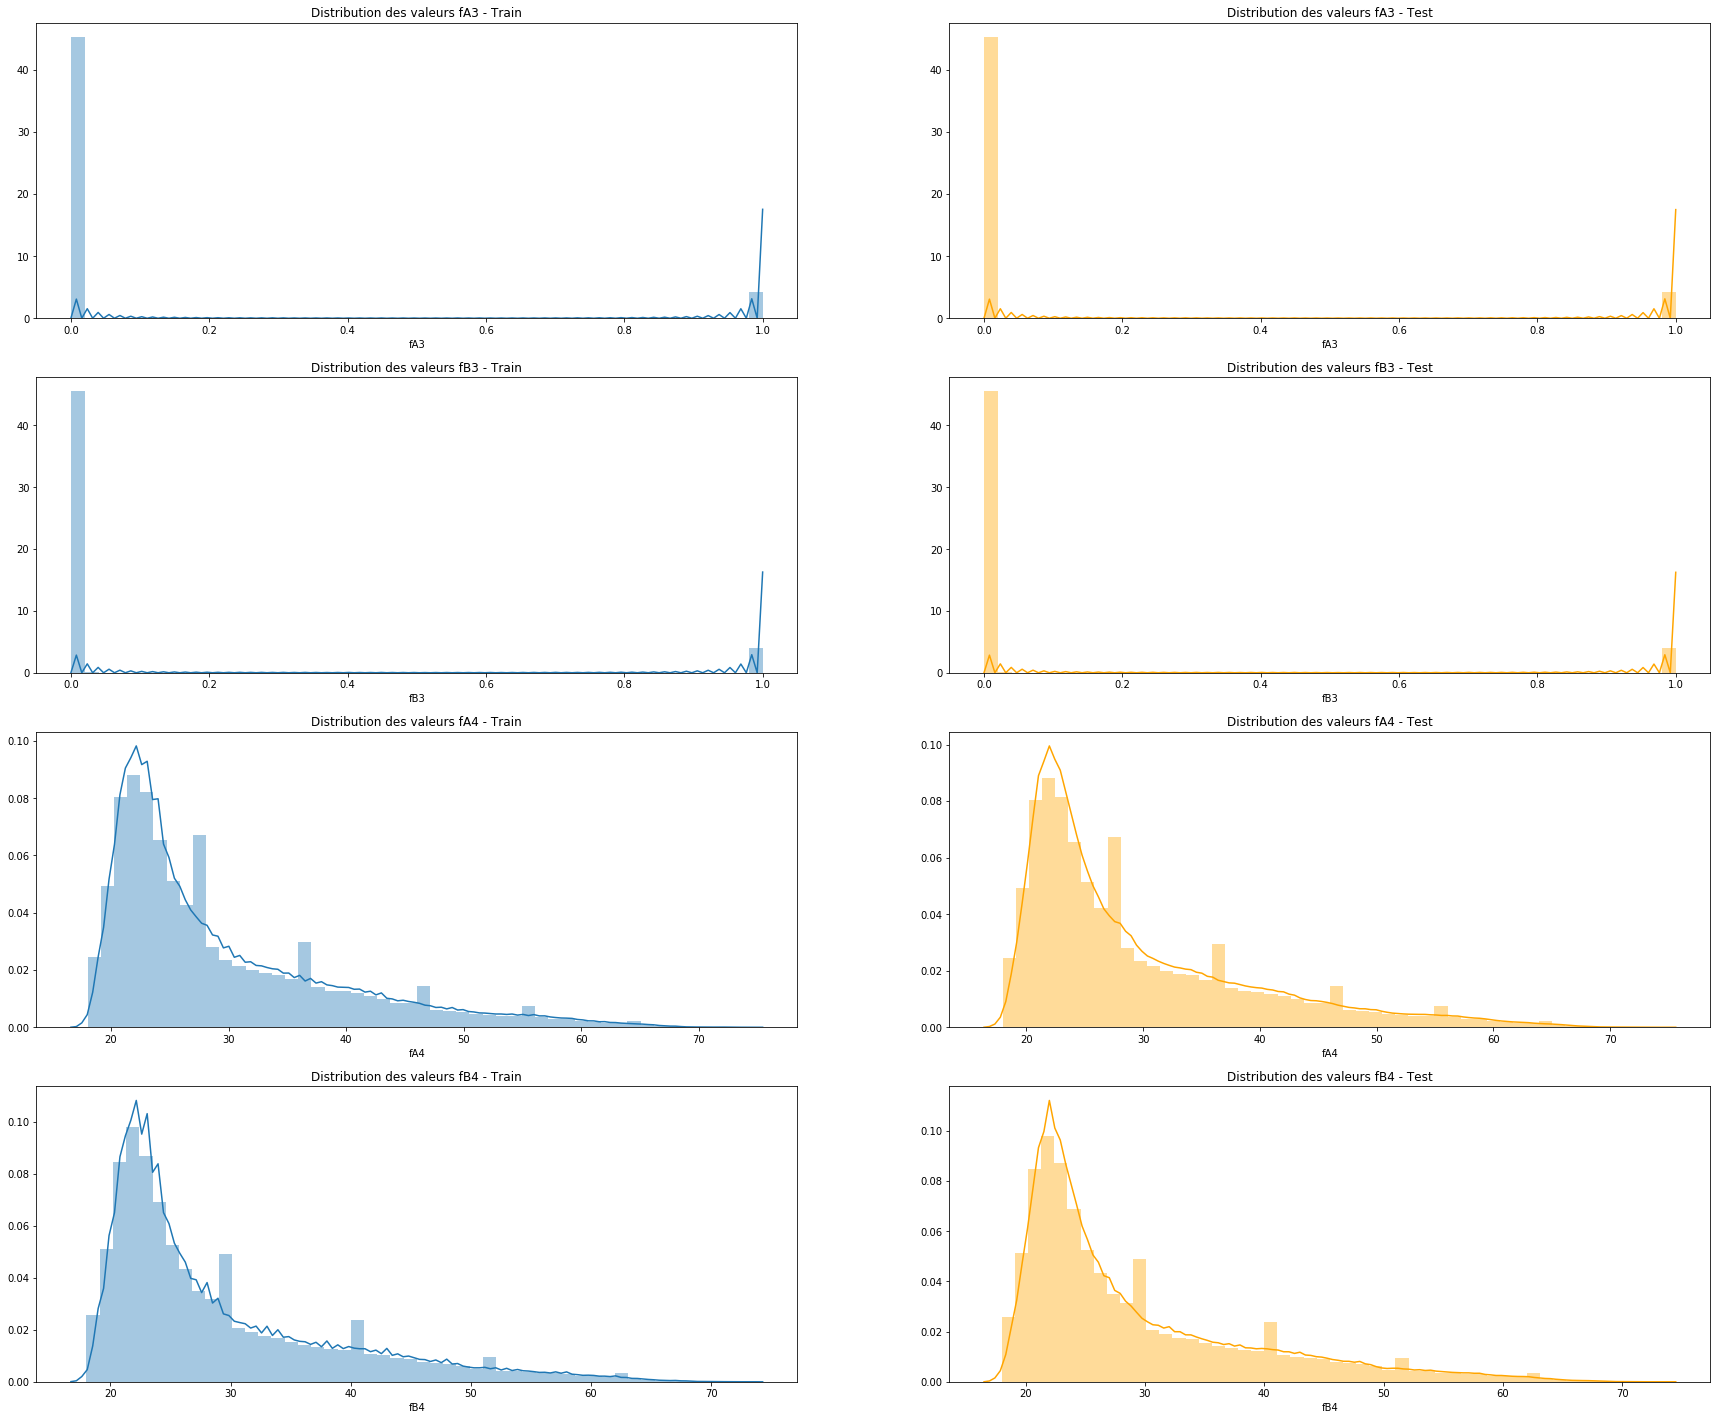

In [24]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA3)
plt.title("Distribution des valeurs fA3 - Train")

plt.subplot(422)
sns.distplot(xtest.fA3, color='orange')
plt.title("Distribution des valeurs fA3 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB3)
plt.title("Distribution des valeurs fB3 - Train")

plt.subplot(424)
sns.distplot(xtest.fB3, color='orange')
plt.title("Distribution des valeurs fB3 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA4)
plt.title("Distribution des valeurs fA4 - Train")

plt.subplot(426)
sns.distplot(xtest.fA4, color='orange')
plt.title("Distribution des valeurs fA4 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB4)
plt.title("Distribution des valeurs fB4 - Train")

plt.subplot(428)
sns.distplot(xtest.fB4, color='orange')
plt.title("Distribution des valeurs fB4 - Test")


plt.show()

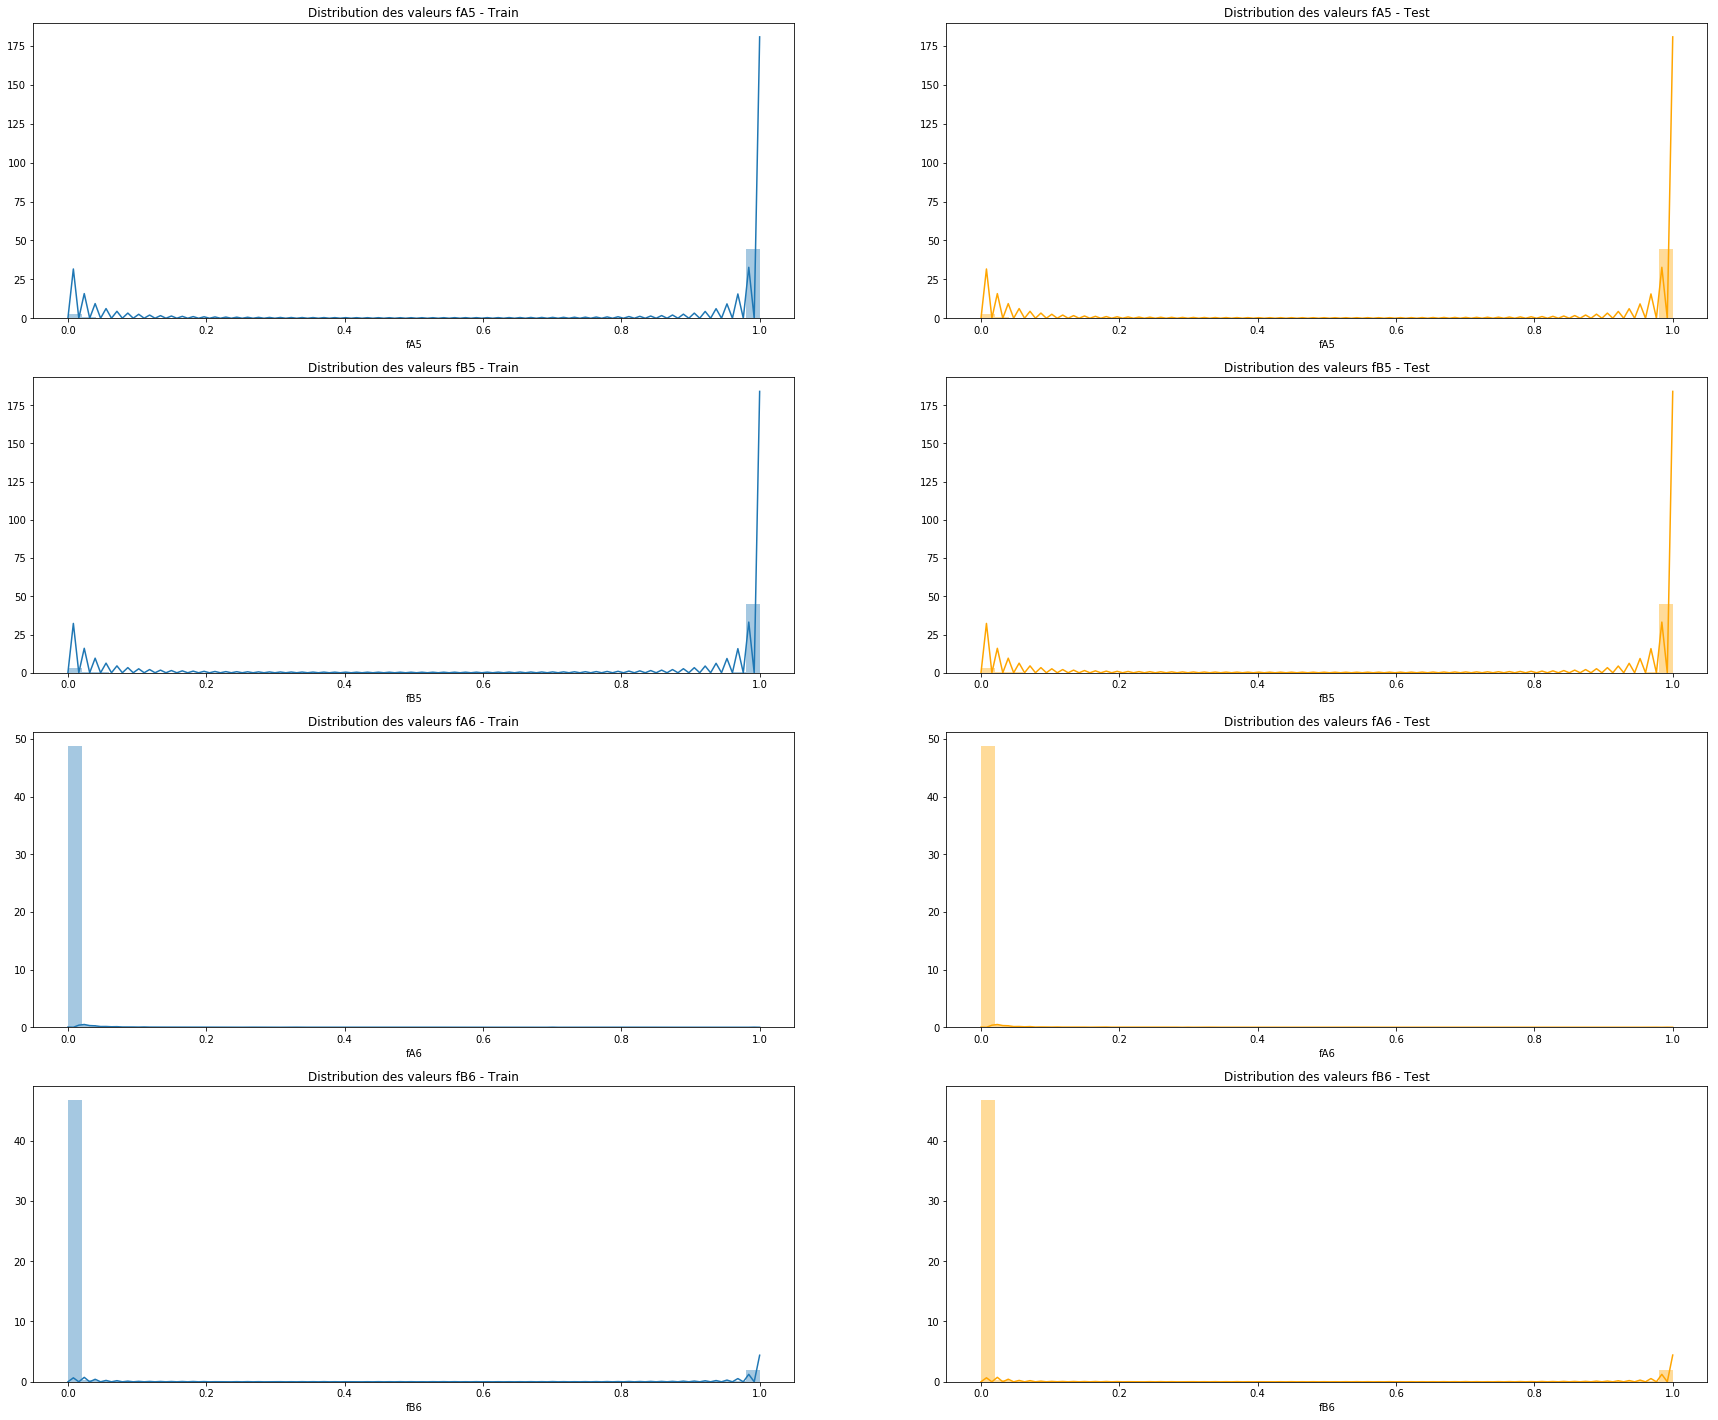

In [25]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA5)
plt.title("Distribution des valeurs fA5 - Train")

plt.subplot(422)
sns.distplot(xtest.fA5, color='orange')
plt.title("Distribution des valeurs fA5 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB5)
plt.title("Distribution des valeurs fB5 - Train")

plt.subplot(424)
sns.distplot(xtest.fB5, color='orange')
plt.title("Distribution des valeurs fB5 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA6)
plt.title("Distribution des valeurs fA6 - Train")

plt.subplot(426)
sns.distplot(xtest.fA6, color='orange')
plt.title("Distribution des valeurs fA6 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB6)
plt.title("Distribution des valeurs fB6 - Train")

plt.subplot(428)
sns.distplot(xtest.fB6, color='orange')
plt.title("Distribution des valeurs fB6 - Test")

plt.show()

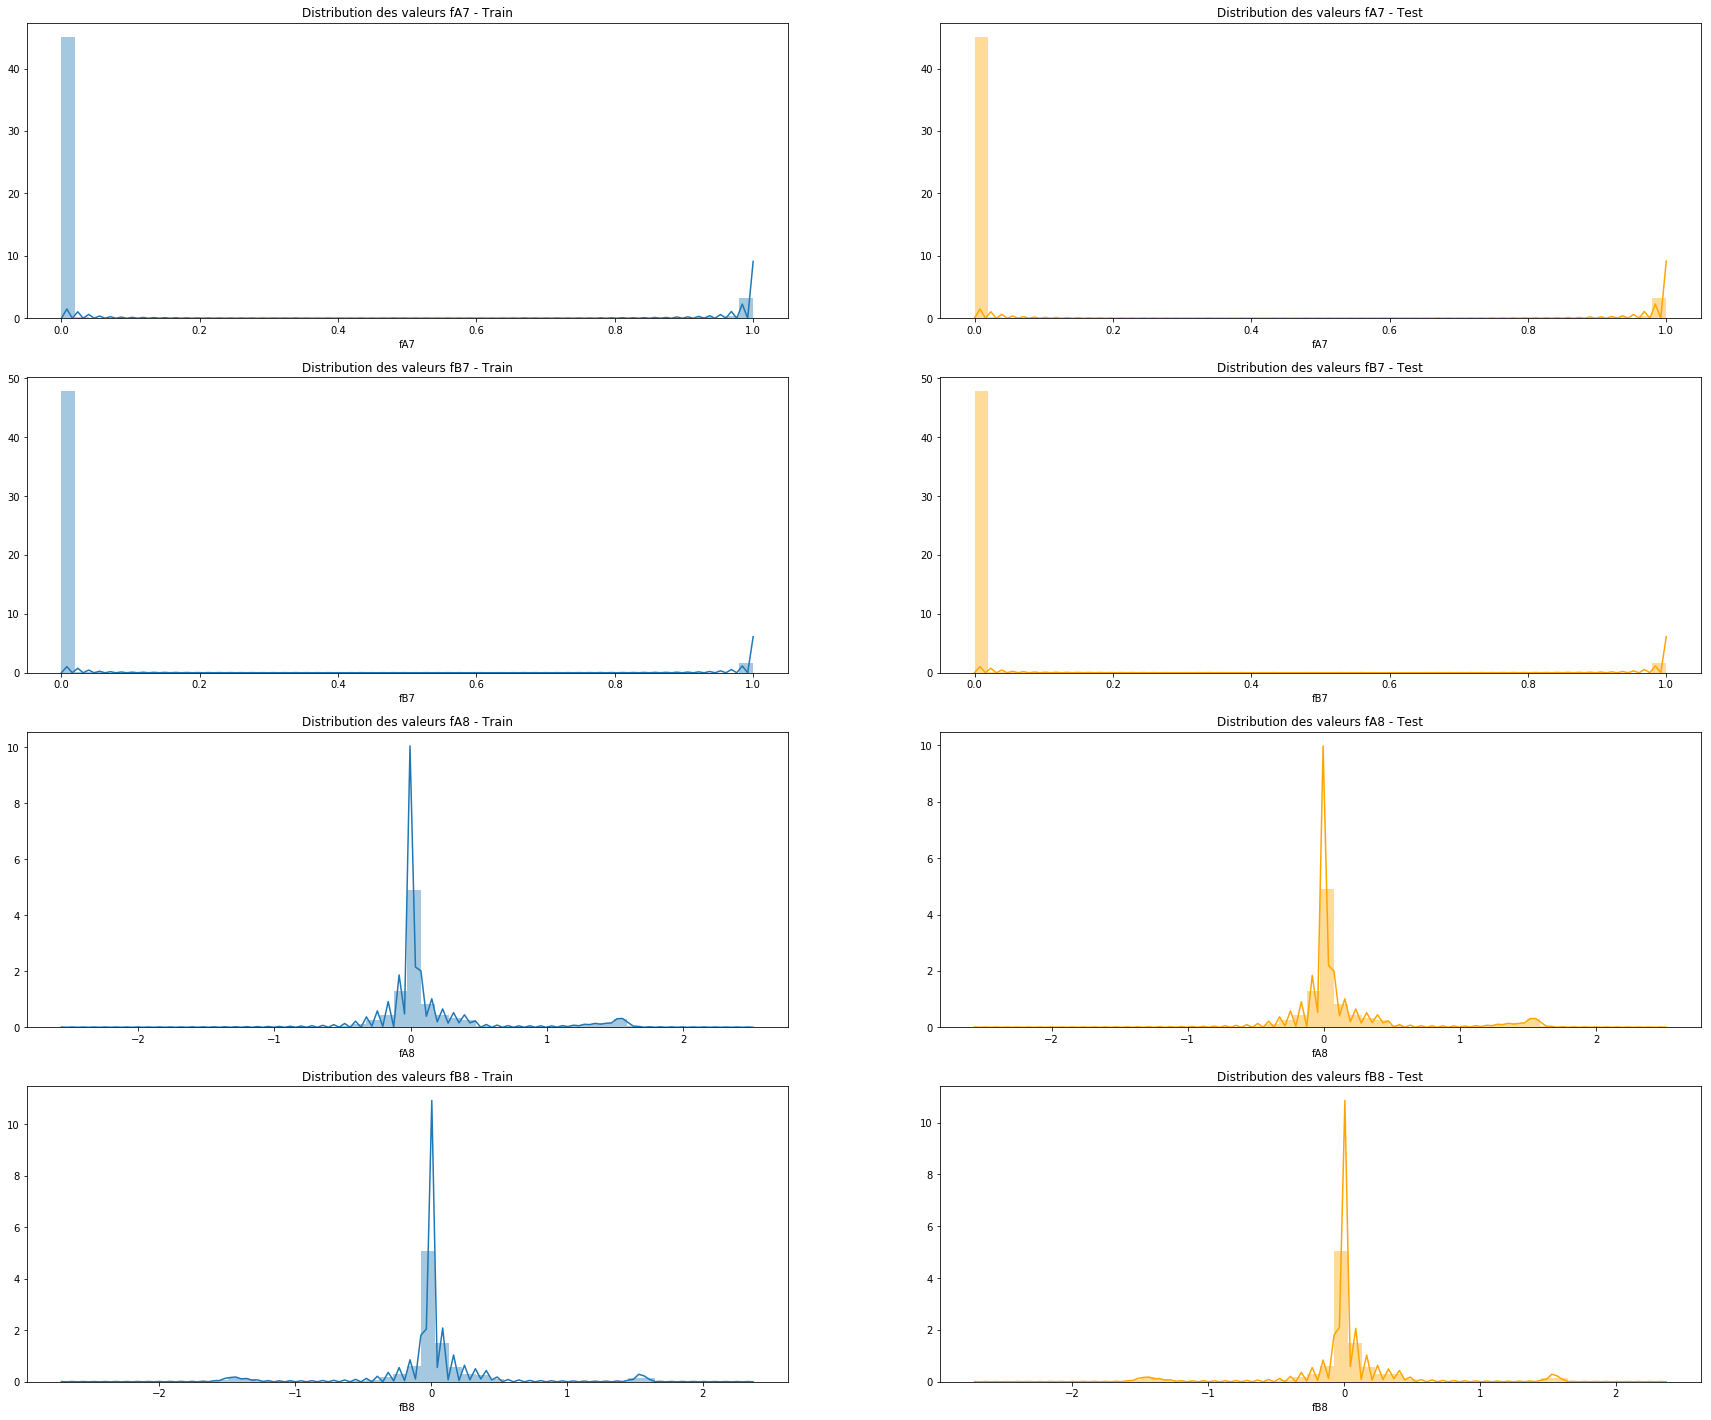

In [26]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA7)
plt.title("Distribution des valeurs fA7 - Train")

plt.subplot(422)
sns.distplot(xtest.fA7, color='orange')
plt.title("Distribution des valeurs fA7 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB7)
plt.title("Distribution des valeurs fB7 - Train")

plt.subplot(424)
sns.distplot(xtest.fB7, color='orange')
plt.title("Distribution des valeurs fB7 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA8)
plt.title("Distribution des valeurs fA8 - Train")

plt.subplot(426)
sns.distplot(xtest.fA8, color='orange')
plt.title("Distribution des valeurs fA8 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB8)
plt.title("Distribution des valeurs fB8 - Train")

plt.subplot(428)
sns.distplot(xtest.fB8, color='orange')
plt.title("Distribution des valeurs fB8 - Test")

plt.show()

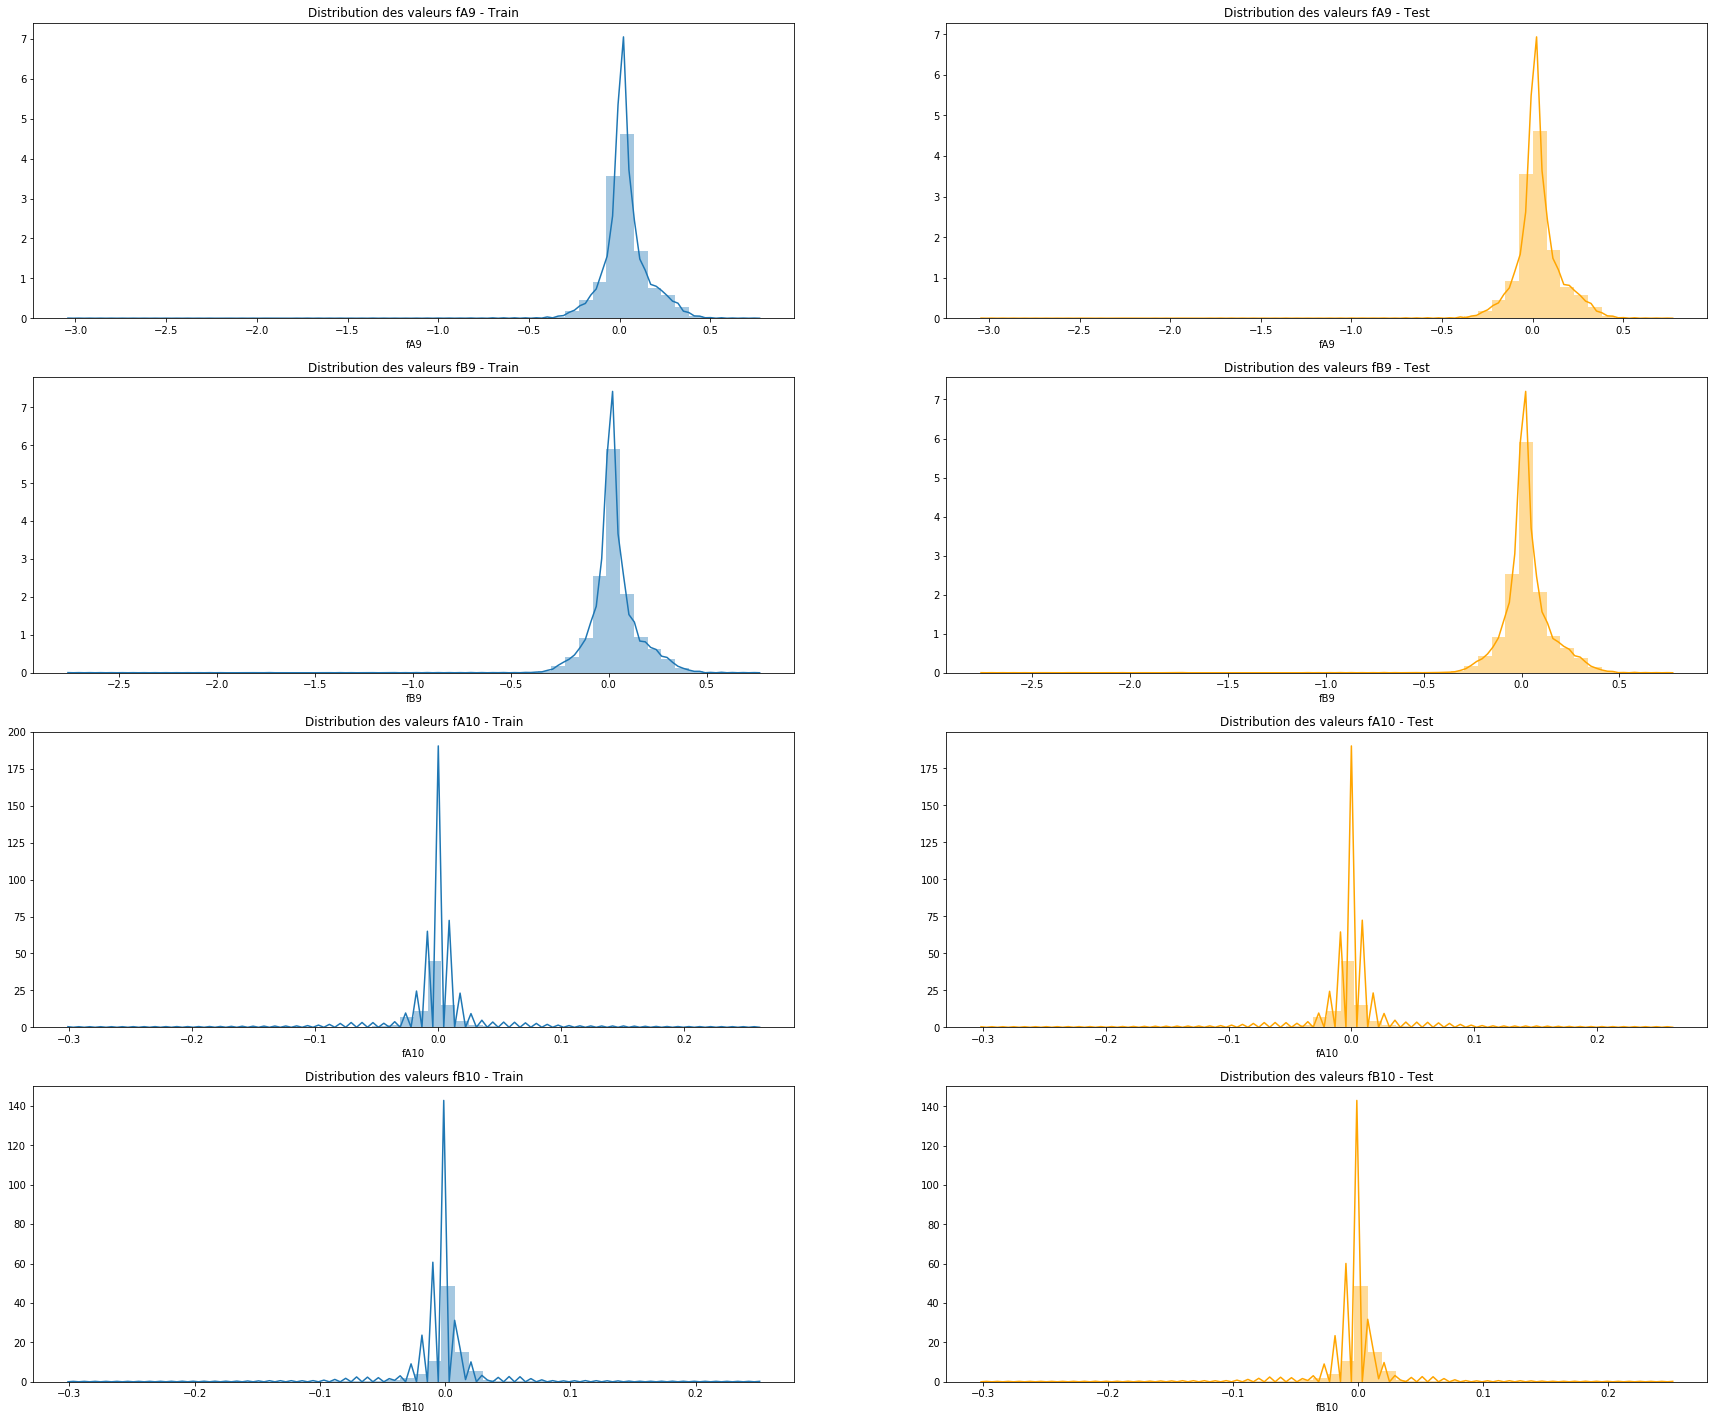

In [27]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA9)
plt.title("Distribution des valeurs fA9 - Train")

plt.subplot(422)
sns.distplot(xtest.fA9, color='orange')
plt.title("Distribution des valeurs fA9 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB9)
plt.title("Distribution des valeurs fB9 - Train")

plt.subplot(424)
sns.distplot(xtest.fB9, color='orange')
plt.title("Distribution des valeurs fB9 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA10)
plt.title("Distribution des valeurs fA10 - Train")

plt.subplot(426)
sns.distplot(xtest.fA10, color='orange')
plt.title("Distribution des valeurs fA10 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB10)
plt.title("Distribution des valeurs fB10 - Train")

plt.subplot(428)
sns.distplot(xtest.fB10, color='orange')
plt.title("Distribution des valeurs fB10 - Test")

plt.show()

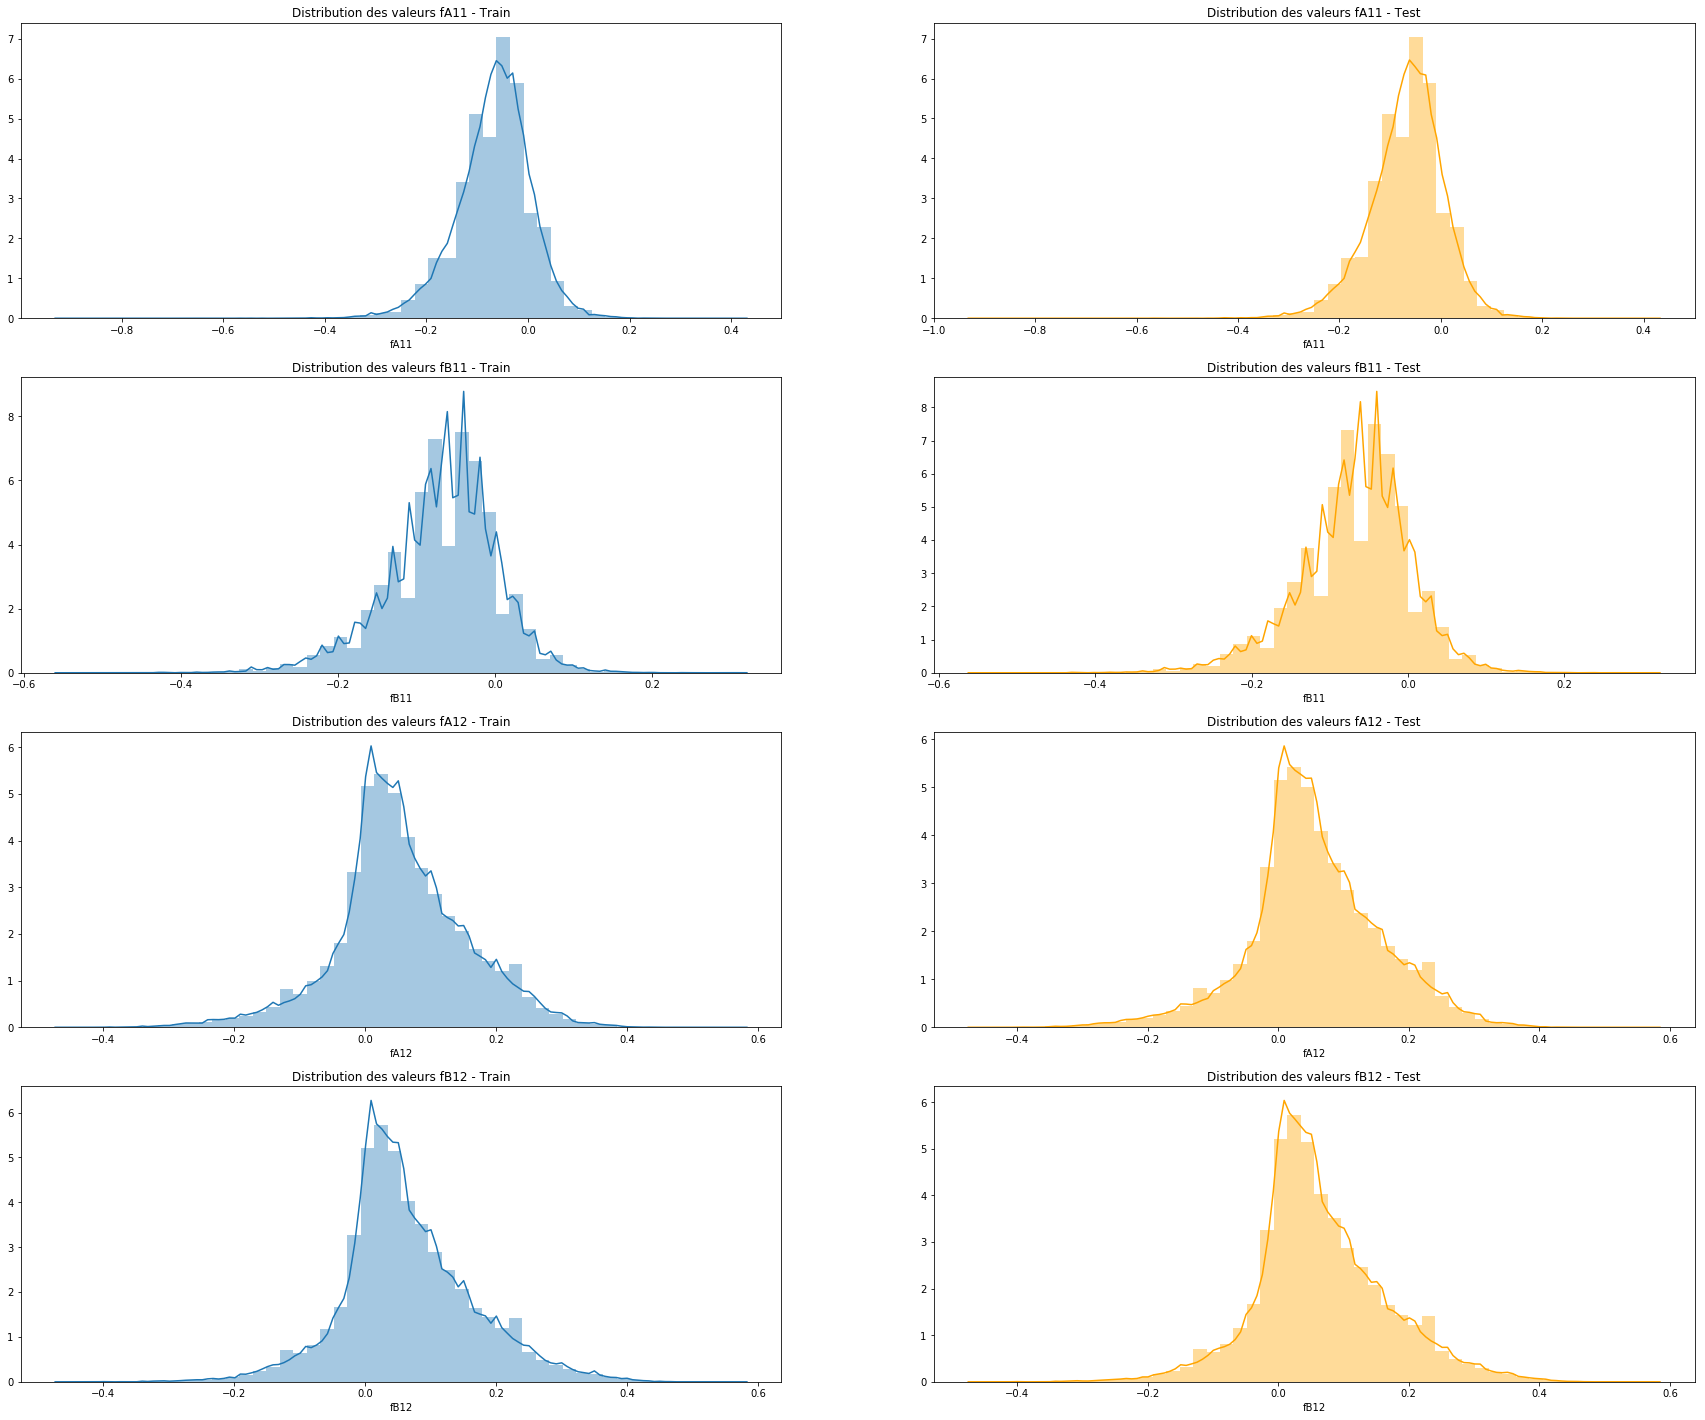

In [28]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA11)
plt.title("Distribution des valeurs fA11 - Train")

plt.subplot(422)
sns.distplot(xtest.fA11, color='orange')
plt.title("Distribution des valeurs fA11 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB11)
plt.title("Distribution des valeurs fB11 - Train")

plt.subplot(424)
sns.distplot(xtest.fB11, color='orange')
plt.title("Distribution des valeurs fB11 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA12)
plt.title("Distribution des valeurs fA12 - Train")

plt.subplot(426)
sns.distplot(xtest.fA12, color='orange')
plt.title("Distribution des valeurs fA12 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB12)
plt.title("Distribution des valeurs fB12 - Train")

plt.subplot(428)
sns.distplot(xtest.fB12, color='orange')
plt.title("Distribution des valeurs fB12 - Test")

plt.show()

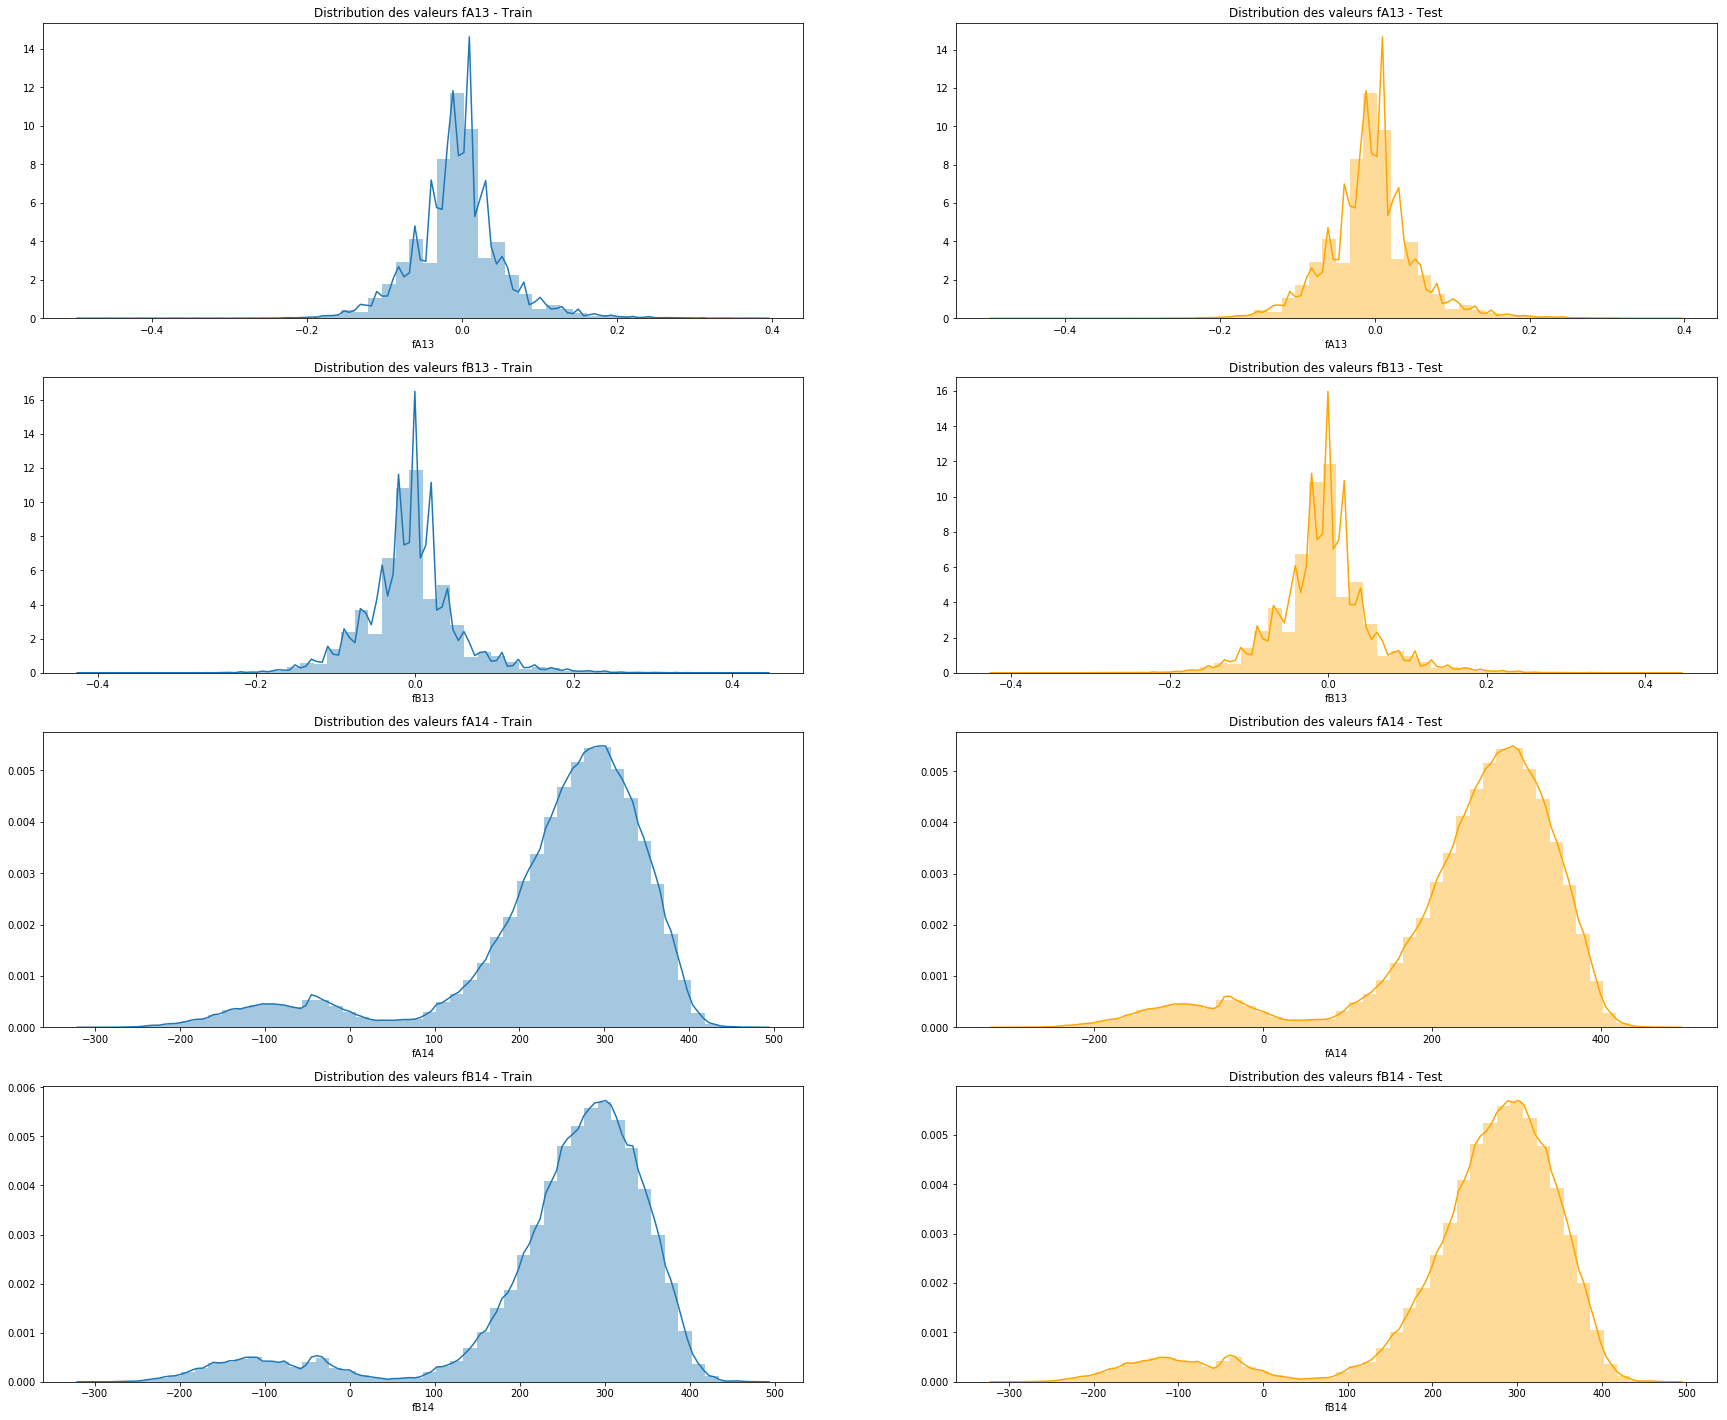

In [29]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.fA13)
plt.title("Distribution des valeurs fA13 - Train")

plt.subplot(422)
sns.distplot(xtest.fA13, color='orange')
plt.title("Distribution des valeurs fA13 - Test")

plt.subplot(423)
sns.distplot(xtrain.fB13)
plt.title("Distribution des valeurs fB13 - Train")

plt.subplot(424)
sns.distplot(xtest.fB13, color='orange')
plt.title("Distribution des valeurs fB13 - Test")

plt.subplot(425)
sns.distplot(xtrain.fA14)
plt.title("Distribution des valeurs fA14 - Train")

plt.subplot(426)
sns.distplot(xtest.fA14, color='orange')
plt.title("Distribution des valeurs fA14 - Test")

plt.subplot(427)
sns.distplot(xtrain.fB14)
plt.title("Distribution des valeurs fB14 - Train")

plt.subplot(428)
sns.distplot(xtest.fB14, color='orange')
plt.title("Distribution des valeurs fB14 - Test")

plt.show()

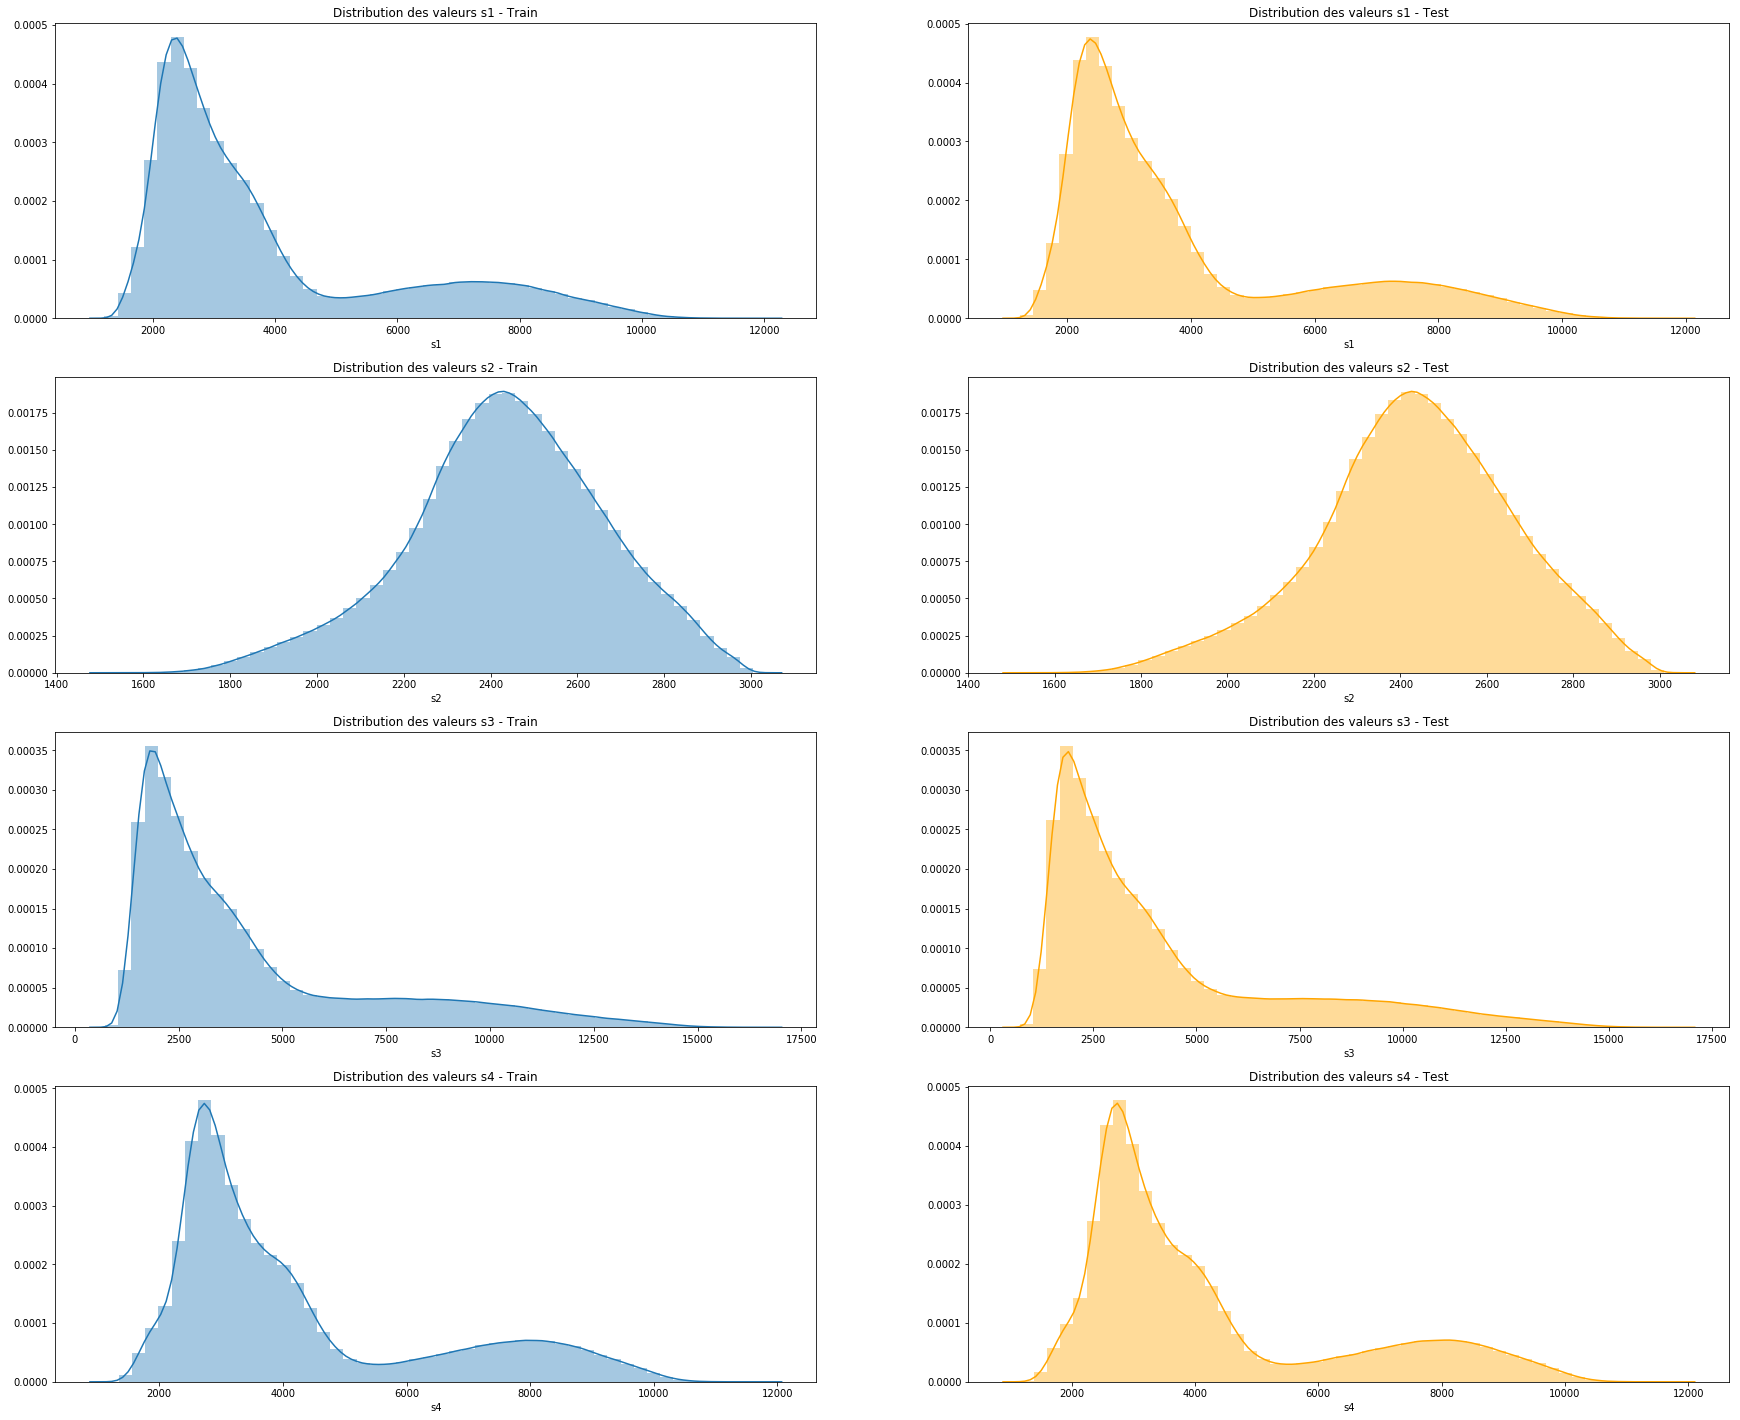

In [31]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.s1)
plt.title("Distribution des valeurs s1 - Train")

plt.subplot(422)
sns.distplot(xtest.s1, color='orange')
plt.title("Distribution des valeurs s1 - Test")

plt.subplot(423)
sns.distplot(xtrain.s2)
plt.title("Distribution des valeurs s2 - Train")

plt.subplot(424)
sns.distplot(xtest.s2, color='orange')
plt.title("Distribution des valeurs s2 - Test")

plt.subplot(425)
sns.distplot(xtrain.s3)
plt.title("Distribution des valeurs s3 - Train")

plt.subplot(426)
sns.distplot(xtest.s3, color='orange')
plt.title("Distribution des valeurs s3 - Test")

plt.subplot(427)
sns.distplot(xtrain.s4)
plt.title("Distribution des valeurs s4 - Train")

plt.subplot(428)
sns.distplot(xtest.s4, color='orange')
plt.title("Distribution des valeurs s4 - Test")

plt.show()

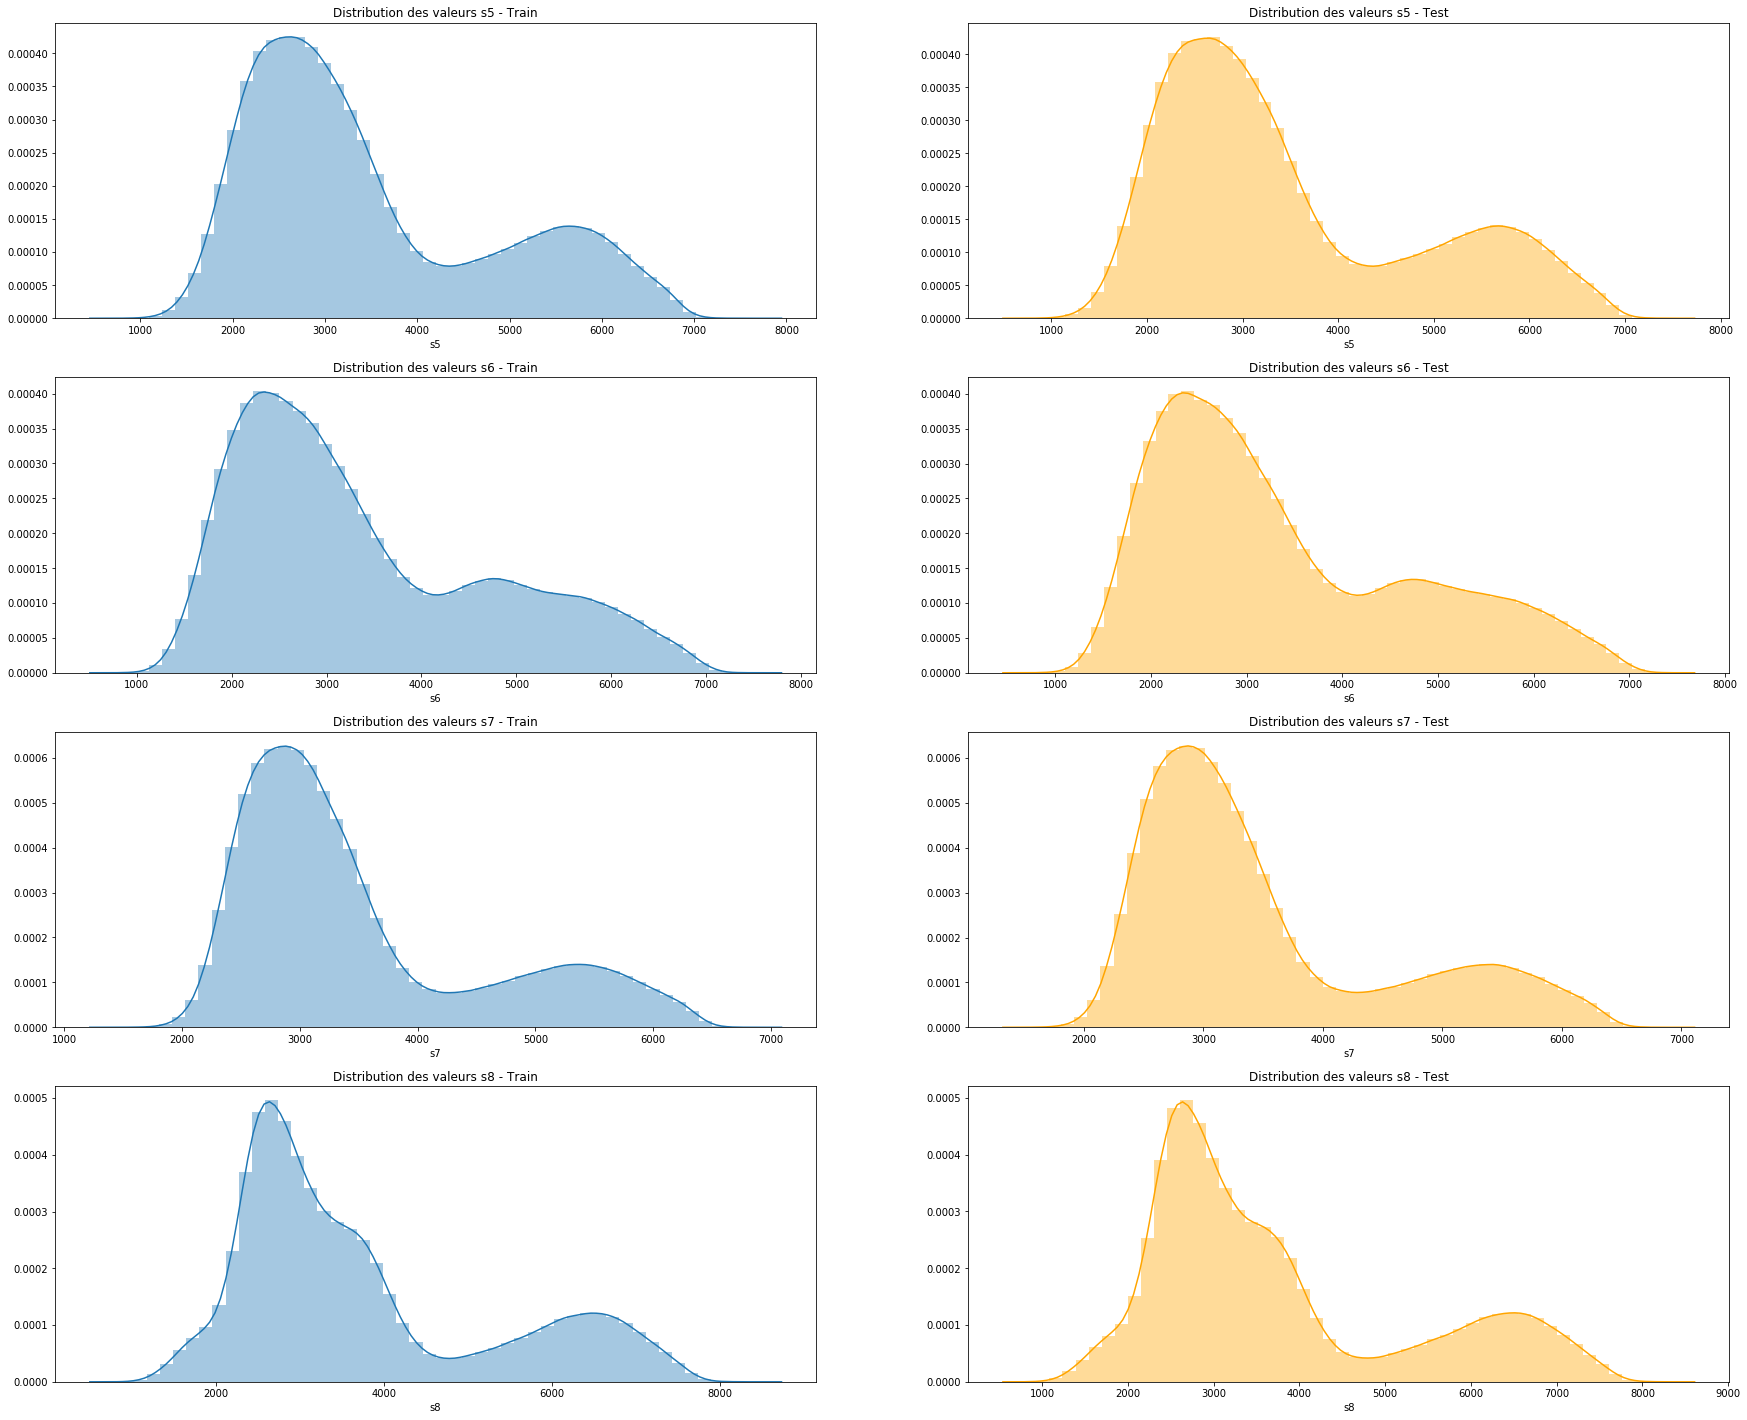

In [32]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.s5)
plt.title("Distribution des valeurs s5 - Train")

plt.subplot(422)
sns.distplot(xtest.s5, color='orange')
plt.title("Distribution des valeurs s5 - Test")

plt.subplot(423)
sns.distplot(xtrain.s6)
plt.title("Distribution des valeurs s6 - Train")

plt.subplot(424)
sns.distplot(xtest.s6, color='orange')
plt.title("Distribution des valeurs s6 - Test")

plt.subplot(425)
sns.distplot(xtrain.s7)
plt.title("Distribution des valeurs s7 - Train")

plt.subplot(426)
sns.distplot(xtest.s7, color='orange')
plt.title("Distribution des valeurs s7 - Test")

plt.subplot(427)
sns.distplot(xtrain.s8)
plt.title("Distribution des valeurs s8 - Train")

plt.subplot(428)
sns.distplot(xtest.s8, color='orange')
plt.title("Distribution des valeurs s8 - Test")

plt.show()

### Scaling the data to see how centered the distributions (s1 to s8) become

In [33]:
xtrain = xtrain - xtrain.mean(axis=0)
xtrain = xtrain / xtrain.std(axis=0)

xtest = xtest - xtest.mean(axis=0)
xtest = xtest - xtest.mean(axis=0)

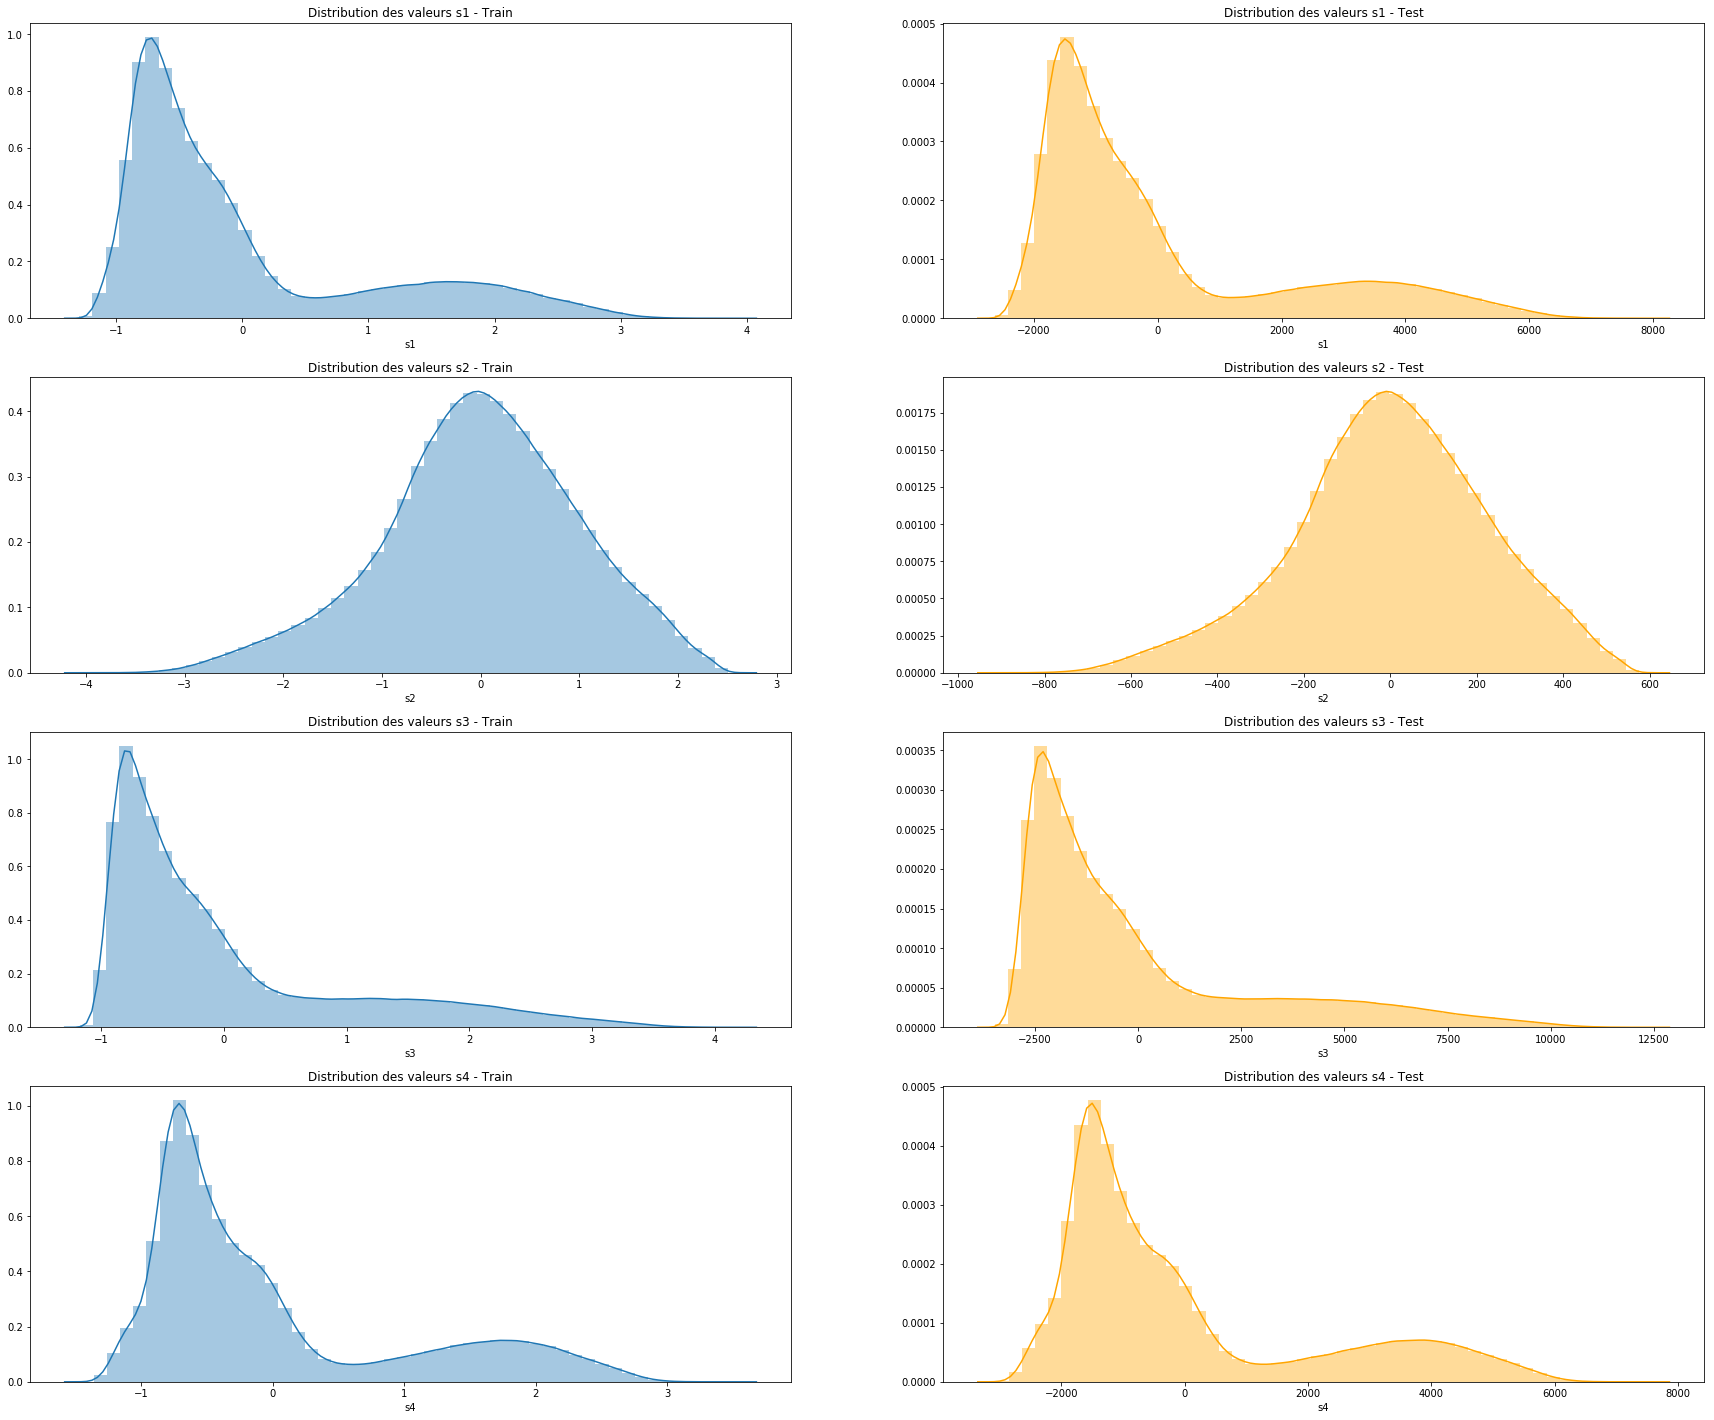

In [34]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.s1)
plt.title("Distribution des valeurs s1 - Train")

plt.subplot(422)
sns.distplot(xtest.s1, color='orange')
plt.title("Distribution des valeurs s1 - Test")

plt.subplot(423)
sns.distplot(xtrain.s2)
plt.title("Distribution des valeurs s2 - Train")

plt.subplot(424)
sns.distplot(xtest.s2, color='orange')
plt.title("Distribution des valeurs s2 - Test")

plt.subplot(425)
sns.distplot(xtrain.s3)
plt.title("Distribution des valeurs s3 - Train")

plt.subplot(426)
sns.distplot(xtest.s3, color='orange')
plt.title("Distribution des valeurs s3 - Test")

plt.subplot(427)
sns.distplot(xtrain.s4)
plt.title("Distribution des valeurs s4 - Train")

plt.subplot(428)
sns.distplot(xtest.s4, color='orange')
plt.title("Distribution des valeurs s4 - Test")

plt.show()

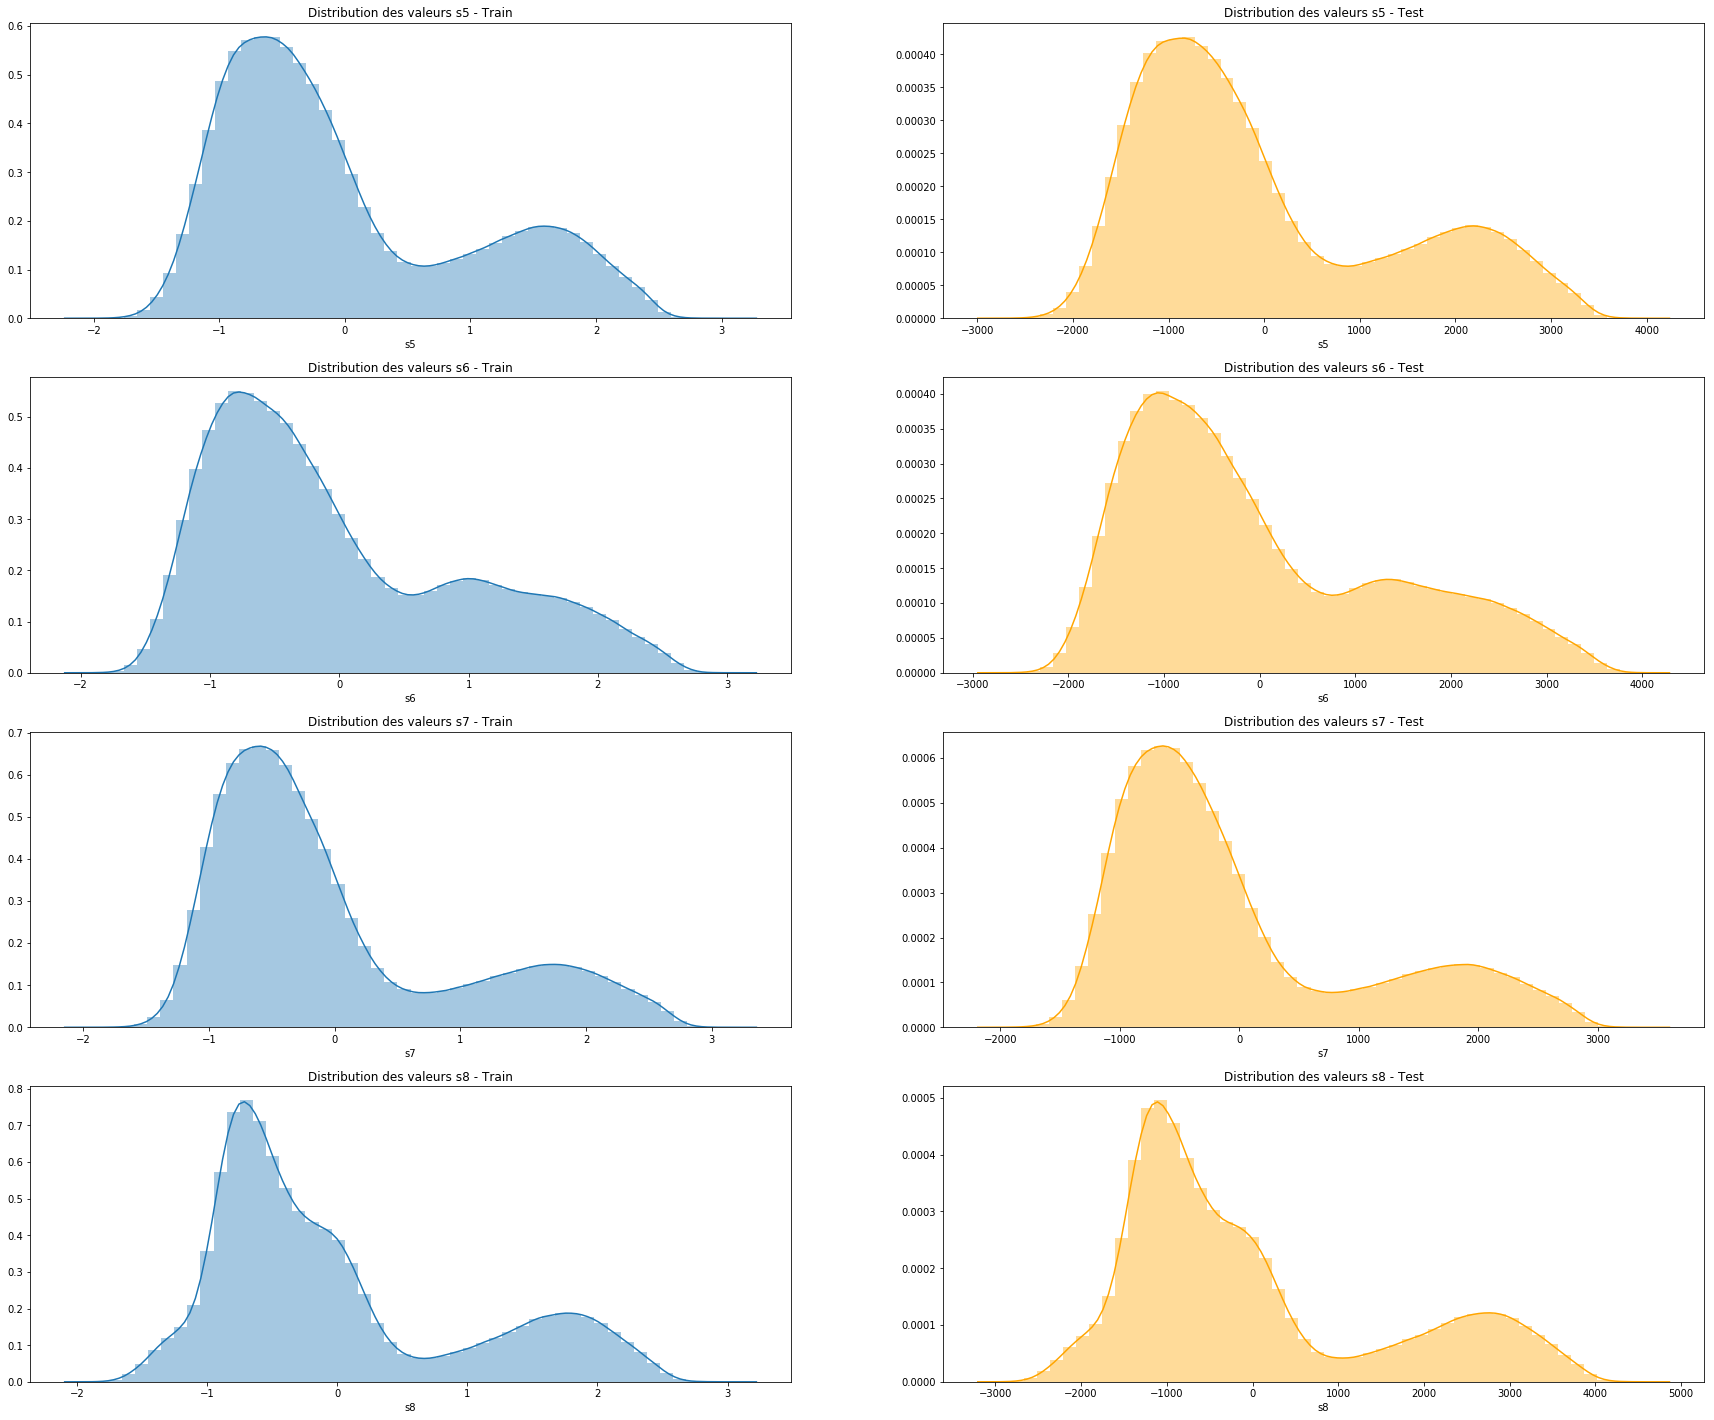

In [82]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.s5)
plt.title("Distribution des valeurs s5 - Train")

plt.subplot(422)
sns.distplot(xtest.s5, color='orange')
plt.title("Distribution des valeurs s5 - Test")

plt.subplot(423)
sns.distplot(xtrain.s6)
plt.title("Distribution des valeurs s6 - Train")

plt.subplot(424)
sns.distplot(xtest.s6, color='orange')
plt.title("Distribution des valeurs s6 - Test")

plt.subplot(425)
sns.distplot(xtrain.s7)
plt.title("Distribution des valeurs s7 - Train")

plt.subplot(426)
sns.distplot(xtest.s7, color='orange')
plt.title("Distribution des valeurs s7 - Test")

plt.subplot(427)
sns.distplot(xtrain.s8)
plt.title("Distribution des valeurs s8 - Train")

plt.subplot(428)
sns.distplot(xtest.s8, color='orange')
plt.title("Distribution des valeurs s8 - Test")

plt.show()

### Applying a Log transformation on distributions
**I'm applying a log transformation on matching scores features, since we can clearly notice a right/left skewed distribution depending on the feature. Let's plot again these features to see how their distribution behave.**

**What is resulting from this operation, is the distributions of s1 to s8 slightly more centered.**

In [45]:
# Load training data
xtrain = pd.read_csv('xtrain_challenge.csv')
ytrain = pd.read_csv('ytrain_challenge.csv')
# Load test data
xtest = pd.read_csv('xtest_challenge.csv')

In [46]:
xtrain.columns

Index(['fA1', 'fA2', 'fA3', 'fA4', 'fA5', 'fA6', 'fA7', 'fA8', 'fA9', 'fA10',
       'fA11', 'fA12', 'fA13', 'fA14', 'fB1', 'fB2', 'fB3', 'fB4', 'fB5',
       'fB6', 'fB7', 'fB8', 'fB9', 'fB10', 'fB11', 'fB12', 'fB13', 'fB14',
       's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'],
      dtype='object')

In [47]:
for col in xtrain.columns[28:38]:
   xtrain[col] = np.log(xtrain[col])

for col in xtest.columns[28:38]:
   xtest[col] = np.log(xtest[col])

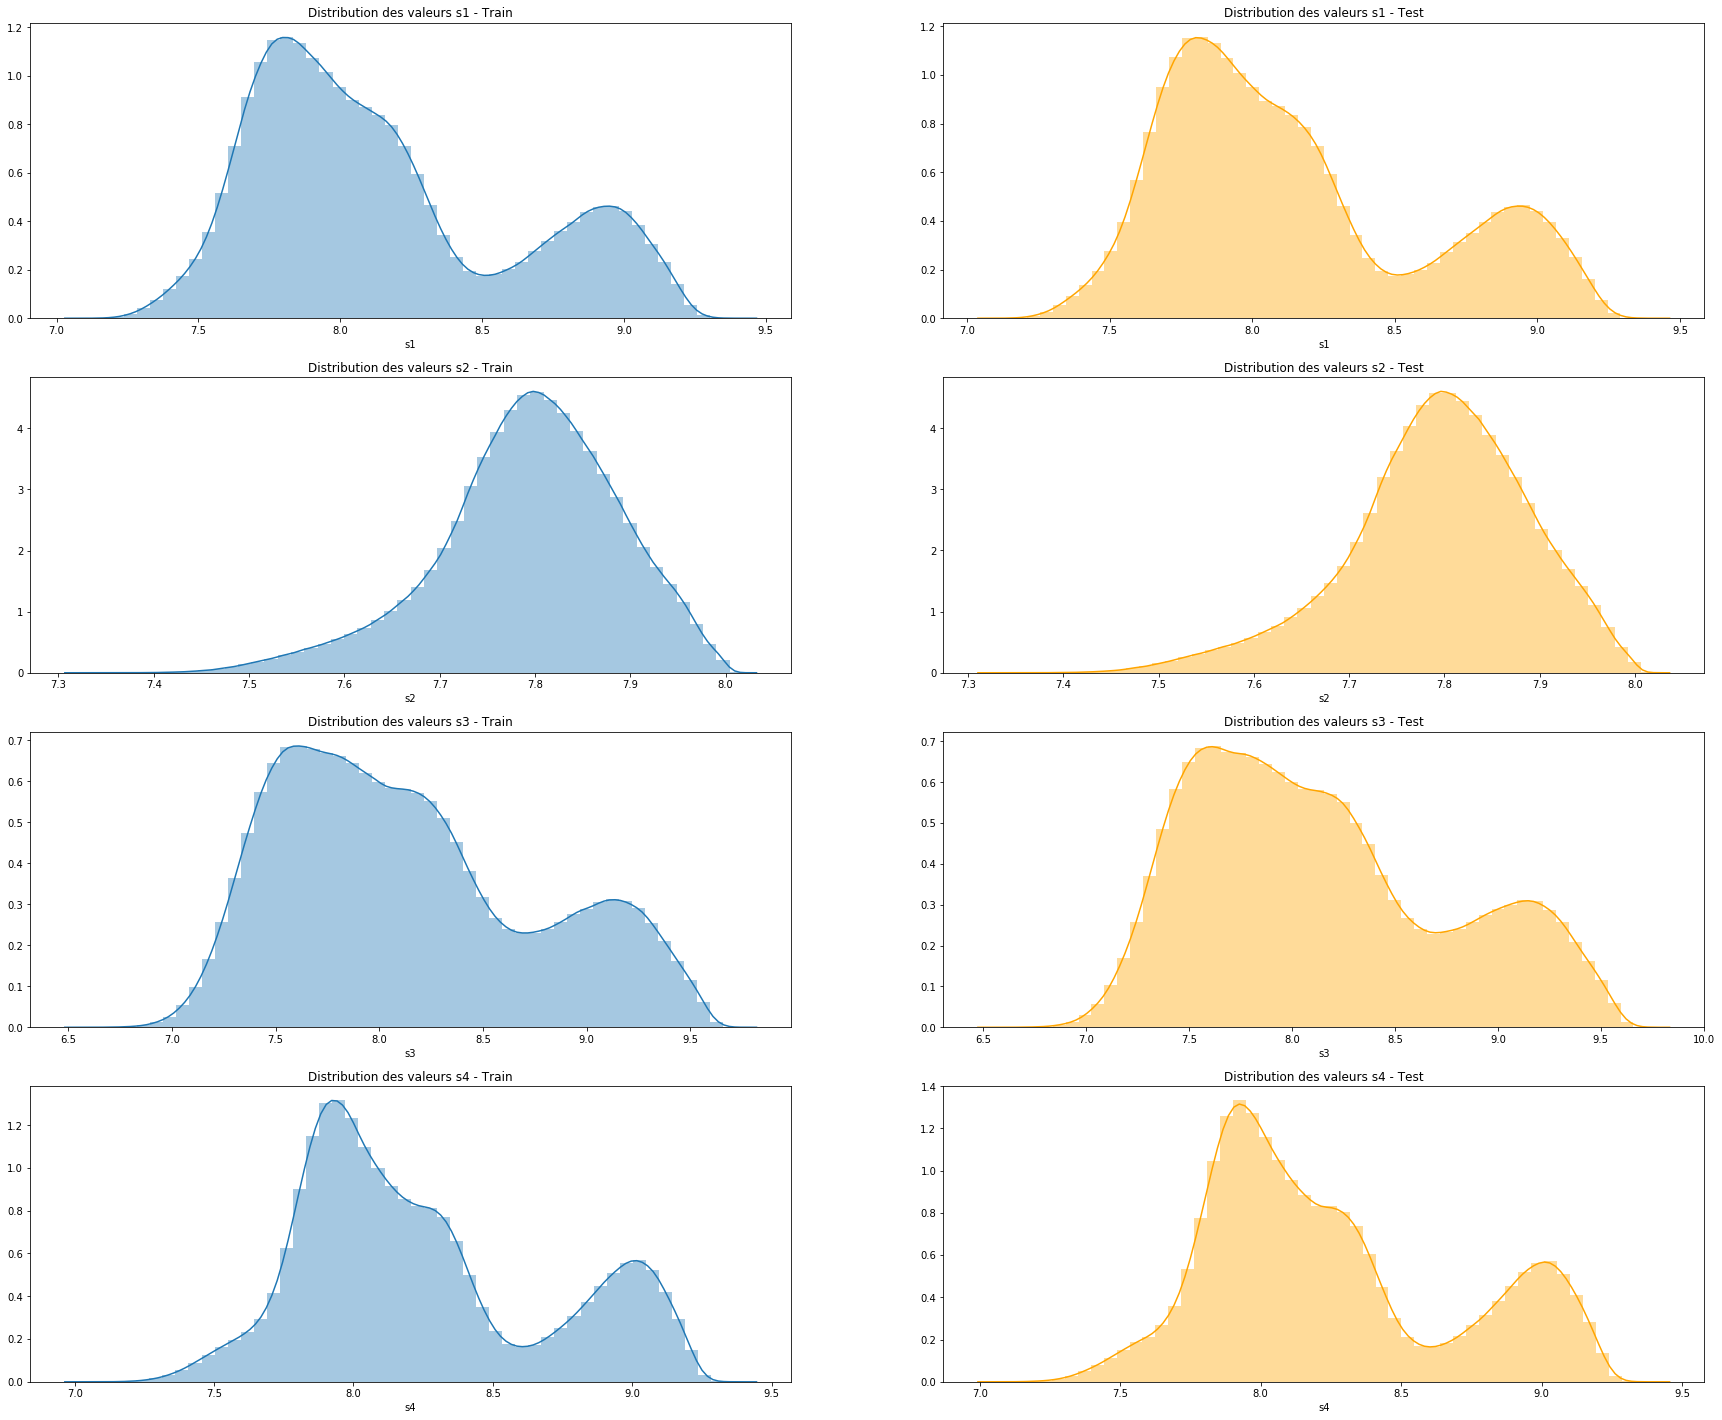

In [48]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.s1)
plt.title("Distribution des valeurs s1 - Train")

plt.subplot(422)
sns.distplot(xtest.s1, color='orange')
plt.title("Distribution des valeurs s1 - Test")

plt.subplot(423)
sns.distplot(xtrain.s2)
plt.title("Distribution des valeurs s2 - Train")

plt.subplot(424)
sns.distplot(xtest.s2, color='orange')
plt.title("Distribution des valeurs s2 - Test")

plt.subplot(425)
sns.distplot(xtrain.s3)
plt.title("Distribution des valeurs s3 - Train")

plt.subplot(426)
sns.distplot(xtest.s3, color='orange')
plt.title("Distribution des valeurs s3 - Test")

plt.subplot(427)
sns.distplot(xtrain.s4)
plt.title("Distribution des valeurs s4 - Train")

plt.subplot(428)
sns.distplot(xtest.s4, color='orange')
plt.title("Distribution des valeurs s4 - Test")

plt.show()

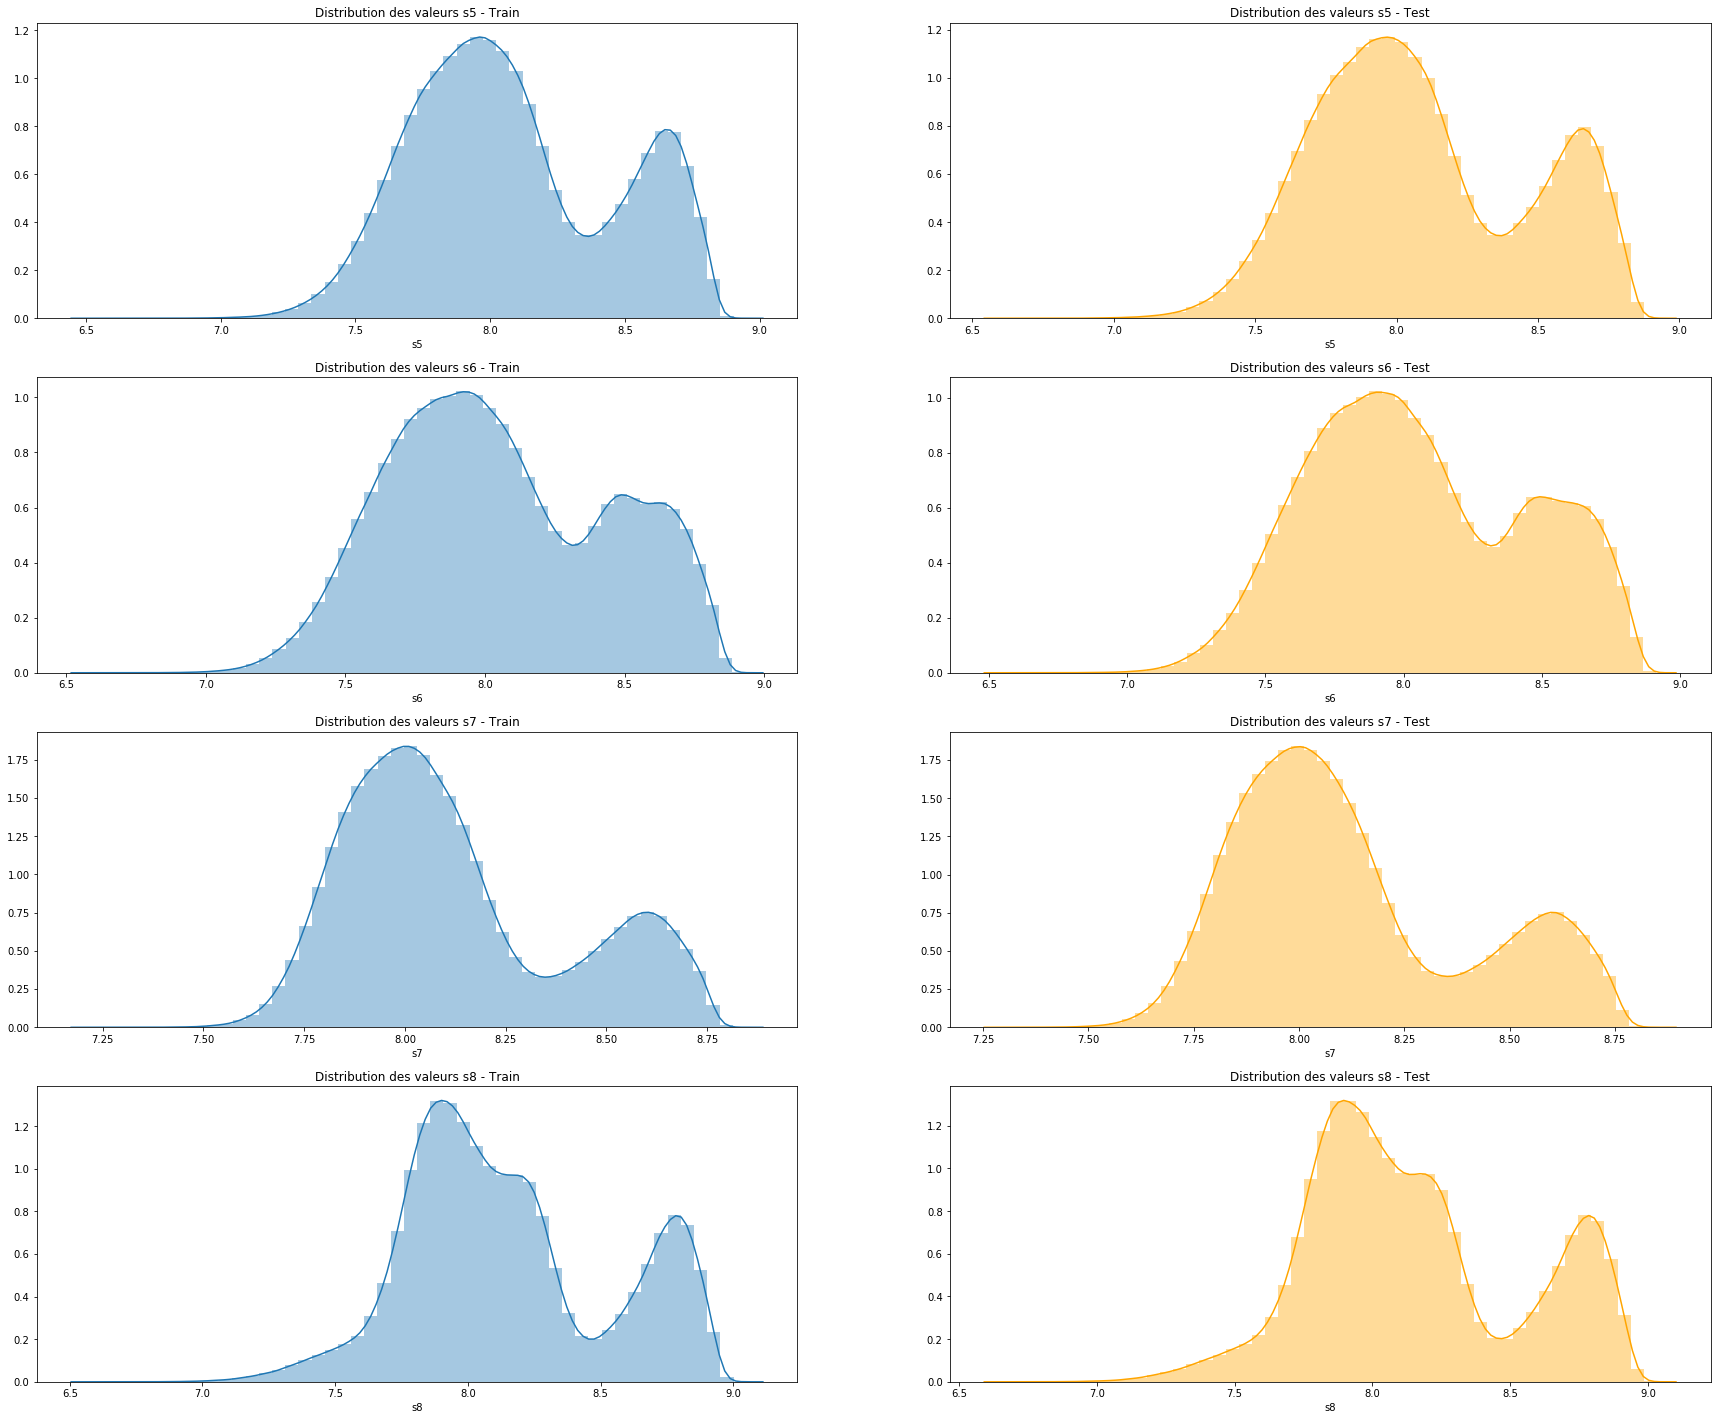

In [49]:
plt.figure(figsize=(30,25))

plt.subplot(421)
sns.distplot(xtrain.s5)
plt.title("Distribution des valeurs s5 - Train")

plt.subplot(422)
sns.distplot(xtest.s5, color='orange')
plt.title("Distribution des valeurs s5 - Test")

plt.subplot(423)
sns.distplot(xtrain.s6)
plt.title("Distribution des valeurs s6 - Train")

plt.subplot(424)
sns.distplot(xtest.s6, color='orange')
plt.title("Distribution des valeurs s6 - Test")

plt.subplot(425)
sns.distplot(xtrain.s7)
plt.title("Distribution des valeurs s7 - Train")

plt.subplot(426)
sns.distplot(xtest.s7, color='orange')
plt.title("Distribution des valeurs s7 - Test")

plt.subplot(427)
sns.distplot(xtrain.s8)
plt.title("Distribution des valeurs s8 - Train")

plt.subplot(428)
sns.distplot(xtest.s8, color='orange')
plt.title("Distribution des valeurs s8 - Test")

plt.show()

### Perform a feature importance with a Random Forest

**What comes out of this feature importance are the matching scores (s1-s8) with the highest importance regarding the label column.**

In [50]:
# Load training data
xtrain = pd.read_csv('xtrain_challenge.csv')
ytrain = pd.read_csv('ytrain_challenge.csv')
# Load test data
xtest = pd.read_csv('xtest_challenge.csv')

In [51]:
# Feature importance done with a Random Forest
# Calcul des Features Importances pour la variable cible y

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
clf.fit(xtrain, ytrain.values.ravel())

dict_feature_importance_y = {'feature': xtrain.columns.values, 'importance': clf.feature_importances_}
feature_importances_y = pd.DataFrame(data=dict_feature_importance_y).sort_values('importance', ascending=False)

plt.figure(figsize=(15,40))
sns.barplot(x="importance",
           y="feature",
           data=feature_importances_y.sort_values(by="importance",
                                          ascending=False))
plt.title('Features Importance')
plt.tight_layout()

KeyboardInterrupt: 

# Split Train set into Train / Test sets
**I decide to split the provided Train set into a new 99% Train set and a 1% Test set.  
Knowing how resourceful XGBoost and LGBMClassiers are, I'm not performing a cross validation to check the performance, nor a grid search to tune hyperparameters. I had to load models one by one and solely check the accuracy score on my confusion matrix.**

In [33]:
# Load training data
xtrain = pd.read_csv('xtrain_challenge.csv')
ytrain = pd.read_csv('ytrain_challenge.csv')
# Load test data
xtest = pd.read_csv('xtest_challenge.csv')

In [34]:
# Splitting the Xtrain dataset into a new training set and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size = 0.01, random_state = 42)

### Let's try XGBoost and LightGBM

# 1. XGBoost

**I decide to use Boosting models, therefore I began my attempts with the well-known XGBoost.  
I decided to start with these first hyperpameters for a first attempt :**
- n_estimators=5000
- learning_rate=0.05
- max_depth = 5, 
- min_child_weight=1,
- gamma=0,
- subsample = 0.8,
- colsample_bytree = 0.8,
- objective = 'binary:logistic',
- seed = 42,
- n_jobs=-1

**I chose XGBoost because of its multiple advantages:**  
- It's a regularized boosting method to avoid overfitting, even though the dataset is quite large.
- Provided with parallel processing, So that I can compute it with all my laptop cores
- I can decide the objective, for instance binary in our case
- Based on trees here, I don't need to perform a scaling on the data, not do I need to do a log (or log, exponentionel, etc) transformation.

In [4]:
# Importing XGBClassifier
from xgboost import XGBClassifier
# Fitting XGBoost to the Training set
classifier = XGBClassifier(n_estimators=5000,
                           learning_rate=0.05,
                           max_depth = 5,
                           min_child_weight=1,
                           gamma=0,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           objective = 'binary:logistic',
                           seed = 42,
                           n_jobs=-1)

In [ ]:
classifier.fit(X_train, y_train.values.ravel())
y_pred = classifier.predict(X_test)

In [5]:
# Making the Confusion matrix and checking Accuracy Score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

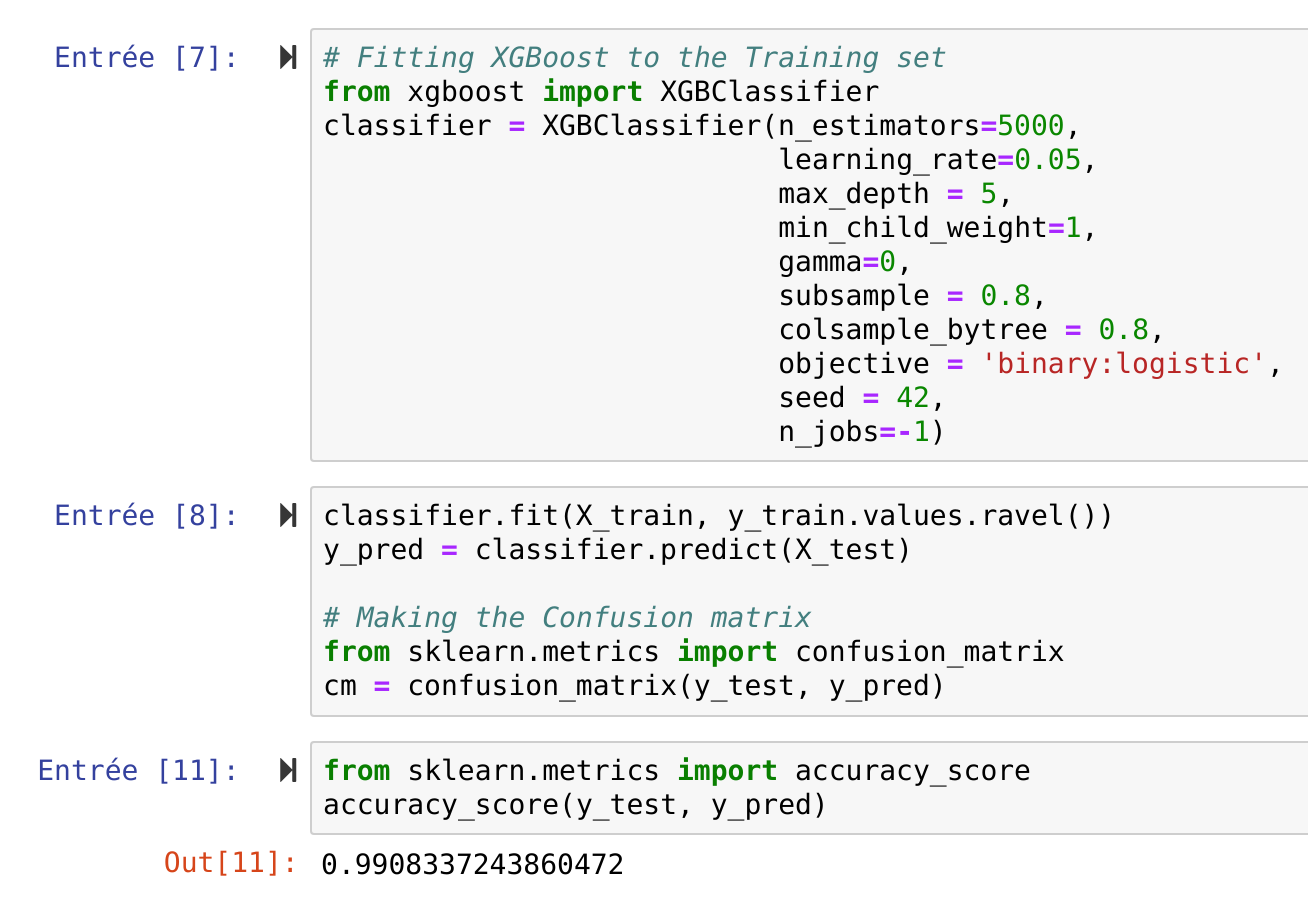

In [31]:
from IPython.display import Image
Image("image.png")

**This was my first attempt, I ran it on my second laptop, hence the above screenshot.**  
**It performed at 0.990667117168 when I submitted it. 
I didn't try another XGBoost due to its very long time to run..**

# 2. First LightGBM

**Let's try LightGBM that uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.**

In [12]:
# Create the LightGBM data containers
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [50]:
# Fitting LightGBM to the Training set
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.005,
    'verbose': 1
}
parameters['metric']=['auc', 'binary_logloss']

model = lgb.train(parameters, 
                  train_data,
                  num_boost_round=500)

"\nmodel = lgb.train(parameters, \n                  train_data,\n                  valid_sets=test_data,\n                  num_boost_round=5000,\n                  early_stopping_rounds=100) # Training until validation socre don't improve for 100 rounds\n"

In [51]:
y_pred = model.predict(X_test)

In [59]:
for i in range(0,31965):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0

In [64]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.9777569216330362

**Performed less better than my first attempt with XGBoost.  
Let's tune the hyperparameters by considerably increase the number of trees in the model to 5000.**

# 3. 2nd LightGBM

In [ ]:
# Create the LightGBM data containers
    # example : https://www.kaggle.com/ezietsman/simple-python-lightgbm-example
    # categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
    # train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
    # test_data = lightgbm.Dataset(x_test, label=y_test)
    
train_data = lgb.Dataset(X_train, label=y_train) # y_train.values.ravel() ??
test_data = lgb.Dataset(X_test, label=y_test)

In [65]:
# Train the model
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.005,
    'verbose': 1
}
parameters['metric']=['auc', 'binary_logloss']

model = lgb.train(parameters, 
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=100) # Training until validation socre don't improve for 100 rounds

[1]	valid_0's binary_logloss: 0.598407	valid_0's auc: 0.987667
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.594285	valid_0's auc: 0.990588
[3]	valid_0's binary_logloss: 0.590037	valid_0's auc: 0.991462
[4]	valid_0's binary_logloss: 0.585772	valid_0's auc: 0.992839
[5]	valid_0's binary_logloss: 0.581658	valid_0's auc: 0.993294
[6]	valid_0's binary_logloss: 0.577556	valid_0's auc: 0.99356
[7]	valid_0's binary_logloss: 0.573476	valid_0's auc: 0.994144
[8]	valid_0's binary_logloss: 0.56945	valid_0's auc: 0.99423
[9]	valid_0's binary_logloss: 0.565694	valid_0's auc: 0.994338
[10]	valid_0's binary_logloss: 0.561841	valid_0's auc: 0.99432
[11]	valid_0's binary_logloss: 0.558112	valid_0's auc: 0.994364
[12]	valid_0's binary_logloss: 0.554287	valid_0's auc: 0.994473
[13]	valid_0's binary_logloss: 0.550726	valid_0's auc: 0.994414
[14]	valid_0's binary_logloss: 0.546992	valid_0's auc: 0.994434
[15]	valid_0's binary_logloss: 0.543505	valid_0's auc:

[130]	valid_0's binary_logloss: 0.29573	valid_0's auc: 0.995615
[131]	valid_0's binary_logloss: 0.294359	valid_0's auc: 0.995626
[132]	valid_0's binary_logloss: 0.293	valid_0's auc: 0.995636
[133]	valid_0's binary_logloss: 0.291648	valid_0's auc: 0.995642
[134]	valid_0's binary_logloss: 0.290307	valid_0's auc: 0.995652
[135]	valid_0's binary_logloss: 0.289067	valid_0's auc: 0.99566
[136]	valid_0's binary_logloss: 0.287822	valid_0's auc: 0.995659
[137]	valid_0's binary_logloss: 0.286549	valid_0's auc: 0.995681
[138]	valid_0's binary_logloss: 0.285264	valid_0's auc: 0.995687
[139]	valid_0's binary_logloss: 0.28395	valid_0's auc: 0.995697
[140]	valid_0's binary_logloss: 0.282753	valid_0's auc: 0.995695
[141]	valid_0's binary_logloss: 0.281564	valid_0's auc: 0.995692
[142]	valid_0's binary_logloss: 0.280296	valid_0's auc: 0.9957
[143]	valid_0's binary_logloss: 0.279201	valid_0's auc: 0.995718
[144]	valid_0's binary_logloss: 0.277943	valid_0's auc: 0.995725
[145]	valid_0's binary_logloss: 0

[258]	valid_0's binary_logloss: 0.18042	valid_0's auc: 0.996171
[259]	valid_0's binary_logloss: 0.179798	valid_0's auc: 0.996178
[260]	valid_0's binary_logloss: 0.179213	valid_0's auc: 0.996179
[261]	valid_0's binary_logloss: 0.178573	valid_0's auc: 0.996184
[262]	valid_0's binary_logloss: 0.177983	valid_0's auc: 0.996184
[263]	valid_0's binary_logloss: 0.177358	valid_0's auc: 0.996191
[264]	valid_0's binary_logloss: 0.176744	valid_0's auc: 0.996193
[265]	valid_0's binary_logloss: 0.176123	valid_0's auc: 0.996197
[266]	valid_0's binary_logloss: 0.175554	valid_0's auc: 0.996201
[267]	valid_0's binary_logloss: 0.174991	valid_0's auc: 0.996202
[268]	valid_0's binary_logloss: 0.174371	valid_0's auc: 0.996209
[269]	valid_0's binary_logloss: 0.173778	valid_0's auc: 0.996212
[270]	valid_0's binary_logloss: 0.173226	valid_0's auc: 0.996214
[271]	valid_0's binary_logloss: 0.17262	valid_0's auc: 0.996216
[272]	valid_0's binary_logloss: 0.172022	valid_0's auc: 0.99622
[273]	valid_0's binary_loglo

[386]	valid_0's binary_logloss: 0.123324	valid_0's auc: 0.996576
[387]	valid_0's binary_logloss: 0.122993	valid_0's auc: 0.996578
[388]	valid_0's binary_logloss: 0.122664	valid_0's auc: 0.996583
[389]	valid_0's binary_logloss: 0.12236	valid_0's auc: 0.996585
[390]	valid_0's binary_logloss: 0.122074	valid_0's auc: 0.996586
[391]	valid_0's binary_logloss: 0.121772	valid_0's auc: 0.99659
[392]	valid_0's binary_logloss: 0.121478	valid_0's auc: 0.996594
[393]	valid_0's binary_logloss: 0.121188	valid_0's auc: 0.996595
[394]	valid_0's binary_logloss: 0.120855	valid_0's auc: 0.996601
[395]	valid_0's binary_logloss: 0.120524	valid_0's auc: 0.996605
[396]	valid_0's binary_logloss: 0.120244	valid_0's auc: 0.996605
[397]	valid_0's binary_logloss: 0.119934	valid_0's auc: 0.99661
[398]	valid_0's binary_logloss: 0.119604	valid_0's auc: 0.996615
[399]	valid_0's binary_logloss: 0.119298	valid_0's auc: 0.996619
[400]	valid_0's binary_logloss: 0.119017	valid_0's auc: 0.996621
[401]	valid_0's binary_loglo

[513]	valid_0's binary_logloss: 0.0933737	valid_0's auc: 0.996965
[514]	valid_0's binary_logloss: 0.0931858	valid_0's auc: 0.996967
[515]	valid_0's binary_logloss: 0.0930207	valid_0's auc: 0.996969
[516]	valid_0's binary_logloss: 0.0928588	valid_0's auc: 0.996971
[517]	valid_0's binary_logloss: 0.0926671	valid_0's auc: 0.996975
[518]	valid_0's binary_logloss: 0.0924841	valid_0's auc: 0.996979
[519]	valid_0's binary_logloss: 0.0924303	valid_0's auc: 0.996986
[520]	valid_0's binary_logloss: 0.0922424	valid_0's auc: 0.996989
[521]	valid_0's binary_logloss: 0.0920593	valid_0's auc: 0.996991
[522]	valid_0's binary_logloss: 0.0918923	valid_0's auc: 0.996994
[523]	valid_0's binary_logloss: 0.0917324	valid_0's auc: 0.996994
[524]	valid_0's binary_logloss: 0.0915599	valid_0's auc: 0.996998
[525]	valid_0's binary_logloss: 0.091398	valid_0's auc: 0.997001
[526]	valid_0's binary_logloss: 0.0912165	valid_0's auc: 0.997003
[527]	valid_0's binary_logloss: 0.0910585	valid_0's auc: 0.997005
[528]	valid

[639]	valid_0's binary_logloss: 0.0761426	valid_0's auc: 0.997303
[640]	valid_0's binary_logloss: 0.0760214	valid_0's auc: 0.997307
[641]	valid_0's binary_logloss: 0.0759089	valid_0's auc: 0.997309
[642]	valid_0's binary_logloss: 0.075808	valid_0's auc: 0.997311
[643]	valid_0's binary_logloss: 0.0756892	valid_0's auc: 0.997313
[644]	valid_0's binary_logloss: 0.075574	valid_0's auc: 0.997315
[645]	valid_0's binary_logloss: 0.0754778	valid_0's auc: 0.997317
[646]	valid_0's binary_logloss: 0.075368	valid_0's auc: 0.99732
[647]	valid_0's binary_logloss: 0.0752705	valid_0's auc: 0.997321
[648]	valid_0's binary_logloss: 0.0751746	valid_0's auc: 0.997323
[649]	valid_0's binary_logloss: 0.0750677	valid_0's auc: 0.997324
[650]	valid_0's binary_logloss: 0.0749697	valid_0's auc: 0.997327
[651]	valid_0's binary_logloss: 0.0748605	valid_0's auc: 0.997329
[652]	valid_0's binary_logloss: 0.0747706	valid_0's auc: 0.997333
[653]	valid_0's binary_logloss: 0.0746765	valid_0's auc: 0.997334
[654]	valid_0'

[765]	valid_0's binary_logloss: 0.0654412	valid_0's auc: 0.997585
[766]	valid_0's binary_logloss: 0.0653685	valid_0's auc: 0.997588
[767]	valid_0's binary_logloss: 0.065295	valid_0's auc: 0.997591
[768]	valid_0's binary_logloss: 0.0652237	valid_0's auc: 0.997593
[769]	valid_0's binary_logloss: 0.0651645	valid_0's auc: 0.997595
[770]	valid_0's binary_logloss: 0.065096	valid_0's auc: 0.997597
[771]	valid_0's binary_logloss: 0.0650328	valid_0's auc: 0.9976
[772]	valid_0's binary_logloss: 0.0649736	valid_0's auc: 0.997601
[773]	valid_0's binary_logloss: 0.0649153	valid_0's auc: 0.997602
[774]	valid_0's binary_logloss: 0.0648479	valid_0's auc: 0.997604
[775]	valid_0's binary_logloss: 0.0648065	valid_0's auc: 0.997608
[776]	valid_0's binary_logloss: 0.0647368	valid_0's auc: 0.99761
[777]	valid_0's binary_logloss: 0.0646642	valid_0's auc: 0.997613
[778]	valid_0's binary_logloss: 0.0646018	valid_0's auc: 0.997615
[779]	valid_0's binary_logloss: 0.0645357	valid_0's auc: 0.997617
[780]	valid_0's

[891]	valid_0's binary_logloss: 0.0586252	valid_0's auc: 0.997818
[892]	valid_0's binary_logloss: 0.0585775	valid_0's auc: 0.99782
[893]	valid_0's binary_logloss: 0.0585396	valid_0's auc: 0.997821
[894]	valid_0's binary_logloss: 0.0585009	valid_0's auc: 0.997823
[895]	valid_0's binary_logloss: 0.0584628	valid_0's auc: 0.997824
[896]	valid_0's binary_logloss: 0.0584246	valid_0's auc: 0.997826
[897]	valid_0's binary_logloss: 0.0583792	valid_0's auc: 0.997827
[898]	valid_0's binary_logloss: 0.0583323	valid_0's auc: 0.99783
[899]	valid_0's binary_logloss: 0.0582942	valid_0's auc: 0.997831
[900]	valid_0's binary_logloss: 0.0582488	valid_0's auc: 0.997833
[901]	valid_0's binary_logloss: 0.0581985	valid_0's auc: 0.997836
[902]	valid_0's binary_logloss: 0.0581581	valid_0's auc: 0.997837
[903]	valid_0's binary_logloss: 0.0581143	valid_0's auc: 0.997839
[904]	valid_0's binary_logloss: 0.0580683	valid_0's auc: 0.997841
[905]	valid_0's binary_logloss: 0.0580252	valid_0's auc: 0.997842
[906]	valid_

[1017]	valid_0's binary_logloss: 0.054009	valid_0's auc: 0.998009
[1018]	valid_0's binary_logloss: 0.0539746	valid_0's auc: 0.99801
[1019]	valid_0's binary_logloss: 0.053943	valid_0's auc: 0.998012
[1020]	valid_0's binary_logloss: 0.053911	valid_0's auc: 0.998013
[1021]	valid_0's binary_logloss: 0.0538779	valid_0's auc: 0.998014
[1022]	valid_0's binary_logloss: 0.0538406	valid_0's auc: 0.998015
[1023]	valid_0's binary_logloss: 0.0538139	valid_0's auc: 0.998016
[1024]	valid_0's binary_logloss: 0.053785	valid_0's auc: 0.998017
[1025]	valid_0's binary_logloss: 0.0537542	valid_0's auc: 0.998018
[1026]	valid_0's binary_logloss: 0.0537234	valid_0's auc: 0.998019
[1027]	valid_0's binary_logloss: 0.053689	valid_0's auc: 0.99802
[1028]	valid_0's binary_logloss: 0.0536628	valid_0's auc: 0.998022
[1029]	valid_0's binary_logloss: 0.0536294	valid_0's auc: 0.998023
[1030]	valid_0's binary_logloss: 0.0535976	valid_0's auc: 0.998024
[1031]	valid_0's binary_logloss: 0.0535661	valid_0's auc: 0.998025
[1

[1141]	valid_0's binary_logloss: 0.0507336	valid_0's auc: 0.998163
[1142]	valid_0's binary_logloss: 0.0507112	valid_0's auc: 0.998164
[1143]	valid_0's binary_logloss: 0.0506909	valid_0's auc: 0.998165
[1144]	valid_0's binary_logloss: 0.0506658	valid_0's auc: 0.998166
[1145]	valid_0's binary_logloss: 0.0506387	valid_0's auc: 0.998168
[1146]	valid_0's binary_logloss: 0.050621	valid_0's auc: 0.998169
[1147]	valid_0's binary_logloss: 0.0505995	valid_0's auc: 0.998169
[1148]	valid_0's binary_logloss: 0.0505834	valid_0's auc: 0.99817
[1149]	valid_0's binary_logloss: 0.050561	valid_0's auc: 0.998171
[1150]	valid_0's binary_logloss: 0.0505363	valid_0's auc: 0.998172
[1151]	valid_0's binary_logloss: 0.0505129	valid_0's auc: 0.998173
[1152]	valid_0's binary_logloss: 0.0504963	valid_0's auc: 0.998174
[1153]	valid_0's binary_logloss: 0.0504772	valid_0's auc: 0.998174
[1154]	valid_0's binary_logloss: 0.0504504	valid_0's auc: 0.998176
[1155]	valid_0's binary_logloss: 0.0504268	valid_0's auc: 0.99817

[1265]	valid_0's binary_logloss: 0.0483512	valid_0's auc: 0.998278
[1266]	valid_0's binary_logloss: 0.0483332	valid_0's auc: 0.998279
[1267]	valid_0's binary_logloss: 0.0483181	valid_0's auc: 0.99828
[1268]	valid_0's binary_logloss: 0.0483013	valid_0's auc: 0.998281
[1269]	valid_0's binary_logloss: 0.0482848	valid_0's auc: 0.998282
[1270]	valid_0's binary_logloss: 0.0482672	valid_0's auc: 0.998283
[1271]	valid_0's binary_logloss: 0.0482523	valid_0's auc: 0.998283
[1272]	valid_0's binary_logloss: 0.0482344	valid_0's auc: 0.998285
[1273]	valid_0's binary_logloss: 0.0482197	valid_0's auc: 0.998286
[1274]	valid_0's binary_logloss: 0.0482031	valid_0's auc: 0.998287
[1275]	valid_0's binary_logloss: 0.0481859	valid_0's auc: 0.998287
[1276]	valid_0's binary_logloss: 0.0481671	valid_0's auc: 0.998288
[1277]	valid_0's binary_logloss: 0.0481473	valid_0's auc: 0.998289
[1278]	valid_0's binary_logloss: 0.0481289	valid_0's auc: 0.99829
[1279]	valid_0's binary_logloss: 0.0481131	valid_0's auc: 0.9982

[1389]	valid_0's binary_logloss: 0.0464773	valid_0's auc: 0.998373
[1390]	valid_0's binary_logloss: 0.0464595	valid_0's auc: 0.998374
[1391]	valid_0's binary_logloss: 0.0464442	valid_0's auc: 0.998375
[1392]	valid_0's binary_logloss: 0.046428	valid_0's auc: 0.998376
[1393]	valid_0's binary_logloss: 0.0464158	valid_0's auc: 0.998377
[1394]	valid_0's binary_logloss: 0.0464042	valid_0's auc: 0.998377
[1395]	valid_0's binary_logloss: 0.0463927	valid_0's auc: 0.998378
[1396]	valid_0's binary_logloss: 0.0463764	valid_0's auc: 0.99838
[1397]	valid_0's binary_logloss: 0.0463634	valid_0's auc: 0.99838
[1398]	valid_0's binary_logloss: 0.0463542	valid_0's auc: 0.99838
[1399]	valid_0's binary_logloss: 0.046341	valid_0's auc: 0.998381
[1400]	valid_0's binary_logloss: 0.046329	valid_0's auc: 0.998382
[1401]	valid_0's binary_logloss: 0.046316	valid_0's auc: 0.998382
[1402]	valid_0's binary_logloss: 0.0463037	valid_0's auc: 0.998383
[1403]	valid_0's binary_logloss: 0.046288	valid_0's auc: 0.998383
[14

[1513]	valid_0's binary_logloss: 0.0449509	valid_0's auc: 0.998454
[1514]	valid_0's binary_logloss: 0.0449436	valid_0's auc: 0.998454
[1515]	valid_0's binary_logloss: 0.0449304	valid_0's auc: 0.998455
[1516]	valid_0's binary_logloss: 0.0449145	valid_0's auc: 0.998456
[1517]	valid_0's binary_logloss: 0.0449003	valid_0's auc: 0.998457
[1518]	valid_0's binary_logloss: 0.04489	valid_0's auc: 0.998457
[1519]	valid_0's binary_logloss: 0.0448787	valid_0's auc: 0.998458
[1520]	valid_0's binary_logloss: 0.0448688	valid_0's auc: 0.998458
[1521]	valid_0's binary_logloss: 0.0448585	valid_0's auc: 0.998459
[1522]	valid_0's binary_logloss: 0.044847	valid_0's auc: 0.998459
[1523]	valid_0's binary_logloss: 0.0448375	valid_0's auc: 0.99846
[1524]	valid_0's binary_logloss: 0.0448282	valid_0's auc: 0.99846
[1525]	valid_0's binary_logloss: 0.0448148	valid_0's auc: 0.998461
[1526]	valid_0's binary_logloss: 0.0447943	valid_0's auc: 0.998466
[1527]	valid_0's binary_logloss: 0.0447849	valid_0's auc: 0.998467


[1637]	valid_0's binary_logloss: 0.0436535	valid_0's auc: 0.998532
[1638]	valid_0's binary_logloss: 0.0436423	valid_0's auc: 0.998532
[1639]	valid_0's binary_logloss: 0.0436319	valid_0's auc: 0.998533
[1640]	valid_0's binary_logloss: 0.0436224	valid_0's auc: 0.998534
[1641]	valid_0's binary_logloss: 0.0436142	valid_0's auc: 0.998534
[1642]	valid_0's binary_logloss: 0.0436052	valid_0's auc: 0.998534
[1643]	valid_0's binary_logloss: 0.0435965	valid_0's auc: 0.998535
[1644]	valid_0's binary_logloss: 0.0435883	valid_0's auc: 0.998535
[1645]	valid_0's binary_logloss: 0.0435776	valid_0's auc: 0.998536
[1646]	valid_0's binary_logloss: 0.0435662	valid_0's auc: 0.998537
[1647]	valid_0's binary_logloss: 0.0435543	valid_0's auc: 0.998537
[1648]	valid_0's binary_logloss: 0.0435456	valid_0's auc: 0.998538
[1649]	valid_0's binary_logloss: 0.0435363	valid_0's auc: 0.998538
[1650]	valid_0's binary_logloss: 0.0435263	valid_0's auc: 0.998538
[1651]	valid_0's binary_logloss: 0.0435169	valid_0's auc: 0.99

[1761]	valid_0's binary_logloss: 0.0425022	valid_0's auc: 0.998595
[1762]	valid_0's binary_logloss: 0.0424951	valid_0's auc: 0.998595
[1763]	valid_0's binary_logloss: 0.0424888	valid_0's auc: 0.998595
[1764]	valid_0's binary_logloss: 0.0424807	valid_0's auc: 0.998596
[1765]	valid_0's binary_logloss: 0.0424696	valid_0's auc: 0.998596
[1766]	valid_0's binary_logloss: 0.0424616	valid_0's auc: 0.998597
[1767]	valid_0's binary_logloss: 0.0424529	valid_0's auc: 0.998597
[1768]	valid_0's binary_logloss: 0.0424452	valid_0's auc: 0.998598
[1769]	valid_0's binary_logloss: 0.0424387	valid_0's auc: 0.998598
[1770]	valid_0's binary_logloss: 0.0424317	valid_0's auc: 0.998599
[1771]	valid_0's binary_logloss: 0.042424	valid_0's auc: 0.998599
[1772]	valid_0's binary_logloss: 0.0424178	valid_0's auc: 0.998599
[1773]	valid_0's binary_logloss: 0.0424098	valid_0's auc: 0.9986
[1774]	valid_0's binary_logloss: 0.042402	valid_0's auc: 0.9986
[1775]	valid_0's binary_logloss: 0.0423929	valid_0's auc: 0.998601
[

[1885]	valid_0's binary_logloss: 0.0415645	valid_0's auc: 0.998651
[1886]	valid_0's binary_logloss: 0.041557	valid_0's auc: 0.998651
[1887]	valid_0's binary_logloss: 0.0415522	valid_0's auc: 0.998651
[1888]	valid_0's binary_logloss: 0.0415435	valid_0's auc: 0.998652
[1889]	valid_0's binary_logloss: 0.0415382	valid_0's auc: 0.998652
[1890]	valid_0's binary_logloss: 0.0415304	valid_0's auc: 0.998652
[1891]	valid_0's binary_logloss: 0.0415253	valid_0's auc: 0.998653
[1892]	valid_0's binary_logloss: 0.0415175	valid_0's auc: 0.998653
[1893]	valid_0's binary_logloss: 0.0415123	valid_0's auc: 0.998653
[1894]	valid_0's binary_logloss: 0.0415069	valid_0's auc: 0.998654
[1895]	valid_0's binary_logloss: 0.0415005	valid_0's auc: 0.998654
[1896]	valid_0's binary_logloss: 0.0414949	valid_0's auc: 0.998654
[1897]	valid_0's binary_logloss: 0.0414889	valid_0's auc: 0.998654
[1898]	valid_0's binary_logloss: 0.0414834	valid_0's auc: 0.998655
[1899]	valid_0's binary_logloss: 0.0414765	valid_0's auc: 0.998

[2009]	valid_0's binary_logloss: 0.0407196	valid_0's auc: 0.998698
[2010]	valid_0's binary_logloss: 0.0407147	valid_0's auc: 0.998699
[2011]	valid_0's binary_logloss: 0.04071	valid_0's auc: 0.998699
[2012]	valid_0's binary_logloss: 0.0407051	valid_0's auc: 0.998699
[2013]	valid_0's binary_logloss: 0.0406996	valid_0's auc: 0.998699
[2014]	valid_0's binary_logloss: 0.0406933	valid_0's auc: 0.9987
[2015]	valid_0's binary_logloss: 0.0406882	valid_0's auc: 0.9987
[2016]	valid_0's binary_logloss: 0.0406826	valid_0's auc: 0.9987
[2017]	valid_0's binary_logloss: 0.0406764	valid_0's auc: 0.998701
[2018]	valid_0's binary_logloss: 0.0406718	valid_0's auc: 0.998701
[2019]	valid_0's binary_logloss: 0.040665	valid_0's auc: 0.998701
[2020]	valid_0's binary_logloss: 0.0406605	valid_0's auc: 0.998702
[2021]	valid_0's binary_logloss: 0.040653	valid_0's auc: 0.998702
[2022]	valid_0's binary_logloss: 0.0406467	valid_0's auc: 0.998702
[2023]	valid_0's binary_logloss: 0.0406369	valid_0's auc: 0.998703
[2024

[2133]	valid_0's binary_logloss: 0.0399307	valid_0's auc: 0.998746
[2134]	valid_0's binary_logloss: 0.0399255	valid_0's auc: 0.998746
[2135]	valid_0's binary_logloss: 0.0399191	valid_0's auc: 0.998746
[2136]	valid_0's binary_logloss: 0.0399143	valid_0's auc: 0.998746
[2137]	valid_0's binary_logloss: 0.0399081	valid_0's auc: 0.998747
[2138]	valid_0's binary_logloss: 0.0399022	valid_0's auc: 0.998747
[2139]	valid_0's binary_logloss: 0.0398964	valid_0's auc: 0.998747
[2140]	valid_0's binary_logloss: 0.0398893	valid_0's auc: 0.998748
[2141]	valid_0's binary_logloss: 0.0398835	valid_0's auc: 0.998748
[2142]	valid_0's binary_logloss: 0.0398778	valid_0's auc: 0.998749
[2143]	valid_0's binary_logloss: 0.0398717	valid_0's auc: 0.998749
[2144]	valid_0's binary_logloss: 0.0398675	valid_0's auc: 0.998749
[2145]	valid_0's binary_logloss: 0.0398622	valid_0's auc: 0.99875
[2146]	valid_0's binary_logloss: 0.0398556	valid_0's auc: 0.99875
[2147]	valid_0's binary_logloss: 0.0398515	valid_0's auc: 0.9987

[2257]	valid_0's binary_logloss: 0.0392366	valid_0's auc: 0.99879
[2258]	valid_0's binary_logloss: 0.03923	valid_0's auc: 0.99879
[2259]	valid_0's binary_logloss: 0.0392241	valid_0's auc: 0.99879
[2260]	valid_0's binary_logloss: 0.0392173	valid_0's auc: 0.998791
[2261]	valid_0's binary_logloss: 0.0392126	valid_0's auc: 0.998791
[2262]	valid_0's binary_logloss: 0.0392077	valid_0's auc: 0.998791
[2263]	valid_0's binary_logloss: 0.039203	valid_0's auc: 0.998792
[2264]	valid_0's binary_logloss: 0.0392	valid_0's auc: 0.998792
[2265]	valid_0's binary_logloss: 0.0391946	valid_0's auc: 0.998792
[2266]	valid_0's binary_logloss: 0.0391892	valid_0's auc: 0.998793
[2267]	valid_0's binary_logloss: 0.0391846	valid_0's auc: 0.998793
[2268]	valid_0's binary_logloss: 0.0391798	valid_0's auc: 0.998793
[2269]	valid_0's binary_logloss: 0.0391739	valid_0's auc: 0.998793
[2270]	valid_0's binary_logloss: 0.039169	valid_0's auc: 0.998794
[2271]	valid_0's binary_logloss: 0.039164	valid_0's auc: 0.998794
[2272]

[2381]	valid_0's binary_logloss: 0.0385753	valid_0's auc: 0.998829
[2382]	valid_0's binary_logloss: 0.0385707	valid_0's auc: 0.998829
[2383]	valid_0's binary_logloss: 0.0385652	valid_0's auc: 0.99883
[2384]	valid_0's binary_logloss: 0.0385594	valid_0's auc: 0.99883
[2385]	valid_0's binary_logloss: 0.0385553	valid_0's auc: 0.99883
[2386]	valid_0's binary_logloss: 0.0385502	valid_0's auc: 0.99883
[2387]	valid_0's binary_logloss: 0.0385437	valid_0's auc: 0.998831
[2388]	valid_0's binary_logloss: 0.0385377	valid_0's auc: 0.998831
[2389]	valid_0's binary_logloss: 0.0385314	valid_0's auc: 0.998831
[2390]	valid_0's binary_logloss: 0.0385273	valid_0's auc: 0.998832
[2391]	valid_0's binary_logloss: 0.0385219	valid_0's auc: 0.998832
[2392]	valid_0's binary_logloss: 0.0385174	valid_0's auc: 0.998832
[2393]	valid_0's binary_logloss: 0.0385132	valid_0's auc: 0.998832
[2394]	valid_0's binary_logloss: 0.0385076	valid_0's auc: 0.998833
[2395]	valid_0's binary_logloss: 0.0385028	valid_0's auc: 0.998833

[2505]	valid_0's binary_logloss: 0.0380045	valid_0's auc: 0.998862
[2506]	valid_0's binary_logloss: 0.0379997	valid_0's auc: 0.998862
[2507]	valid_0's binary_logloss: 0.0379957	valid_0's auc: 0.998862
[2508]	valid_0's binary_logloss: 0.0379894	valid_0's auc: 0.998863
[2509]	valid_0's binary_logloss: 0.0379843	valid_0's auc: 0.998863
[2510]	valid_0's binary_logloss: 0.0379811	valid_0's auc: 0.998863
[2511]	valid_0's binary_logloss: 0.0379771	valid_0's auc: 0.998863
[2512]	valid_0's binary_logloss: 0.0379744	valid_0's auc: 0.998863
[2513]	valid_0's binary_logloss: 0.03797	valid_0's auc: 0.998864
[2514]	valid_0's binary_logloss: 0.0379676	valid_0's auc: 0.998864
[2515]	valid_0's binary_logloss: 0.0379631	valid_0's auc: 0.998864
[2516]	valid_0's binary_logloss: 0.0379594	valid_0's auc: 0.998864
[2517]	valid_0's binary_logloss: 0.0379544	valid_0's auc: 0.998865
[2518]	valid_0's binary_logloss: 0.0379499	valid_0's auc: 0.998865
[2519]	valid_0's binary_logloss: 0.0379456	valid_0's auc: 0.9988

[2628]	valid_0's binary_logloss: 0.0374972	valid_0's auc: 0.99889
[2629]	valid_0's binary_logloss: 0.0374935	valid_0's auc: 0.99889
[2630]	valid_0's binary_logloss: 0.0374903	valid_0's auc: 0.998891
[2631]	valid_0's binary_logloss: 0.0374854	valid_0's auc: 0.998891
[2632]	valid_0's binary_logloss: 0.0374813	valid_0's auc: 0.998891
[2633]	valid_0's binary_logloss: 0.0374785	valid_0's auc: 0.998891
[2634]	valid_0's binary_logloss: 0.0374755	valid_0's auc: 0.998892
[2635]	valid_0's binary_logloss: 0.0374699	valid_0's auc: 0.998892
[2636]	valid_0's binary_logloss: 0.0374652	valid_0's auc: 0.998892
[2637]	valid_0's binary_logloss: 0.0374608	valid_0's auc: 0.998892
[2638]	valid_0's binary_logloss: 0.0374562	valid_0's auc: 0.998893
[2639]	valid_0's binary_logloss: 0.0374519	valid_0's auc: 0.998893
[2640]	valid_0's binary_logloss: 0.0374464	valid_0's auc: 0.998893
[2641]	valid_0's binary_logloss: 0.0374442	valid_0's auc: 0.998893
[2642]	valid_0's binary_logloss: 0.0374395	valid_0's auc: 0.9988

[2751]	valid_0's binary_logloss: 0.0370277	valid_0's auc: 0.998917
[2752]	valid_0's binary_logloss: 0.0370234	valid_0's auc: 0.998917
[2753]	valid_0's binary_logloss: 0.037021	valid_0's auc: 0.998917
[2754]	valid_0's binary_logloss: 0.0370183	valid_0's auc: 0.998918
[2755]	valid_0's binary_logloss: 0.0370154	valid_0's auc: 0.998918
[2756]	valid_0's binary_logloss: 0.0370118	valid_0's auc: 0.998918
[2757]	valid_0's binary_logloss: 0.0370072	valid_0's auc: 0.998918
[2758]	valid_0's binary_logloss: 0.0370029	valid_0's auc: 0.998918
[2759]	valid_0's binary_logloss: 0.0370003	valid_0's auc: 0.998918
[2760]	valid_0's binary_logloss: 0.0369958	valid_0's auc: 0.998919
[2761]	valid_0's binary_logloss: 0.0369923	valid_0's auc: 0.998919
[2762]	valid_0's binary_logloss: 0.0369882	valid_0's auc: 0.998919
[2763]	valid_0's binary_logloss: 0.0369838	valid_0's auc: 0.998919
[2764]	valid_0's binary_logloss: 0.0369817	valid_0's auc: 0.998919
[2765]	valid_0's binary_logloss: 0.0369779	valid_0's auc: 0.998

[2875]	valid_0's binary_logloss: 0.036591	valid_0's auc: 0.998943
[2876]	valid_0's binary_logloss: 0.0365881	valid_0's auc: 0.998943
[2877]	valid_0's binary_logloss: 0.0365852	valid_0's auc: 0.998943
[2878]	valid_0's binary_logloss: 0.0365821	valid_0's auc: 0.998943
[2879]	valid_0's binary_logloss: 0.0365772	valid_0's auc: 0.998944
[2880]	valid_0's binary_logloss: 0.0365726	valid_0's auc: 0.998944
[2881]	valid_0's binary_logloss: 0.0365696	valid_0's auc: 0.998944
[2882]	valid_0's binary_logloss: 0.0365636	valid_0's auc: 0.998944
[2883]	valid_0's binary_logloss: 0.0365573	valid_0's auc: 0.998945
[2884]	valid_0's binary_logloss: 0.0365519	valid_0's auc: 0.998946
[2885]	valid_0's binary_logloss: 0.0365465	valid_0's auc: 0.998946
[2886]	valid_0's binary_logloss: 0.0365432	valid_0's auc: 0.998946
[2887]	valid_0's binary_logloss: 0.0365406	valid_0's auc: 0.998947
[2888]	valid_0's binary_logloss: 0.0365378	valid_0's auc: 0.998947
[2889]	valid_0's binary_logloss: 0.0365362	valid_0's auc: 0.998

[2998]	valid_0's binary_logloss: 0.0361989	valid_0's auc: 0.998967
[2999]	valid_0's binary_logloss: 0.036195	valid_0's auc: 0.998968
[3000]	valid_0's binary_logloss: 0.0361908	valid_0's auc: 0.998968
[3001]	valid_0's binary_logloss: 0.0361873	valid_0's auc: 0.998968
[3002]	valid_0's binary_logloss: 0.0361844	valid_0's auc: 0.998968
[3003]	valid_0's binary_logloss: 0.0361803	valid_0's auc: 0.998969
[3004]	valid_0's binary_logloss: 0.0361768	valid_0's auc: 0.998969
[3005]	valid_0's binary_logloss: 0.0361729	valid_0's auc: 0.998969
[3006]	valid_0's binary_logloss: 0.0361697	valid_0's auc: 0.998969
[3007]	valid_0's binary_logloss: 0.0361663	valid_0's auc: 0.998969
[3008]	valid_0's binary_logloss: 0.0361645	valid_0's auc: 0.998969
[3009]	valid_0's binary_logloss: 0.0361611	valid_0's auc: 0.99897
[3010]	valid_0's binary_logloss: 0.0361578	valid_0's auc: 0.99897
[3011]	valid_0's binary_logloss: 0.0361557	valid_0's auc: 0.99897
[3012]	valid_0's binary_logloss: 0.0361542	valid_0's auc: 0.99897


[3123]	valid_0's binary_logloss: 0.035856	valid_0's auc: 0.998988
[3124]	valid_0's binary_logloss: 0.0358525	valid_0's auc: 0.998988
[3125]	valid_0's binary_logloss: 0.0358494	valid_0's auc: 0.998988
[3126]	valid_0's binary_logloss: 0.0358438	valid_0's auc: 0.998989
[3127]	valid_0's binary_logloss: 0.0358406	valid_0's auc: 0.998989
[3128]	valid_0's binary_logloss: 0.0358385	valid_0's auc: 0.998989
[3129]	valid_0's binary_logloss: 0.0358357	valid_0's auc: 0.998989
[3130]	valid_0's binary_logloss: 0.0358318	valid_0's auc: 0.998989
[3131]	valid_0's binary_logloss: 0.0358285	valid_0's auc: 0.99899
[3132]	valid_0's binary_logloss: 0.0358256	valid_0's auc: 0.99899
[3133]	valid_0's binary_logloss: 0.0358226	valid_0's auc: 0.99899
[3134]	valid_0's binary_logloss: 0.0358197	valid_0's auc: 0.99899
[3135]	valid_0's binary_logloss: 0.0358166	valid_0's auc: 0.99899
[3136]	valid_0's binary_logloss: 0.0358147	valid_0's auc: 0.99899
[3137]	valid_0's binary_logloss: 0.0358104	valid_0's auc: 0.998991
[3

[3248]	valid_0's binary_logloss: 0.0355103	valid_0's auc: 0.999007
[3249]	valid_0's binary_logloss: 0.035508	valid_0's auc: 0.999007
[3250]	valid_0's binary_logloss: 0.0355063	valid_0's auc: 0.999007
[3251]	valid_0's binary_logloss: 0.0355042	valid_0's auc: 0.999007
[3252]	valid_0's binary_logloss: 0.0355022	valid_0's auc: 0.999007
[3253]	valid_0's binary_logloss: 0.0354997	valid_0's auc: 0.999008
[3254]	valid_0's binary_logloss: 0.0354981	valid_0's auc: 0.999008
[3255]	valid_0's binary_logloss: 0.0354951	valid_0's auc: 0.999008
[3256]	valid_0's binary_logloss: 0.0354913	valid_0's auc: 0.999008
[3257]	valid_0's binary_logloss: 0.035488	valid_0's auc: 0.999008
[3258]	valid_0's binary_logloss: 0.0354859	valid_0's auc: 0.999008
[3259]	valid_0's binary_logloss: 0.035483	valid_0's auc: 0.999008
[3260]	valid_0's binary_logloss: 0.0354811	valid_0's auc: 0.999008
[3261]	valid_0's binary_logloss: 0.0354778	valid_0's auc: 0.999009
[3262]	valid_0's binary_logloss: 0.0354763	valid_0's auc: 0.99900

[3371]	valid_0's binary_logloss: 0.0352398	valid_0's auc: 0.999023
[3372]	valid_0's binary_logloss: 0.0352368	valid_0's auc: 0.999023
[3373]	valid_0's binary_logloss: 0.0352346	valid_0's auc: 0.999023
[3374]	valid_0's binary_logloss: 0.035233	valid_0's auc: 0.999023
[3375]	valid_0's binary_logloss: 0.0352314	valid_0's auc: 0.999023
[3376]	valid_0's binary_logloss: 0.0352282	valid_0's auc: 0.999023
[3377]	valid_0's binary_logloss: 0.0352258	valid_0's auc: 0.999023
[3378]	valid_0's binary_logloss: 0.0352233	valid_0's auc: 0.999023
[3379]	valid_0's binary_logloss: 0.0352228	valid_0's auc: 0.999023
[3380]	valid_0's binary_logloss: 0.0352202	valid_0's auc: 0.999023
[3381]	valid_0's binary_logloss: 0.0352201	valid_0's auc: 0.999023
[3382]	valid_0's binary_logloss: 0.0352193	valid_0's auc: 0.999024
[3383]	valid_0's binary_logloss: 0.0352175	valid_0's auc: 0.999024
[3384]	valid_0's binary_logloss: 0.0352148	valid_0's auc: 0.999024
[3385]	valid_0's binary_logloss: 0.0352114	valid_0's auc: 0.999

[3495]	valid_0's binary_logloss: 0.0349467	valid_0's auc: 0.99904
[3496]	valid_0's binary_logloss: 0.0349447	valid_0's auc: 0.99904
[3497]	valid_0's binary_logloss: 0.0349434	valid_0's auc: 0.99904
[3498]	valid_0's binary_logloss: 0.034941	valid_0's auc: 0.99904
[3499]	valid_0's binary_logloss: 0.0349382	valid_0's auc: 0.99904
[3500]	valid_0's binary_logloss: 0.0349369	valid_0's auc: 0.99904
[3501]	valid_0's binary_logloss: 0.0349348	valid_0's auc: 0.99904
[3502]	valid_0's binary_logloss: 0.0349303	valid_0's auc: 0.999041
[3503]	valid_0's binary_logloss: 0.0349285	valid_0's auc: 0.999041
[3504]	valid_0's binary_logloss: 0.0349262	valid_0's auc: 0.999041
[3505]	valid_0's binary_logloss: 0.0349249	valid_0's auc: 0.999041
[3506]	valid_0's binary_logloss: 0.0349226	valid_0's auc: 0.999041
[3507]	valid_0's binary_logloss: 0.0349197	valid_0's auc: 0.999041
[3508]	valid_0's binary_logloss: 0.0349176	valid_0's auc: 0.999041
[3509]	valid_0's binary_logloss: 0.034916	valid_0's auc: 0.999041
[351

[3620]	valid_0's binary_logloss: 0.034655	valid_0's auc: 0.999057
[3621]	valid_0's binary_logloss: 0.0346526	valid_0's auc: 0.999057
[3622]	valid_0's binary_logloss: 0.0346505	valid_0's auc: 0.999057
[3623]	valid_0's binary_logloss: 0.0346489	valid_0's auc: 0.999057
[3624]	valid_0's binary_logloss: 0.0346467	valid_0's auc: 0.999057
[3625]	valid_0's binary_logloss: 0.0346444	valid_0's auc: 0.999057
[3626]	valid_0's binary_logloss: 0.0346425	valid_0's auc: 0.999058
[3627]	valid_0's binary_logloss: 0.0346411	valid_0's auc: 0.999058
[3628]	valid_0's binary_logloss: 0.0346414	valid_0's auc: 0.999058
[3629]	valid_0's binary_logloss: 0.034639	valid_0's auc: 0.999058
[3630]	valid_0's binary_logloss: 0.0346376	valid_0's auc: 0.999058
[3631]	valid_0's binary_logloss: 0.0346341	valid_0's auc: 0.999058
[3632]	valid_0's binary_logloss: 0.0346327	valid_0's auc: 0.999058
[3633]	valid_0's binary_logloss: 0.0346306	valid_0's auc: 0.999058
[3634]	valid_0's binary_logloss: 0.0346301	valid_0's auc: 0.9990

[3743]	valid_0's binary_logloss: 0.0343724	valid_0's auc: 0.999073
[3744]	valid_0's binary_logloss: 0.0343703	valid_0's auc: 0.999073
[3745]	valid_0's binary_logloss: 0.0343673	valid_0's auc: 0.999074
[3746]	valid_0's binary_logloss: 0.034365	valid_0's auc: 0.999074
[3747]	valid_0's binary_logloss: 0.034362	valid_0's auc: 0.999074
[3748]	valid_0's binary_logloss: 0.0343604	valid_0's auc: 0.999074
[3749]	valid_0's binary_logloss: 0.0343574	valid_0's auc: 0.999074
[3750]	valid_0's binary_logloss: 0.0343563	valid_0's auc: 0.999074
[3751]	valid_0's binary_logloss: 0.0343536	valid_0's auc: 0.999074
[3752]	valid_0's binary_logloss: 0.0343504	valid_0's auc: 0.999074
[3753]	valid_0's binary_logloss: 0.0343495	valid_0's auc: 0.999074
[3754]	valid_0's binary_logloss: 0.0343464	valid_0's auc: 0.999075
[3755]	valid_0's binary_logloss: 0.0343446	valid_0's auc: 0.999075
[3756]	valid_0's binary_logloss: 0.0343412	valid_0's auc: 0.999075
[3757]	valid_0's binary_logloss: 0.0343396	valid_0's auc: 0.9990

[3866]	valid_0's binary_logloss: 0.0341288	valid_0's auc: 0.999086
[3867]	valid_0's binary_logloss: 0.0341283	valid_0's auc: 0.999086
[3868]	valid_0's binary_logloss: 0.0341262	valid_0's auc: 0.999086
[3869]	valid_0's binary_logloss: 0.0341243	valid_0's auc: 0.999086
[3870]	valid_0's binary_logloss: 0.0341229	valid_0's auc: 0.999086
[3871]	valid_0's binary_logloss: 0.0341216	valid_0's auc: 0.999086
[3872]	valid_0's binary_logloss: 0.034121	valid_0's auc: 0.999086
[3873]	valid_0's binary_logloss: 0.0341198	valid_0's auc: 0.999086
[3874]	valid_0's binary_logloss: 0.0341182	valid_0's auc: 0.999086
[3875]	valid_0's binary_logloss: 0.0341165	valid_0's auc: 0.999086
[3876]	valid_0's binary_logloss: 0.0341156	valid_0's auc: 0.999086
[3877]	valid_0's binary_logloss: 0.034114	valid_0's auc: 0.999087
[3878]	valid_0's binary_logloss: 0.034113	valid_0's auc: 0.999087
[3879]	valid_0's binary_logloss: 0.0341117	valid_0's auc: 0.999087
[3880]	valid_0's binary_logloss: 0.0341096	valid_0's auc: 0.99908

[3990]	valid_0's binary_logloss: 0.0339096	valid_0's auc: 0.9991
[3991]	valid_0's binary_logloss: 0.0339083	valid_0's auc: 0.9991
[3992]	valid_0's binary_logloss: 0.0339077	valid_0's auc: 0.9991
[3993]	valid_0's binary_logloss: 0.0339044	valid_0's auc: 0.9991
[3994]	valid_0's binary_logloss: 0.0339023	valid_0's auc: 0.9991
[3995]	valid_0's binary_logloss: 0.0339022	valid_0's auc: 0.9991
[3996]	valid_0's binary_logloss: 0.0339016	valid_0's auc: 0.9991
[3997]	valid_0's binary_logloss: 0.0338997	valid_0's auc: 0.9991
[3998]	valid_0's binary_logloss: 0.0338988	valid_0's auc: 0.9991
[3999]	valid_0's binary_logloss: 0.0338983	valid_0's auc: 0.9991
[4000]	valid_0's binary_logloss: 0.0338955	valid_0's auc: 0.999101
[4001]	valid_0's binary_logloss: 0.0338931	valid_0's auc: 0.999101
[4002]	valid_0's binary_logloss: 0.03389	valid_0's auc: 0.999101
[4003]	valid_0's binary_logloss: 0.0338873	valid_0's auc: 0.999101
[4004]	valid_0's binary_logloss: 0.0338841	valid_0's auc: 0.999101
[4005]	valid_0's 

[4114]	valid_0's binary_logloss: 0.0337038	valid_0's auc: 0.99911
[4115]	valid_0's binary_logloss: 0.0337027	valid_0's auc: 0.99911
[4116]	valid_0's binary_logloss: 0.0337002	valid_0's auc: 0.999111
[4117]	valid_0's binary_logloss: 0.0336997	valid_0's auc: 0.999111
[4118]	valid_0's binary_logloss: 0.0336982	valid_0's auc: 0.999111
[4119]	valid_0's binary_logloss: 0.0336964	valid_0's auc: 0.999111
[4120]	valid_0's binary_logloss: 0.0336931	valid_0's auc: 0.999111
[4121]	valid_0's binary_logloss: 0.0336899	valid_0's auc: 0.999111
[4122]	valid_0's binary_logloss: 0.0336868	valid_0's auc: 0.999111
[4123]	valid_0's binary_logloss: 0.0336845	valid_0's auc: 0.999111
[4124]	valid_0's binary_logloss: 0.0336822	valid_0's auc: 0.999112
[4125]	valid_0's binary_logloss: 0.0336813	valid_0's auc: 0.999112
[4126]	valid_0's binary_logloss: 0.0336801	valid_0's auc: 0.999112
[4127]	valid_0's binary_logloss: 0.0336785	valid_0's auc: 0.999112
[4128]	valid_0's binary_logloss: 0.0336776	valid_0's auc: 0.9991

[4237]	valid_0's binary_logloss: 0.0334818	valid_0's auc: 0.999123
[4238]	valid_0's binary_logloss: 0.0334816	valid_0's auc: 0.999123
[4239]	valid_0's binary_logloss: 0.0334807	valid_0's auc: 0.999123
[4240]	valid_0's binary_logloss: 0.0334799	valid_0's auc: 0.999123
[4241]	valid_0's binary_logloss: 0.0334793	valid_0's auc: 0.999123
[4242]	valid_0's binary_logloss: 0.0334771	valid_0's auc: 0.999123
[4243]	valid_0's binary_logloss: 0.0334753	valid_0's auc: 0.999123
[4244]	valid_0's binary_logloss: 0.0334734	valid_0's auc: 0.999123
[4245]	valid_0's binary_logloss: 0.0334706	valid_0's auc: 0.999124
[4246]	valid_0's binary_logloss: 0.0334607	valid_0's auc: 0.999125
[4247]	valid_0's binary_logloss: 0.0334586	valid_0's auc: 0.999125
[4248]	valid_0's binary_logloss: 0.0334559	valid_0's auc: 0.999125
[4249]	valid_0's binary_logloss: 0.0334544	valid_0's auc: 0.999125
[4250]	valid_0's binary_logloss: 0.0334523	valid_0's auc: 0.999125
[4251]	valid_0's binary_logloss: 0.033451	valid_0's auc: 0.999

[4360]	valid_0's binary_logloss: 0.0332575	valid_0's auc: 0.999135
[4361]	valid_0's binary_logloss: 0.0332567	valid_0's auc: 0.999135
[4362]	valid_0's binary_logloss: 0.0332562	valid_0's auc: 0.999135
[4363]	valid_0's binary_logloss: 0.0332533	valid_0's auc: 0.999135
[4364]	valid_0's binary_logloss: 0.0332517	valid_0's auc: 0.999135
[4365]	valid_0's binary_logloss: 0.0332508	valid_0's auc: 0.999135
[4366]	valid_0's binary_logloss: 0.0332502	valid_0's auc: 0.999135
[4367]	valid_0's binary_logloss: 0.0332493	valid_0's auc: 0.999135
[4368]	valid_0's binary_logloss: 0.0332479	valid_0's auc: 0.999135
[4369]	valid_0's binary_logloss: 0.0332456	valid_0's auc: 0.999135
[4370]	valid_0's binary_logloss: 0.033245	valid_0's auc: 0.999135
[4371]	valid_0's binary_logloss: 0.0332451	valid_0's auc: 0.999135
[4372]	valid_0's binary_logloss: 0.0332435	valid_0's auc: 0.999135
[4373]	valid_0's binary_logloss: 0.0332418	valid_0's auc: 0.999135
[4374]	valid_0's binary_logloss: 0.033241	valid_0's auc: 0.9991

[4484]	valid_0's binary_logloss: 0.0330728	valid_0's auc: 0.999145
[4485]	valid_0's binary_logloss: 0.0330704	valid_0's auc: 0.999146
[4486]	valid_0's binary_logloss: 0.033068	valid_0's auc: 0.999146
[4487]	valid_0's binary_logloss: 0.0330671	valid_0's auc: 0.999146
[4488]	valid_0's binary_logloss: 0.033066	valid_0's auc: 0.999146
[4489]	valid_0's binary_logloss: 0.0330649	valid_0's auc: 0.999146
[4490]	valid_0's binary_logloss: 0.0330645	valid_0's auc: 0.999146
[4491]	valid_0's binary_logloss: 0.0330624	valid_0's auc: 0.999146
[4492]	valid_0's binary_logloss: 0.0330604	valid_0's auc: 0.999146
[4493]	valid_0's binary_logloss: 0.0330596	valid_0's auc: 0.999146
[4494]	valid_0's binary_logloss: 0.0330587	valid_0's auc: 0.999146
[4495]	valid_0's binary_logloss: 0.0330569	valid_0's auc: 0.999146
[4496]	valid_0's binary_logloss: 0.0330566	valid_0's auc: 0.999146
[4497]	valid_0's binary_logloss: 0.033056	valid_0's auc: 0.999146
[4498]	valid_0's binary_logloss: 0.0330555	valid_0's auc: 0.99914

[4608]	valid_0's binary_logloss: 0.0329236	valid_0's auc: 0.999154
[4609]	valid_0's binary_logloss: 0.0329201	valid_0's auc: 0.999154
[4610]	valid_0's binary_logloss: 0.0329183	valid_0's auc: 0.999154
[4611]	valid_0's binary_logloss: 0.0329176	valid_0's auc: 0.999154
[4612]	valid_0's binary_logloss: 0.0329174	valid_0's auc: 0.999154
[4613]	valid_0's binary_logloss: 0.032915	valid_0's auc: 0.999154
[4614]	valid_0's binary_logloss: 0.0329123	valid_0's auc: 0.999154
[4615]	valid_0's binary_logloss: 0.032912	valid_0's auc: 0.999154
[4616]	valid_0's binary_logloss: 0.0329117	valid_0's auc: 0.999154
[4617]	valid_0's binary_logloss: 0.0329099	valid_0's auc: 0.999154
[4618]	valid_0's binary_logloss: 0.0329091	valid_0's auc: 0.999154
[4619]	valid_0's binary_logloss: 0.0329067	valid_0's auc: 0.999155
[4620]	valid_0's binary_logloss: 0.0329037	valid_0's auc: 0.999155
[4621]	valid_0's binary_logloss: 0.0329006	valid_0's auc: 0.999155
[4622]	valid_0's binary_logloss: 0.0328965	valid_0's auc: 0.9991

[4731]	valid_0's binary_logloss: 0.032737	valid_0's auc: 0.999164
[4732]	valid_0's binary_logloss: 0.0327366	valid_0's auc: 0.999165
[4733]	valid_0's binary_logloss: 0.0327351	valid_0's auc: 0.999165
[4734]	valid_0's binary_logloss: 0.0327337	valid_0's auc: 0.999165
[4735]	valid_0's binary_logloss: 0.0327323	valid_0's auc: 0.999165
[4736]	valid_0's binary_logloss: 0.0327314	valid_0's auc: 0.999165
[4737]	valid_0's binary_logloss: 0.0327307	valid_0's auc: 0.999165
[4738]	valid_0's binary_logloss: 0.0327295	valid_0's auc: 0.999165
[4739]	valid_0's binary_logloss: 0.0327285	valid_0's auc: 0.999165
[4740]	valid_0's binary_logloss: 0.0327281	valid_0's auc: 0.999165
[4741]	valid_0's binary_logloss: 0.0327273	valid_0's auc: 0.999165
[4742]	valid_0's binary_logloss: 0.0327258	valid_0's auc: 0.999165
[4743]	valid_0's binary_logloss: 0.032725	valid_0's auc: 0.999165
[4744]	valid_0's binary_logloss: 0.0327234	valid_0's auc: 0.999165
[4745]	valid_0's binary_logloss: 0.0327216	valid_0's auc: 0.9991

[4854]	valid_0's binary_logloss: 0.0325837	valid_0's auc: 0.999173
[4855]	valid_0's binary_logloss: 0.0325822	valid_0's auc: 0.999173
[4856]	valid_0's binary_logloss: 0.0325819	valid_0's auc: 0.999173
[4857]	valid_0's binary_logloss: 0.0325819	valid_0's auc: 0.999173
[4858]	valid_0's binary_logloss: 0.0325812	valid_0's auc: 0.999173
[4859]	valid_0's binary_logloss: 0.0325807	valid_0's auc: 0.999173
[4860]	valid_0's binary_logloss: 0.0325795	valid_0's auc: 0.999173
[4861]	valid_0's binary_logloss: 0.0325786	valid_0's auc: 0.999174
[4862]	valid_0's binary_logloss: 0.0325779	valid_0's auc: 0.999173
[4863]	valid_0's binary_logloss: 0.0325757	valid_0's auc: 0.999174
[4864]	valid_0's binary_logloss: 0.0325752	valid_0's auc: 0.999174
[4865]	valid_0's binary_logloss: 0.0325734	valid_0's auc: 0.999174
[4866]	valid_0's binary_logloss: 0.0325705	valid_0's auc: 0.999174
[4867]	valid_0's binary_logloss: 0.0325684	valid_0's auc: 0.999174
[4868]	valid_0's binary_logloss: 0.0325669	valid_0's auc: 0.99

[4977]	valid_0's binary_logloss: 0.0324159	valid_0's auc: 0.999182
[4978]	valid_0's binary_logloss: 0.032414	valid_0's auc: 0.999182
[4979]	valid_0's binary_logloss: 0.0324123	valid_0's auc: 0.999182
[4980]	valid_0's binary_logloss: 0.0324105	valid_0's auc: 0.999182
[4981]	valid_0's binary_logloss: 0.0324102	valid_0's auc: 0.999182
[4982]	valid_0's binary_logloss: 0.0324097	valid_0's auc: 0.999182
[4983]	valid_0's binary_logloss: 0.0324041	valid_0's auc: 0.999183
[4984]	valid_0's binary_logloss: 0.0324027	valid_0's auc: 0.999183
[4985]	valid_0's binary_logloss: 0.0324019	valid_0's auc: 0.999183
[4986]	valid_0's binary_logloss: 0.0324002	valid_0's auc: 0.999183
[4987]	valid_0's binary_logloss: 0.0324001	valid_0's auc: 0.999183
[4988]	valid_0's binary_logloss: 0.0323995	valid_0's auc: 0.999183
[4989]	valid_0's binary_logloss: 0.0323973	valid_0's auc: 0.999183
[4990]	valid_0's binary_logloss: 0.0323967	valid_0's auc: 0.999183
[4991]	valid_0's binary_logloss: 0.0323947	valid_0's auc: 0.999

In [66]:
y_pred = model.predict(X_test)
len(y_pred)
for i in range(0,31965):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0

In [68]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.9882058501486001

In [69]:
# Making the Confusion matrix 

cm = confusion_matrix(y_test, y_pred)
cm

array([[22598,    76],
       [  301,  8990]])

# 4. LightGBM with a new feature : Euclidean distance

In [23]:
X_train.columns

Index(['fA1', 'fA2', 'fA3', 'fA4', 'fA5', 'fA6', 'fA7', 'fA8', 'fA9', 'fA10',
       'fA11', 'fA12', 'fA13', 'fA14', 'fB1', 'fB2', 'fB3', 'fB4', 'fB5',
       'fB6', 'fB7', 'fB8', 'fB9', 'fB10', 'fB11', 'fB12', 'fB13', 'fB14',
       's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 'euclid_dist'],
      dtype='object')

In [24]:
X_test.columns

Index(['fA1', 'fA2', 'fA3', 'fA4', 'fA5', 'fA6', 'fA7', 'fA8', 'fA9', 'fA10',
       'fA11', 'fA12', 'fA13', 'fA14', 'fB1', 'fB2', 'fB3', 'fB4', 'fB5',
       'fB6', 'fB7', 'fB8', 'fB9', 'fB10', 'fB11', 'fB12', 'fB13', 'fB14',
       's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 'euclid_dist'],
      dtype='object')

**I am attempting to build a new feature : The euclidean distances computed from 2 vectors**.  
**I decide to add the Euclidean Distance between the 2 vectors made of the 14 features describing each image, I get therefore 2 vectors of 14-dim.  
Then, running the same model as before with this new feature.**

In [ ]:
X_train['euclid_dist'] = np.sqrt(
                          (X_train.fA1-X_train.fB1)**2 + 
                          (X_train.fA2-X_train.fB2)**2 +
                          (X_train.fA3-X_train.fB3)**2 + 
                          (X_train.fA4-X_train.fB4)**2 + 
                          (X_train.fA5-X_train.fB5)**2 + 
                          (X_train.fA6-X_train.fB6)**2 + 
                          (X_train.fA7-X_train.fB7)**2 + 
                          (X_train.fA8-X_train.fB8)**2 + 
                          (X_train.fA9-X_train.fB9)**2 + 
                          (X_train.fA10-X_train.fB10)**2 + 
                          (X_train.fA11-X_train.fB11)**2 + 
                          (X_train.fA12-X_train.fB12)**2 +
                          (X_train.fA13-X_train.fB13)**2 +
                          (X_train.fA14-X_train.fB14)**2
                         )

X_test['euclid_dist'] = np.sqrt(
                          (X_test.fA1-X_test.fB1)**2 + 
                          (X_test.fA2-X_test.fB2)**2 +
                          (X_test.fA3-X_test.fB3)**2 + 
                          (X_test.fA4-X_test.fB4)**2 + 
                          (X_test.fA5-X_test.fB5)**2 + 
                          (X_test.fA6-X_test.fB6)**2 + 
                          (X_test.fA7-X_test.fB7)**2 + 
                          (X_test.fA8-X_test.fB8)**2 + 
                          (X_test.fA9-X_test.fB9)**2 + 
                          (X_test.fA10-X_test.fB10)**2 + 
                          (X_test.fA11-X_test.fB11)**2 + 
                          (X_test.fA12-X_test.fB12)**2 +
                          (X_test.fA13-X_test.fB13)**2 +
                          (X_test.fA14-X_test.fB14)**2
                         )

In [25]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [26]:
# Train the model
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.005,
    'verbose': 1
}
parameters['metric']=['auc', 'binary_logloss']

model = lgb.train(parameters, 
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=100)

[1]	valid_0's binary_logloss: 0.598407	valid_0's auc: 0.987667
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.594266	valid_0's auc: 0.98923
[3]	valid_0's binary_logloss: 0.590013	valid_0's auc: 0.991554
[4]	valid_0's binary_logloss: 0.586018	valid_0's auc: 0.991763
[5]	valid_0's binary_logloss: 0.582106	valid_0's auc: 0.992361
[6]	valid_0's binary_logloss: 0.578161	valid_0's auc: 0.992851
[7]	valid_0's binary_logloss: 0.574053	valid_0's auc: 0.993351
[8]	valid_0's binary_logloss: 0.570053	valid_0's auc: 0.993643
[9]	valid_0's binary_logloss: 0.566303	valid_0's auc: 0.993652
[10]	valid_0's binary_logloss: 0.562557	valid_0's auc: 0.993672
[11]	valid_0's binary_logloss: 0.5587	valid_0's auc: 0.993776
[12]	valid_0's binary_logloss: 0.55484	valid_0's auc: 0.994118
[13]	valid_0's binary_logloss: 0.551215	valid_0's auc: 0.994179
[14]	valid_0's binary_logloss: 0.547494	valid_0's auc: 0.994247
[15]	valid_0's binary_logloss: 0.543799	valid_0's auc:

[131]	valid_0's binary_logloss: 0.295499	valid_0's auc: 0.995518
[132]	valid_0's binary_logloss: 0.294223	valid_0's auc: 0.995516
[133]	valid_0's binary_logloss: 0.29294	valid_0's auc: 0.995519
[134]	valid_0's binary_logloss: 0.291706	valid_0's auc: 0.995519
[135]	valid_0's binary_logloss: 0.290373	valid_0's auc: 0.995528
[136]	valid_0's binary_logloss: 0.289064	valid_0's auc: 0.995533
[137]	valid_0's binary_logloss: 0.287755	valid_0's auc: 0.995546
[138]	valid_0's binary_logloss: 0.286561	valid_0's auc: 0.995544
[139]	valid_0's binary_logloss: 0.285354	valid_0's auc: 0.995545
[140]	valid_0's binary_logloss: 0.284152	valid_0's auc: 0.995545
[141]	valid_0's binary_logloss: 0.282977	valid_0's auc: 0.995547
[142]	valid_0's binary_logloss: 0.281705	valid_0's auc: 0.995556
[143]	valid_0's binary_logloss: 0.280525	valid_0's auc: 0.995554
[144]	valid_0's binary_logloss: 0.279285	valid_0's auc: 0.995558
[145]	valid_0's binary_logloss: 0.278014	valid_0's auc: 0.99557
[146]	valid_0's binary_logl

[258]	valid_0's binary_logloss: 0.182035	valid_0's auc: 0.996057
[259]	valid_0's binary_logloss: 0.181376	valid_0's auc: 0.996064
[260]	valid_0's binary_logloss: 0.180803	valid_0's auc: 0.996064
[261]	valid_0's binary_logloss: 0.180157	valid_0's auc: 0.996072
[262]	valid_0's binary_logloss: 0.179569	valid_0's auc: 0.996072
[263]	valid_0's binary_logloss: 0.17894	valid_0's auc: 0.996075
[264]	valid_0's binary_logloss: 0.178361	valid_0's auc: 0.996082
[265]	valid_0's binary_logloss: 0.177723	valid_0's auc: 0.996087
[266]	valid_0's binary_logloss: 0.177089	valid_0's auc: 0.996095
[267]	valid_0's binary_logloss: 0.176485	valid_0's auc: 0.996101
[268]	valid_0's binary_logloss: 0.175858	valid_0's auc: 0.996107
[269]	valid_0's binary_logloss: 0.175318	valid_0's auc: 0.996113
[270]	valid_0's binary_logloss: 0.174768	valid_0's auc: 0.996117
[271]	valid_0's binary_logloss: 0.174208	valid_0's auc: 0.996118
[272]	valid_0's binary_logloss: 0.17365	valid_0's auc: 0.996123
[273]	valid_0's binary_logl

[386]	valid_0's binary_logloss: 0.124402	valid_0's auc: 0.996557
[387]	valid_0's binary_logloss: 0.124056	valid_0's auc: 0.996564
[388]	valid_0's binary_logloss: 0.123759	valid_0's auc: 0.996567
[389]	valid_0's binary_logloss: 0.123417	valid_0's auc: 0.996571
[390]	valid_0's binary_logloss: 0.123095	valid_0's auc: 0.996576
[391]	valid_0's binary_logloss: 0.122807	valid_0's auc: 0.996577
[392]	valid_0's binary_logloss: 0.12248	valid_0's auc: 0.996578
[393]	valid_0's binary_logloss: 0.122146	valid_0's auc: 0.996583
[394]	valid_0's binary_logloss: 0.121817	valid_0's auc: 0.996587
[395]	valid_0's binary_logloss: 0.121487	valid_0's auc: 0.996591
[396]	valid_0's binary_logloss: 0.121168	valid_0's auc: 0.996595
[397]	valid_0's binary_logloss: 0.120886	valid_0's auc: 0.996598
[398]	valid_0's binary_logloss: 0.120605	valid_0's auc: 0.996599
[399]	valid_0's binary_logloss: 0.120319	valid_0's auc: 0.996601
[400]	valid_0's binary_logloss: 0.120059	valid_0's auc: 0.996605
[401]	valid_0's binary_log

[514]	valid_0's binary_logloss: 0.093829	valid_0's auc: 0.996952
[515]	valid_0's binary_logloss: 0.0936715	valid_0's auc: 0.996957
[516]	valid_0's binary_logloss: 0.0934741	valid_0's auc: 0.996961
[517]	valid_0's binary_logloss: 0.0932772	valid_0's auc: 0.996966
[518]	valid_0's binary_logloss: 0.0931163	valid_0's auc: 0.996968
[519]	valid_0's binary_logloss: 0.0929294	valid_0's auc: 0.996972
[520]	valid_0's binary_logloss: 0.0927433	valid_0's auc: 0.996975
[521]	valid_0's binary_logloss: 0.0925823	valid_0's auc: 0.996976
[522]	valid_0's binary_logloss: 0.0923957	valid_0's auc: 0.996978
[523]	valid_0's binary_logloss: 0.0922156	valid_0's auc: 0.996984
[524]	valid_0's binary_logloss: 0.0920313	valid_0's auc: 0.996987
[525]	valid_0's binary_logloss: 0.0918484	valid_0's auc: 0.996989
[526]	valid_0's binary_logloss: 0.0916926	valid_0's auc: 0.99699
[527]	valid_0's binary_logloss: 0.0915138	valid_0's auc: 0.996993
[528]	valid_0's binary_logloss: 0.0913578	valid_0's auc: 0.996997
[529]	valid_

[640]	valid_0's binary_logloss: 0.0762491	valid_0's auc: 0.997285
[641]	valid_0's binary_logloss: 0.0761348	valid_0's auc: 0.997289
[642]	valid_0's binary_logloss: 0.0760343	valid_0's auc: 0.997291
[643]	valid_0's binary_logloss: 0.0759372	valid_0's auc: 0.997295
[644]	valid_0's binary_logloss: 0.0758216	valid_0's auc: 0.997298
[645]	valid_0's binary_logloss: 0.0757075	valid_0's auc: 0.997302
[646]	valid_0's binary_logloss: 0.0756069	valid_0's auc: 0.997304
[647]	valid_0's binary_logloss: 0.0755112	valid_0's auc: 0.997306
[648]	valid_0's binary_logloss: 0.0753964	valid_0's auc: 0.997307
[649]	valid_0's binary_logloss: 0.0752941	valid_0's auc: 0.997311
[650]	valid_0's binary_logloss: 0.0752001	valid_0's auc: 0.997312
[651]	valid_0's binary_logloss: 0.0751049	valid_0's auc: 0.997314
[652]	valid_0's binary_logloss: 0.0749976	valid_0's auc: 0.997316
[653]	valid_0's binary_logloss: 0.0748867	valid_0's auc: 0.997319
[654]	valid_0's binary_logloss: 0.074792	valid_0's auc: 0.99732
[655]	valid_

[765]	valid_0's binary_logloss: 0.065783	valid_0's auc: 0.997567
[766]	valid_0's binary_logloss: 0.0657235	valid_0's auc: 0.997569
[767]	valid_0's binary_logloss: 0.065664	valid_0's auc: 0.99757
[768]	valid_0's binary_logloss: 0.0655889	valid_0's auc: 0.997572
[769]	valid_0's binary_logloss: 0.0655145	valid_0's auc: 0.997574
[770]	valid_0's binary_logloss: 0.0654532	valid_0's auc: 0.997576
[771]	valid_0's binary_logloss: 0.065394	valid_0's auc: 0.997578
[772]	valid_0's binary_logloss: 0.0653209	valid_0's auc: 0.997581
[773]	valid_0's binary_logloss: 0.0652663	valid_0's auc: 0.997582
[774]	valid_0's binary_logloss: 0.0652069	valid_0's auc: 0.997584
[775]	valid_0's binary_logloss: 0.0651504	valid_0's auc: 0.997585
[776]	valid_0's binary_logloss: 0.0650958	valid_0's auc: 0.997586
[777]	valid_0's binary_logloss: 0.0650382	valid_0's auc: 0.997589
[778]	valid_0's binary_logloss: 0.0649835	valid_0's auc: 0.99759
[779]	valid_0's binary_logloss: 0.0649134	valid_0's auc: 0.997592
[780]	valid_0's

[890]	valid_0's binary_logloss: 0.0589549	valid_0's auc: 0.997804
[891]	valid_0's binary_logloss: 0.0589175	valid_0's auc: 0.997804
[892]	valid_0's binary_logloss: 0.0588808	valid_0's auc: 0.997806
[893]	valid_0's binary_logloss: 0.05883	valid_0's auc: 0.997807
[894]	valid_0's binary_logloss: 0.0587821	valid_0's auc: 0.997809
[895]	valid_0's binary_logloss: 0.0587368	valid_0's auc: 0.997811
[896]	valid_0's binary_logloss: 0.058689	valid_0's auc: 0.997812
[897]	valid_0's binary_logloss: 0.0586484	valid_0's auc: 0.997814
[898]	valid_0's binary_logloss: 0.058613	valid_0's auc: 0.997814
[899]	valid_0's binary_logloss: 0.0585685	valid_0's auc: 0.997816
[900]	valid_0's binary_logloss: 0.0585195	valid_0's auc: 0.997819
[901]	valid_0's binary_logloss: 0.0584811	valid_0's auc: 0.99782
[902]	valid_0's binary_logloss: 0.0584421	valid_0's auc: 0.997821
[903]	valid_0's binary_logloss: 0.0583915	valid_0's auc: 0.997823
[904]	valid_0's binary_logloss: 0.0583535	valid_0's auc: 0.997825
[905]	valid_0's

[1015]	valid_0's binary_logloss: 0.0542623	valid_0's auc: 0.997988
[1016]	valid_0's binary_logloss: 0.0542347	valid_0's auc: 0.997989
[1017]	valid_0's binary_logloss: 0.0542075	valid_0's auc: 0.99799
[1018]	valid_0's binary_logloss: 0.0541816	valid_0's auc: 0.997991
[1019]	valid_0's binary_logloss: 0.0541563	valid_0's auc: 0.997992
[1020]	valid_0's binary_logloss: 0.054131	valid_0's auc: 0.997993
[1021]	valid_0's binary_logloss: 0.054098	valid_0's auc: 0.997994
[1022]	valid_0's binary_logloss: 0.0540636	valid_0's auc: 0.997996
[1023]	valid_0's binary_logloss: 0.0540367	valid_0's auc: 0.997997
[1024]	valid_0's binary_logloss: 0.0540078	valid_0's auc: 0.997998
[1025]	valid_0's binary_logloss: 0.0539724	valid_0's auc: 0.997999
[1026]	valid_0's binary_logloss: 0.0539425	valid_0's auc: 0.998
[1027]	valid_0's binary_logloss: 0.0539117	valid_0's auc: 0.998001
[1028]	valid_0's binary_logloss: 0.0538863	valid_0's auc: 0.998003
[1029]	valid_0's binary_logloss: 0.053851	valid_0's auc: 0.998004
[1

[1138]	valid_0's binary_logloss: 0.050994	valid_0's auc: 0.998131
[1139]	valid_0's binary_logloss: 0.0509708	valid_0's auc: 0.998132
[1140]	valid_0's binary_logloss: 0.0509514	valid_0's auc: 0.998133
[1141]	valid_0's binary_logloss: 0.0509281	valid_0's auc: 0.998134
[1142]	valid_0's binary_logloss: 0.0509016	valid_0's auc: 0.998136
[1143]	valid_0's binary_logloss: 0.0508773	valid_0's auc: 0.998137
[1144]	valid_0's binary_logloss: 0.0508557	valid_0's auc: 0.998138
[1145]	valid_0's binary_logloss: 0.0508268	valid_0's auc: 0.99814
[1146]	valid_0's binary_logloss: 0.050799	valid_0's auc: 0.998141
[1147]	valid_0's binary_logloss: 0.0507774	valid_0's auc: 0.998142
[1148]	valid_0's binary_logloss: 0.0507548	valid_0's auc: 0.998143
[1149]	valid_0's binary_logloss: 0.0507317	valid_0's auc: 0.998145
[1150]	valid_0's binary_logloss: 0.0507134	valid_0's auc: 0.998145
[1151]	valid_0's binary_logloss: 0.0506907	valid_0's auc: 0.998146
[1152]	valid_0's binary_logloss: 0.0506727	valid_0's auc: 0.99814

[1261]	valid_0's binary_logloss: 0.0485306	valid_0's auc: 0.998254
[1262]	valid_0's binary_logloss: 0.0485161	valid_0's auc: 0.998254
[1263]	valid_0's binary_logloss: 0.0484986	valid_0's auc: 0.998255
[1264]	valid_0's binary_logloss: 0.048483	valid_0's auc: 0.998256
[1265]	valid_0's binary_logloss: 0.0484651	valid_0's auc: 0.998256
[1266]	valid_0's binary_logloss: 0.0484481	valid_0's auc: 0.998258
[1267]	valid_0's binary_logloss: 0.0484335	valid_0's auc: 0.998258
[1268]	valid_0's binary_logloss: 0.0484174	valid_0's auc: 0.998259
[1269]	valid_0's binary_logloss: 0.0483999	valid_0's auc: 0.99826
[1270]	valid_0's binary_logloss: 0.0483839	valid_0's auc: 0.99826
[1271]	valid_0's binary_logloss: 0.0483656	valid_0's auc: 0.998261
[1272]	valid_0's binary_logloss: 0.0483532	valid_0's auc: 0.998262
[1273]	valid_0's binary_logloss: 0.0483381	valid_0's auc: 0.998263
[1274]	valid_0's binary_logloss: 0.0483156	valid_0's auc: 0.998264
[1275]	valid_0's binary_logloss: 0.0482937	valid_0's auc: 0.99826

[1384]	valid_0's binary_logloss: 0.046587	valid_0's auc: 0.998351
[1385]	valid_0's binary_logloss: 0.0465729	valid_0's auc: 0.998352
[1386]	valid_0's binary_logloss: 0.0465562	valid_0's auc: 0.998353
[1387]	valid_0's binary_logloss: 0.0465406	valid_0's auc: 0.998354
[1388]	valid_0's binary_logloss: 0.04653	valid_0's auc: 0.998354
[1389]	valid_0's binary_logloss: 0.0465177	valid_0's auc: 0.998355
[1390]	valid_0's binary_logloss: 0.0465049	valid_0's auc: 0.998356
[1391]	valid_0's binary_logloss: 0.0464893	valid_0's auc: 0.998356
[1392]	valid_0's binary_logloss: 0.0464771	valid_0's auc: 0.998357
[1393]	valid_0's binary_logloss: 0.0464667	valid_0's auc: 0.998357
[1394]	valid_0's binary_logloss: 0.0464521	valid_0's auc: 0.998358
[1395]	valid_0's binary_logloss: 0.0464384	valid_0's auc: 0.998359
[1396]	valid_0's binary_logloss: 0.0464257	valid_0's auc: 0.998359
[1397]	valid_0's binary_logloss: 0.0464142	valid_0's auc: 0.99836
[1398]	valid_0's binary_logloss: 0.0463999	valid_0's auc: 0.998361

[1507]	valid_0's binary_logloss: 0.045076	valid_0's auc: 0.99843
[1508]	valid_0's binary_logloss: 0.045063	valid_0's auc: 0.998431
[1509]	valid_0's binary_logloss: 0.0450514	valid_0's auc: 0.998432
[1510]	valid_0's binary_logloss: 0.0450379	valid_0's auc: 0.998432
[1511]	valid_0's binary_logloss: 0.0450275	valid_0's auc: 0.998433
[1512]	valid_0's binary_logloss: 0.0450169	valid_0's auc: 0.998433
[1513]	valid_0's binary_logloss: 0.0450043	valid_0's auc: 0.998434
[1514]	valid_0's binary_logloss: 0.0449938	valid_0's auc: 0.998435
[1515]	valid_0's binary_logloss: 0.0449835	valid_0's auc: 0.998435
[1516]	valid_0's binary_logloss: 0.0449733	valid_0's auc: 0.998435
[1517]	valid_0's binary_logloss: 0.0449627	valid_0's auc: 0.998436
[1518]	valid_0's binary_logloss: 0.0449499	valid_0's auc: 0.998437
[1519]	valid_0's binary_logloss: 0.0449393	valid_0's auc: 0.998437
[1520]	valid_0's binary_logloss: 0.0449285	valid_0's auc: 0.998438
[1521]	valid_0's binary_logloss: 0.0449197	valid_0's auc: 0.99843

[1631]	valid_0's binary_logloss: 0.043807	valid_0's auc: 0.998503
[1632]	valid_0's binary_logloss: 0.0437964	valid_0's auc: 0.998503
[1633]	valid_0's binary_logloss: 0.043784	valid_0's auc: 0.998504
[1634]	valid_0's binary_logloss: 0.0437745	valid_0's auc: 0.998505
[1635]	valid_0's binary_logloss: 0.043764	valid_0's auc: 0.998505
[1636]	valid_0's binary_logloss: 0.0437518	valid_0's auc: 0.998506
[1637]	valid_0's binary_logloss: 0.0437408	valid_0's auc: 0.998507
[1638]	valid_0's binary_logloss: 0.0437331	valid_0's auc: 0.998507
[1639]	valid_0's binary_logloss: 0.0437232	valid_0's auc: 0.998507
[1640]	valid_0's binary_logloss: 0.0437144	valid_0's auc: 0.998508
[1641]	valid_0's binary_logloss: 0.0437042	valid_0's auc: 0.998508
[1642]	valid_0's binary_logloss: 0.04369	valid_0's auc: 0.998509
[1643]	valid_0's binary_logloss: 0.0436799	valid_0's auc: 0.99851
[1644]	valid_0's binary_logloss: 0.0436716	valid_0's auc: 0.99851
[1645]	valid_0's binary_logloss: 0.0436623	valid_0's auc: 0.998511
[1

[1755]	valid_0's binary_logloss: 0.0426233	valid_0's auc: 0.998571
[1756]	valid_0's binary_logloss: 0.0426158	valid_0's auc: 0.998572
[1757]	valid_0's binary_logloss: 0.0426044	valid_0's auc: 0.998572
[1758]	valid_0's binary_logloss: 0.0425957	valid_0's auc: 0.998573
[1759]	valid_0's binary_logloss: 0.0425868	valid_0's auc: 0.998573
[1760]	valid_0's binary_logloss: 0.0425804	valid_0's auc: 0.998574
[1761]	valid_0's binary_logloss: 0.0425718	valid_0's auc: 0.998574
[1762]	valid_0's binary_logloss: 0.0425631	valid_0's auc: 0.998575
[1763]	valid_0's binary_logloss: 0.0425567	valid_0's auc: 0.998575
[1764]	valid_0's binary_logloss: 0.0425494	valid_0's auc: 0.998575
[1765]	valid_0's binary_logloss: 0.0425399	valid_0's auc: 0.998576
[1766]	valid_0's binary_logloss: 0.0425342	valid_0's auc: 0.998576
[1767]	valid_0's binary_logloss: 0.042524	valid_0's auc: 0.998577
[1768]	valid_0's binary_logloss: 0.0425147	valid_0's auc: 0.998578
[1769]	valid_0's binary_logloss: 0.0425058	valid_0's auc: 0.998

[1879]	valid_0's binary_logloss: 0.0416716	valid_0's auc: 0.998627
[1880]	valid_0's binary_logloss: 0.0416643	valid_0's auc: 0.998627
[1881]	valid_0's binary_logloss: 0.041657	valid_0's auc: 0.998628
[1882]	valid_0's binary_logloss: 0.0416478	valid_0's auc: 0.998629
[1883]	valid_0's binary_logloss: 0.0416392	valid_0's auc: 0.998629
[1884]	valid_0's binary_logloss: 0.0416317	valid_0's auc: 0.998629
[1885]	valid_0's binary_logloss: 0.0416229	valid_0's auc: 0.99863
[1886]	valid_0's binary_logloss: 0.0416166	valid_0's auc: 0.99863
[1887]	valid_0's binary_logloss: 0.0416089	valid_0's auc: 0.998631
[1888]	valid_0's binary_logloss: 0.041604	valid_0's auc: 0.998631
[1889]	valid_0's binary_logloss: 0.0415978	valid_0's auc: 0.998631
[1890]	valid_0's binary_logloss: 0.0415901	valid_0's auc: 0.998632
[1891]	valid_0's binary_logloss: 0.0415836	valid_0's auc: 0.998632
[1892]	valid_0's binary_logloss: 0.0415761	valid_0's auc: 0.998633
[1893]	valid_0's binary_logloss: 0.0415685	valid_0's auc: 0.998633

[2003]	valid_0's binary_logloss: 0.0407983	valid_0's auc: 0.998678
[2004]	valid_0's binary_logloss: 0.0407951	valid_0's auc: 0.998678
[2005]	valid_0's binary_logloss: 0.0407864	valid_0's auc: 0.998679
[2006]	valid_0's binary_logloss: 0.040779	valid_0's auc: 0.998679
[2007]	valid_0's binary_logloss: 0.0407742	valid_0's auc: 0.998679
[2008]	valid_0's binary_logloss: 0.0407684	valid_0's auc: 0.99868
[2009]	valid_0's binary_logloss: 0.0407612	valid_0's auc: 0.99868
[2010]	valid_0's binary_logloss: 0.0407547	valid_0's auc: 0.99868
[2011]	valid_0's binary_logloss: 0.0407491	valid_0's auc: 0.998681
[2012]	valid_0's binary_logloss: 0.0407423	valid_0's auc: 0.998681
[2013]	valid_0's binary_logloss: 0.0407318	valid_0's auc: 0.998682
[2014]	valid_0's binary_logloss: 0.0407231	valid_0's auc: 0.998682
[2015]	valid_0's binary_logloss: 0.0407159	valid_0's auc: 0.998683
[2016]	valid_0's binary_logloss: 0.0407107	valid_0's auc: 0.998684
[2017]	valid_0's binary_logloss: 0.0407051	valid_0's auc: 0.998684

[2126]	valid_0's binary_logloss: 0.0400051	valid_0's auc: 0.998728
[2127]	valid_0's binary_logloss: 0.0399989	valid_0's auc: 0.998729
[2128]	valid_0's binary_logloss: 0.0399883	valid_0's auc: 0.99873
[2129]	valid_0's binary_logloss: 0.0399835	valid_0's auc: 0.99873
[2130]	valid_0's binary_logloss: 0.0399789	valid_0's auc: 0.99873
[2131]	valid_0's binary_logloss: 0.0399742	valid_0's auc: 0.99873
[2132]	valid_0's binary_logloss: 0.0399672	valid_0's auc: 0.998731
[2133]	valid_0's binary_logloss: 0.0399631	valid_0's auc: 0.998731
[2134]	valid_0's binary_logloss: 0.0399573	valid_0's auc: 0.998731
[2135]	valid_0's binary_logloss: 0.0399532	valid_0's auc: 0.998732
[2136]	valid_0's binary_logloss: 0.0399473	valid_0's auc: 0.998732
[2137]	valid_0's binary_logloss: 0.0399394	valid_0's auc: 0.998733
[2138]	valid_0's binary_logloss: 0.0399326	valid_0's auc: 0.998733
[2139]	valid_0's binary_logloss: 0.0399271	valid_0's auc: 0.998733
[2140]	valid_0's binary_logloss: 0.0399222	valid_0's auc: 0.998734

[2250]	valid_0's binary_logloss: 0.0393313	valid_0's auc: 0.99877
[2251]	valid_0's binary_logloss: 0.0393258	valid_0's auc: 0.99877
[2252]	valid_0's binary_logloss: 0.0393206	valid_0's auc: 0.99877
[2253]	valid_0's binary_logloss: 0.0393142	valid_0's auc: 0.99877
[2254]	valid_0's binary_logloss: 0.0393087	valid_0's auc: 0.998771
[2255]	valid_0's binary_logloss: 0.0393027	valid_0's auc: 0.998771
[2256]	valid_0's binary_logloss: 0.039297	valid_0's auc: 0.998772
[2257]	valid_0's binary_logloss: 0.0392926	valid_0's auc: 0.998772
[2258]	valid_0's binary_logloss: 0.0392866	valid_0's auc: 0.998772
[2259]	valid_0's binary_logloss: 0.0392789	valid_0's auc: 0.998773
[2260]	valid_0's binary_logloss: 0.0392712	valid_0's auc: 0.998773
[2261]	valid_0's binary_logloss: 0.0392653	valid_0's auc: 0.998774
[2262]	valid_0's binary_logloss: 0.0392605	valid_0's auc: 0.998774
[2263]	valid_0's binary_logloss: 0.0392531	valid_0's auc: 0.998774
[2264]	valid_0's binary_logloss: 0.0392492	valid_0's auc: 0.998775


[2373]	valid_0's binary_logloss: 0.0387124	valid_0's auc: 0.998808
[2374]	valid_0's binary_logloss: 0.0387066	valid_0's auc: 0.998809
[2375]	valid_0's binary_logloss: 0.0387009	valid_0's auc: 0.998809
[2376]	valid_0's binary_logloss: 0.0386961	valid_0's auc: 0.998809
[2377]	valid_0's binary_logloss: 0.0386892	valid_0's auc: 0.99881
[2378]	valid_0's binary_logloss: 0.0386849	valid_0's auc: 0.99881
[2379]	valid_0's binary_logloss: 0.0386799	valid_0's auc: 0.99881
[2380]	valid_0's binary_logloss: 0.038675	valid_0's auc: 0.998811
[2381]	valid_0's binary_logloss: 0.0386707	valid_0's auc: 0.998811
[2382]	valid_0's binary_logloss: 0.0386649	valid_0's auc: 0.998811
[2383]	valid_0's binary_logloss: 0.0386575	valid_0's auc: 0.998812
[2384]	valid_0's binary_logloss: 0.038652	valid_0's auc: 0.998812
[2385]	valid_0's binary_logloss: 0.0386476	valid_0's auc: 0.998812
[2386]	valid_0's binary_logloss: 0.0386438	valid_0's auc: 0.998812
[2387]	valid_0's binary_logloss: 0.0386384	valid_0's auc: 0.998813


[2497]	valid_0's binary_logloss: 0.0381566	valid_0's auc: 0.998842
[2498]	valid_0's binary_logloss: 0.0381512	valid_0's auc: 0.998842
[2499]	valid_0's binary_logloss: 0.0381469	valid_0's auc: 0.998843
[2500]	valid_0's binary_logloss: 0.038143	valid_0's auc: 0.998843
[2501]	valid_0's binary_logloss: 0.0381385	valid_0's auc: 0.998843
[2502]	valid_0's binary_logloss: 0.038135	valid_0's auc: 0.998843
[2503]	valid_0's binary_logloss: 0.0381318	valid_0's auc: 0.998843
[2504]	valid_0's binary_logloss: 0.0381278	valid_0's auc: 0.998843
[2505]	valid_0's binary_logloss: 0.0381244	valid_0's auc: 0.998844
[2506]	valid_0's binary_logloss: 0.038121	valid_0's auc: 0.998844
[2507]	valid_0's binary_logloss: 0.0381179	valid_0's auc: 0.998844
[2508]	valid_0's binary_logloss: 0.0381138	valid_0's auc: 0.998844
[2509]	valid_0's binary_logloss: 0.0381106	valid_0's auc: 0.998844
[2510]	valid_0's binary_logloss: 0.0381071	valid_0's auc: 0.998845
[2511]	valid_0's binary_logloss: 0.0381035	valid_0's auc: 0.99884

[2621]	valid_0's binary_logloss: 0.0376713	valid_0's auc: 0.99887
[2622]	valid_0's binary_logloss: 0.037668	valid_0's auc: 0.998871
[2623]	valid_0's binary_logloss: 0.0376645	valid_0's auc: 0.998871
[2624]	valid_0's binary_logloss: 0.0376598	valid_0's auc: 0.998871
[2625]	valid_0's binary_logloss: 0.0376495	valid_0's auc: 0.998872
[2626]	valid_0's binary_logloss: 0.0376454	valid_0's auc: 0.998872
[2627]	valid_0's binary_logloss: 0.0376385	valid_0's auc: 0.998873
[2628]	valid_0's binary_logloss: 0.0376336	valid_0's auc: 0.998873
[2629]	valid_0's binary_logloss: 0.0376291	valid_0's auc: 0.998874
[2630]	valid_0's binary_logloss: 0.0376269	valid_0's auc: 0.998874
[2631]	valid_0's binary_logloss: 0.0376209	valid_0's auc: 0.998874
[2632]	valid_0's binary_logloss: 0.0376172	valid_0's auc: 0.998874
[2633]	valid_0's binary_logloss: 0.037613	valid_0's auc: 0.998875
[2634]	valid_0's binary_logloss: 0.0376097	valid_0's auc: 0.998875
[2635]	valid_0's binary_logloss: 0.0376069	valid_0's auc: 0.99887

[2744]	valid_0's binary_logloss: 0.0371779	valid_0's auc: 0.9989
[2745]	valid_0's binary_logloss: 0.0371736	valid_0's auc: 0.998901
[2746]	valid_0's binary_logloss: 0.0371717	valid_0's auc: 0.998901
[2747]	valid_0's binary_logloss: 0.03717	valid_0's auc: 0.998901
[2748]	valid_0's binary_logloss: 0.0371663	valid_0's auc: 0.998901
[2749]	valid_0's binary_logloss: 0.0371624	valid_0's auc: 0.998901
[2750]	valid_0's binary_logloss: 0.0371583	valid_0's auc: 0.998901
[2751]	valid_0's binary_logloss: 0.0371542	valid_0's auc: 0.998902
[2752]	valid_0's binary_logloss: 0.037153	valid_0's auc: 0.998902
[2753]	valid_0's binary_logloss: 0.03715	valid_0's auc: 0.998902
[2754]	valid_0's binary_logloss: 0.0371472	valid_0's auc: 0.998902
[2755]	valid_0's binary_logloss: 0.0371427	valid_0's auc: 0.998902
[2756]	valid_0's binary_logloss: 0.0371396	valid_0's auc: 0.998902
[2757]	valid_0's binary_logloss: 0.0371357	valid_0's auc: 0.998903
[2758]	valid_0's binary_logloss: 0.0371316	valid_0's auc: 0.998903
[2

[2868]	valid_0's binary_logloss: 0.0367164	valid_0's auc: 0.998926
[2869]	valid_0's binary_logloss: 0.036713	valid_0's auc: 0.998927
[2870]	valid_0's binary_logloss: 0.0367086	valid_0's auc: 0.998927
[2871]	valid_0's binary_logloss: 0.0367052	valid_0's auc: 0.998927
[2872]	valid_0's binary_logloss: 0.0367034	valid_0's auc: 0.998927
[2873]	valid_0's binary_logloss: 0.0367014	valid_0's auc: 0.998928
[2874]	valid_0's binary_logloss: 0.0366968	valid_0's auc: 0.998928
[2875]	valid_0's binary_logloss: 0.0366928	valid_0's auc: 0.998928
[2876]	valid_0's binary_logloss: 0.0366875	valid_0's auc: 0.998928
[2877]	valid_0's binary_logloss: 0.0366843	valid_0's auc: 0.998929
[2878]	valid_0's binary_logloss: 0.0366817	valid_0's auc: 0.998929
[2879]	valid_0's binary_logloss: 0.03668	valid_0's auc: 0.998929
[2880]	valid_0's binary_logloss: 0.0366779	valid_0's auc: 0.998929
[2881]	valid_0's binary_logloss: 0.0366761	valid_0's auc: 0.998929
[2882]	valid_0's binary_logloss: 0.0366714	valid_0's auc: 0.99892

[2993]	valid_0's binary_logloss: 0.0363395	valid_0's auc: 0.998949
[2994]	valid_0's binary_logloss: 0.036337	valid_0's auc: 0.998949
[2995]	valid_0's binary_logloss: 0.0363349	valid_0's auc: 0.99895
[2996]	valid_0's binary_logloss: 0.0363338	valid_0's auc: 0.99895
[2997]	valid_0's binary_logloss: 0.0363305	valid_0's auc: 0.99895
[2998]	valid_0's binary_logloss: 0.0363271	valid_0's auc: 0.99895
[2999]	valid_0's binary_logloss: 0.0363251	valid_0's auc: 0.99895
[3000]	valid_0's binary_logloss: 0.0363234	valid_0's auc: 0.99895
[3001]	valid_0's binary_logloss: 0.0363204	valid_0's auc: 0.99895
[3002]	valid_0's binary_logloss: 0.0363191	valid_0's auc: 0.998951
[3003]	valid_0's binary_logloss: 0.0363164	valid_0's auc: 0.998951
[3004]	valid_0's binary_logloss: 0.0363135	valid_0's auc: 0.998951
[3005]	valid_0's binary_logloss: 0.0363107	valid_0's auc: 0.998951
[3006]	valid_0's binary_logloss: 0.0363063	valid_0's auc: 0.998951
[3007]	valid_0's binary_logloss: 0.0363043	valid_0's auc: 0.998951
[30

[3117]	valid_0's binary_logloss: 0.0360036	valid_0's auc: 0.99897
[3118]	valid_0's binary_logloss: 0.0360013	valid_0's auc: 0.99897
[3119]	valid_0's binary_logloss: 0.0359984	valid_0's auc: 0.99897
[3120]	valid_0's binary_logloss: 0.0359966	valid_0's auc: 0.99897
[3121]	valid_0's binary_logloss: 0.0359948	valid_0's auc: 0.99897
[3122]	valid_0's binary_logloss: 0.035992	valid_0's auc: 0.99897
[3123]	valid_0's binary_logloss: 0.0359893	valid_0's auc: 0.998971
[3124]	valid_0's binary_logloss: 0.035986	valid_0's auc: 0.998971
[3125]	valid_0's binary_logloss: 0.0359832	valid_0's auc: 0.998971
[3126]	valid_0's binary_logloss: 0.0359798	valid_0's auc: 0.998971
[3127]	valid_0's binary_logloss: 0.0359756	valid_0's auc: 0.998972
[3128]	valid_0's binary_logloss: 0.035974	valid_0's auc: 0.998972
[3129]	valid_0's binary_logloss: 0.0359711	valid_0's auc: 0.998972
[3130]	valid_0's binary_logloss: 0.0359692	valid_0's auc: 0.998972
[3131]	valid_0's binary_logloss: 0.0359664	valid_0's auc: 0.998972
[313

[3241]	valid_0's binary_logloss: 0.0356832	valid_0's auc: 0.998987
[3242]	valid_0's binary_logloss: 0.0356812	valid_0's auc: 0.998987
[3243]	valid_0's binary_logloss: 0.0356778	valid_0's auc: 0.998988
[3244]	valid_0's binary_logloss: 0.0356755	valid_0's auc: 0.998988
[3245]	valid_0's binary_logloss: 0.0356749	valid_0's auc: 0.998988
[3246]	valid_0's binary_logloss: 0.035672	valid_0's auc: 0.998988
[3247]	valid_0's binary_logloss: 0.03567	valid_0's auc: 0.998988
[3248]	valid_0's binary_logloss: 0.035668	valid_0's auc: 0.998988
[3249]	valid_0's binary_logloss: 0.035667	valid_0's auc: 0.998988
[3250]	valid_0's binary_logloss: 0.0356641	valid_0's auc: 0.998988
[3251]	valid_0's binary_logloss: 0.0356609	valid_0's auc: 0.998989
[3252]	valid_0's binary_logloss: 0.0356584	valid_0's auc: 0.998989
[3253]	valid_0's binary_logloss: 0.0356557	valid_0's auc: 0.998989
[3254]	valid_0's binary_logloss: 0.0356543	valid_0's auc: 0.998989
[3255]	valid_0's binary_logloss: 0.0356537	valid_0's auc: 0.998989


[3366]	valid_0's binary_logloss: 0.0353826	valid_0's auc: 0.999004
[3367]	valid_0's binary_logloss: 0.0353815	valid_0's auc: 0.999004
[3368]	valid_0's binary_logloss: 0.0353786	valid_0's auc: 0.999005
[3369]	valid_0's binary_logloss: 0.0353767	valid_0's auc: 0.999005
[3370]	valid_0's binary_logloss: 0.0353741	valid_0's auc: 0.999005
[3371]	valid_0's binary_logloss: 0.0353704	valid_0's auc: 0.999005
[3372]	valid_0's binary_logloss: 0.0353676	valid_0's auc: 0.999005
[3373]	valid_0's binary_logloss: 0.035364	valid_0's auc: 0.999006
[3374]	valid_0's binary_logloss: 0.0353627	valid_0's auc: 0.999006
[3375]	valid_0's binary_logloss: 0.0353597	valid_0's auc: 0.999006
[3376]	valid_0's binary_logloss: 0.0353576	valid_0's auc: 0.999006
[3377]	valid_0's binary_logloss: 0.0353554	valid_0's auc: 0.999006
[3378]	valid_0's binary_logloss: 0.0353518	valid_0's auc: 0.999007
[3379]	valid_0's binary_logloss: 0.0353495	valid_0's auc: 0.999007
[3380]	valid_0's binary_logloss: 0.0353445	valid_0's auc: 0.999

[3489]	valid_0's binary_logloss: 0.0350735	valid_0's auc: 0.999022
[3490]	valid_0's binary_logloss: 0.0350719	valid_0's auc: 0.999022
[3491]	valid_0's binary_logloss: 0.0350684	valid_0's auc: 0.999022
[3492]	valid_0's binary_logloss: 0.0350667	valid_0's auc: 0.999023
[3493]	valid_0's binary_logloss: 0.0350644	valid_0's auc: 0.999023
[3494]	valid_0's binary_logloss: 0.0350609	valid_0's auc: 0.999023
[3495]	valid_0's binary_logloss: 0.0350592	valid_0's auc: 0.999023
[3496]	valid_0's binary_logloss: 0.035056	valid_0's auc: 0.999023
[3497]	valid_0's binary_logloss: 0.035054	valid_0's auc: 0.999023
[3498]	valid_0's binary_logloss: 0.0350518	valid_0's auc: 0.999024
[3499]	valid_0's binary_logloss: 0.0350486	valid_0's auc: 0.999024
[3500]	valid_0's binary_logloss: 0.0350451	valid_0's auc: 0.999024
[3501]	valid_0's binary_logloss: 0.0350436	valid_0's auc: 0.999024
[3502]	valid_0's binary_logloss: 0.0350413	valid_0's auc: 0.999024
[3503]	valid_0's binary_logloss: 0.03504	valid_0's auc: 0.999024

[3613]	valid_0's binary_logloss: 0.0348034	valid_0's auc: 0.999037
[3614]	valid_0's binary_logloss: 0.0348009	valid_0's auc: 0.999038
[3615]	valid_0's binary_logloss: 0.0347962	valid_0's auc: 0.999038
[3616]	valid_0's binary_logloss: 0.0347947	valid_0's auc: 0.999038
[3617]	valid_0's binary_logloss: 0.0347929	valid_0's auc: 0.999038
[3618]	valid_0's binary_logloss: 0.0347916	valid_0's auc: 0.999038
[3619]	valid_0's binary_logloss: 0.0347897	valid_0's auc: 0.999038
[3620]	valid_0's binary_logloss: 0.0347873	valid_0's auc: 0.999038
[3621]	valid_0's binary_logloss: 0.0347858	valid_0's auc: 0.999038
[3622]	valid_0's binary_logloss: 0.0347841	valid_0's auc: 0.999039
[3623]	valid_0's binary_logloss: 0.0347821	valid_0's auc: 0.999039
[3624]	valid_0's binary_logloss: 0.0347803	valid_0's auc: 0.999039
[3625]	valid_0's binary_logloss: 0.0347784	valid_0's auc: 0.999039
[3626]	valid_0's binary_logloss: 0.034777	valid_0's auc: 0.999039
[3627]	valid_0's binary_logloss: 0.0347743	valid_0's auc: 0.999

[3737]	valid_0's binary_logloss: 0.0345068	valid_0's auc: 0.999055
[3738]	valid_0's binary_logloss: 0.0345039	valid_0's auc: 0.999055
[3739]	valid_0's binary_logloss: 0.0345036	valid_0's auc: 0.999055
[3740]	valid_0's binary_logloss: 0.0345026	valid_0's auc: 0.999055
[3741]	valid_0's binary_logloss: 0.0345024	valid_0's auc: 0.999055
[3742]	valid_0's binary_logloss: 0.0345002	valid_0's auc: 0.999055
[3743]	valid_0's binary_logloss: 0.0344962	valid_0's auc: 0.999056
[3744]	valid_0's binary_logloss: 0.0344939	valid_0's auc: 0.999056
[3745]	valid_0's binary_logloss: 0.0344918	valid_0's auc: 0.999056
[3746]	valid_0's binary_logloss: 0.0344898	valid_0's auc: 0.999056
[3747]	valid_0's binary_logloss: 0.0344878	valid_0's auc: 0.999056
[3748]	valid_0's binary_logloss: 0.034485	valid_0's auc: 0.999056
[3749]	valid_0's binary_logloss: 0.0344825	valid_0's auc: 0.999056
[3750]	valid_0's binary_logloss: 0.0344791	valid_0's auc: 0.999056
[3751]	valid_0's binary_logloss: 0.0344769	valid_0's auc: 0.999

[3861]	valid_0's binary_logloss: 0.0342771	valid_0's auc: 0.999067
[3862]	valid_0's binary_logloss: 0.0342747	valid_0's auc: 0.999067
[3863]	valid_0's binary_logloss: 0.0342733	valid_0's auc: 0.999068
[3864]	valid_0's binary_logloss: 0.0342723	valid_0's auc: 0.999068
[3865]	valid_0's binary_logloss: 0.0342706	valid_0's auc: 0.999068
[3866]	valid_0's binary_logloss: 0.0342672	valid_0's auc: 0.999068
[3867]	valid_0's binary_logloss: 0.0342649	valid_0's auc: 0.999068
[3868]	valid_0's binary_logloss: 0.0342642	valid_0's auc: 0.999068
[3869]	valid_0's binary_logloss: 0.0342625	valid_0's auc: 0.999068
[3870]	valid_0's binary_logloss: 0.0342611	valid_0's auc: 0.999068
[3871]	valid_0's binary_logloss: 0.0342597	valid_0's auc: 0.999069
[3872]	valid_0's binary_logloss: 0.0342583	valid_0's auc: 0.999069
[3873]	valid_0's binary_logloss: 0.0342566	valid_0's auc: 0.999069
[3874]	valid_0's binary_logloss: 0.0342556	valid_0's auc: 0.999069
[3875]	valid_0's binary_logloss: 0.0342546	valid_0's auc: 0.99

[3985]	valid_0's binary_logloss: 0.0340669	valid_0's auc: 0.999081
[3986]	valid_0's binary_logloss: 0.034066	valid_0's auc: 0.999081
[3987]	valid_0's binary_logloss: 0.034066	valid_0's auc: 0.999081
[3988]	valid_0's binary_logloss: 0.0340636	valid_0's auc: 0.999081
[3989]	valid_0's binary_logloss: 0.0340622	valid_0's auc: 0.999081
[3990]	valid_0's binary_logloss: 0.0340604	valid_0's auc: 0.999081
[3991]	valid_0's binary_logloss: 0.0340574	valid_0's auc: 0.999081
[3992]	valid_0's binary_logloss: 0.0340549	valid_0's auc: 0.999081
[3993]	valid_0's binary_logloss: 0.0340538	valid_0's auc: 0.999081
[3994]	valid_0's binary_logloss: 0.0340499	valid_0's auc: 0.999082
[3995]	valid_0's binary_logloss: 0.0340479	valid_0's auc: 0.999082
[3996]	valid_0's binary_logloss: 0.0340473	valid_0's auc: 0.999082
[3997]	valid_0's binary_logloss: 0.0340452	valid_0's auc: 0.999082
[3998]	valid_0's binary_logloss: 0.0340437	valid_0's auc: 0.999082
[3999]	valid_0's binary_logloss: 0.0340426	valid_0's auc: 0.9990

[4109]	valid_0's binary_logloss: 0.0338519	valid_0's auc: 0.999094
[4110]	valid_0's binary_logloss: 0.0338509	valid_0's auc: 0.999094
[4111]	valid_0's binary_logloss: 0.0338492	valid_0's auc: 0.999094
[4112]	valid_0's binary_logloss: 0.0338473	valid_0's auc: 0.999094
[4113]	valid_0's binary_logloss: 0.0338454	valid_0's auc: 0.999094
[4114]	valid_0's binary_logloss: 0.0338434	valid_0's auc: 0.999094
[4115]	valid_0's binary_logloss: 0.0338423	valid_0's auc: 0.999094
[4116]	valid_0's binary_logloss: 0.0338406	valid_0's auc: 0.999094
[4117]	valid_0's binary_logloss: 0.0338396	valid_0's auc: 0.999094
[4118]	valid_0's binary_logloss: 0.0338388	valid_0's auc: 0.999094
[4119]	valid_0's binary_logloss: 0.0338367	valid_0's auc: 0.999094
[4120]	valid_0's binary_logloss: 0.0338334	valid_0's auc: 0.999094
[4121]	valid_0's binary_logloss: 0.0338307	valid_0's auc: 0.999095
[4122]	valid_0's binary_logloss: 0.0338292	valid_0's auc: 0.999095
[4123]	valid_0's binary_logloss: 0.0338276	valid_0's auc: 0.99

[4233]	valid_0's binary_logloss: 0.0336292	valid_0's auc: 0.999107
[4234]	valid_0's binary_logloss: 0.0336286	valid_0's auc: 0.999107
[4235]	valid_0's binary_logloss: 0.0336283	valid_0's auc: 0.999107
[4236]	valid_0's binary_logloss: 0.0336267	valid_0's auc: 0.999107
[4237]	valid_0's binary_logloss: 0.0336256	valid_0's auc: 0.999107
[4238]	valid_0's binary_logloss: 0.0336231	valid_0's auc: 0.999107
[4239]	valid_0's binary_logloss: 0.0336207	valid_0's auc: 0.999108
[4240]	valid_0's binary_logloss: 0.0336176	valid_0's auc: 0.999108
[4241]	valid_0's binary_logloss: 0.0336158	valid_0's auc: 0.999108
[4242]	valid_0's binary_logloss: 0.033614	valid_0's auc: 0.999108
[4243]	valid_0's binary_logloss: 0.0336123	valid_0's auc: 0.999108
[4244]	valid_0's binary_logloss: 0.0336105	valid_0's auc: 0.999108
[4245]	valid_0's binary_logloss: 0.0336077	valid_0's auc: 0.999108
[4246]	valid_0's binary_logloss: 0.0336061	valid_0's auc: 0.999108
[4247]	valid_0's binary_logloss: 0.033603	valid_0's auc: 0.9991

[4357]	valid_0's binary_logloss: 0.0334054	valid_0's auc: 0.999119
[4358]	valid_0's binary_logloss: 0.0334028	valid_0's auc: 0.999119
[4359]	valid_0's binary_logloss: 0.033401	valid_0's auc: 0.99912
[4360]	valid_0's binary_logloss: 0.0333992	valid_0's auc: 0.999119
[4361]	valid_0's binary_logloss: 0.033399	valid_0's auc: 0.999119
[4362]	valid_0's binary_logloss: 0.0333953	valid_0's auc: 0.99912
[4363]	valid_0's binary_logloss: 0.033394	valid_0's auc: 0.99912
[4364]	valid_0's binary_logloss: 0.0333917	valid_0's auc: 0.99912
[4365]	valid_0's binary_logloss: 0.03339	valid_0's auc: 0.99912
[4366]	valid_0's binary_logloss: 0.0333879	valid_0's auc: 0.99912
[4367]	valid_0's binary_logloss: 0.0333866	valid_0's auc: 0.99912
[4368]	valid_0's binary_logloss: 0.0333849	valid_0's auc: 0.99912
[4369]	valid_0's binary_logloss: 0.0333833	valid_0's auc: 0.99912
[4370]	valid_0's binary_logloss: 0.0333798	valid_0's auc: 0.99912
[4371]	valid_0's binary_logloss: 0.0333783	valid_0's auc: 0.999121
[4372]	val

[4481]	valid_0's binary_logloss: 0.0332161	valid_0's auc: 0.999131
[4482]	valid_0's binary_logloss: 0.0332154	valid_0's auc: 0.999131
[4483]	valid_0's binary_logloss: 0.0332138	valid_0's auc: 0.999131
[4484]	valid_0's binary_logloss: 0.0332105	valid_0's auc: 0.999131
[4485]	valid_0's binary_logloss: 0.033209	valid_0's auc: 0.999131
[4486]	valid_0's binary_logloss: 0.0332089	valid_0's auc: 0.999131
[4487]	valid_0's binary_logloss: 0.0332063	valid_0's auc: 0.999131
[4488]	valid_0's binary_logloss: 0.0332059	valid_0's auc: 0.999131
[4489]	valid_0's binary_logloss: 0.0332051	valid_0's auc: 0.999131
[4490]	valid_0's binary_logloss: 0.0332035	valid_0's auc: 0.999131
[4491]	valid_0's binary_logloss: 0.033201	valid_0's auc: 0.999132
[4492]	valid_0's binary_logloss: 0.0332005	valid_0's auc: 0.999132
[4493]	valid_0's binary_logloss: 0.0331995	valid_0's auc: 0.999132
[4494]	valid_0's binary_logloss: 0.033199	valid_0's auc: 0.999132
[4495]	valid_0's binary_logloss: 0.0331971	valid_0's auc: 0.99913

[4604]	valid_0's binary_logloss: 0.0330651	valid_0's auc: 0.999139
[4605]	valid_0's binary_logloss: 0.0330639	valid_0's auc: 0.999139
[4606]	valid_0's binary_logloss: 0.0330622	valid_0's auc: 0.999139
[4607]	valid_0's binary_logloss: 0.0330606	valid_0's auc: 0.999139
[4608]	valid_0's binary_logloss: 0.0330602	valid_0's auc: 0.999139
[4609]	valid_0's binary_logloss: 0.0330563	valid_0's auc: 0.999139
[4610]	valid_0's binary_logloss: 0.0330544	valid_0's auc: 0.999139
[4611]	valid_0's binary_logloss: 0.033053	valid_0's auc: 0.999139
[4612]	valid_0's binary_logloss: 0.033052	valid_0's auc: 0.99914
[4613]	valid_0's binary_logloss: 0.0330509	valid_0's auc: 0.99914
[4614]	valid_0's binary_logloss: 0.0330498	valid_0's auc: 0.99914
[4615]	valid_0's binary_logloss: 0.0330485	valid_0's auc: 0.99914
[4616]	valid_0's binary_logloss: 0.0330471	valid_0's auc: 0.99914
[4617]	valid_0's binary_logloss: 0.033047	valid_0's auc: 0.99914
[4618]	valid_0's binary_logloss: 0.0330461	valid_0's auc: 0.99914
[4619

[4727]	valid_0's binary_logloss: 0.0328961	valid_0's auc: 0.999148
[4728]	valid_0's binary_logloss: 0.0328949	valid_0's auc: 0.999148
[4729]	valid_0's binary_logloss: 0.0328937	valid_0's auc: 0.999148
[4730]	valid_0's binary_logloss: 0.0328927	valid_0's auc: 0.999148
[4731]	valid_0's binary_logloss: 0.0328916	valid_0's auc: 0.999148
[4732]	valid_0's binary_logloss: 0.0328895	valid_0's auc: 0.999148
[4733]	valid_0's binary_logloss: 0.0328883	valid_0's auc: 0.999148
[4734]	valid_0's binary_logloss: 0.032885	valid_0's auc: 0.999149
[4735]	valid_0's binary_logloss: 0.0328839	valid_0's auc: 0.999149
[4736]	valid_0's binary_logloss: 0.0328819	valid_0's auc: 0.999149
[4737]	valid_0's binary_logloss: 0.0328802	valid_0's auc: 0.999149
[4738]	valid_0's binary_logloss: 0.0328791	valid_0's auc: 0.999149
[4739]	valid_0's binary_logloss: 0.0328792	valid_0's auc: 0.999149
[4740]	valid_0's binary_logloss: 0.0328774	valid_0's auc: 0.999149
[4741]	valid_0's binary_logloss: 0.0328761	valid_0's auc: 0.999

[4851]	valid_0's binary_logloss: 0.0327551	valid_0's auc: 0.999156
[4852]	valid_0's binary_logloss: 0.0327542	valid_0's auc: 0.999156
[4853]	valid_0's binary_logloss: 0.0327542	valid_0's auc: 0.999156
[4854]	valid_0's binary_logloss: 0.0327529	valid_0's auc: 0.999156
[4855]	valid_0's binary_logloss: 0.0327517	valid_0's auc: 0.999156
[4856]	valid_0's binary_logloss: 0.0327517	valid_0's auc: 0.999156
[4857]	valid_0's binary_logloss: 0.0327506	valid_0's auc: 0.999156
[4858]	valid_0's binary_logloss: 0.0327494	valid_0's auc: 0.999156
[4859]	valid_0's binary_logloss: 0.0327482	valid_0's auc: 0.999156
[4860]	valid_0's binary_logloss: 0.0327468	valid_0's auc: 0.999157
[4861]	valid_0's binary_logloss: 0.0327457	valid_0's auc: 0.999157
[4862]	valid_0's binary_logloss: 0.0327456	valid_0's auc: 0.999157
[4863]	valid_0's binary_logloss: 0.0327444	valid_0's auc: 0.999157
[4864]	valid_0's binary_logloss: 0.032742	valid_0's auc: 0.999157
[4865]	valid_0's binary_logloss: 0.0327417	valid_0's auc: 0.999

[4974]	valid_0's binary_logloss: 0.0325861	valid_0's auc: 0.999165
[4975]	valid_0's binary_logloss: 0.0325839	valid_0's auc: 0.999165
[4976]	valid_0's binary_logloss: 0.0325819	valid_0's auc: 0.999165
[4977]	valid_0's binary_logloss: 0.0325793	valid_0's auc: 0.999165
[4978]	valid_0's binary_logloss: 0.0325765	valid_0's auc: 0.999166
[4979]	valid_0's binary_logloss: 0.0325735	valid_0's auc: 0.999166
[4980]	valid_0's binary_logloss: 0.03257	valid_0's auc: 0.999166
[4981]	valid_0's binary_logloss: 0.0325694	valid_0's auc: 0.999166
[4982]	valid_0's binary_logloss: 0.0325682	valid_0's auc: 0.999166
[4983]	valid_0's binary_logloss: 0.0325672	valid_0's auc: 0.999166
[4984]	valid_0's binary_logloss: 0.0325662	valid_0's auc: 0.999166
[4985]	valid_0's binary_logloss: 0.0325649	valid_0's auc: 0.999166
[4986]	valid_0's binary_logloss: 0.0325642	valid_0's auc: 0.999166
[4987]	valid_0's binary_logloss: 0.0325636	valid_0's auc: 0.999166
[4988]	valid_0's binary_logloss: 0.0325626	valid_0's auc: 0.9991

In [29]:
y_pred = model.predict(X_test)

In [37]:
y_pred

array([6.55322868e-03, 5.45071984e-05, 1.18347708e-04, ...,
       1.72673415e-04, 2.99691274e-04, 8.66739872e-01])

In [38]:
for i in range(0,31965):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0

In [39]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.9882371343657125

In [40]:
# Making the Confusion matrix 

cm = confusion_matrix(y_test, y_pred)
cm

array([[22597,    77],
       [  299,  8992]])

# 5. LightGBM with centered data

**This time, I decide to scale the data, to see if it helps, even though it's not necessary for trees.  
Then, running it again with the same model as before with scaled data.  
Results : It turns out to be much worse.**

In [87]:
X_train = X_train - X_train.mean(axis=0)
X_train = X_train / X_train.std(axis=0)

X_test = X_test - X_test.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)

In [88]:
train_data = lgb.Dataset(X_train, label=y_train) # y_train.values.ravel() ??
test_data = lgb.Dataset(X_test, label=y_test)

In [89]:
# Train the model
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.005,
    'verbose': 1
}
parameters['metric']=['auc', 'binary_logloss']

model = lgb.train(parameters, 
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=100)

[1]	valid_0's binary_logloss: 0.599211	valid_0's auc: 0.932129
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.595371	valid_0's auc: 0.968819
[3]	valid_0's binary_logloss: 0.59174	valid_0's auc: 0.969323
[4]	valid_0's binary_logloss: 0.588301	valid_0's auc: 0.967553
[5]	valid_0's binary_logloss: 0.585176	valid_0's auc: 0.966218
[6]	valid_0's binary_logloss: 0.58297	valid_0's auc: 0.962576
[7]	valid_0's binary_logloss: 0.579586	valid_0's auc: 0.966335
[8]	valid_0's binary_logloss: 0.57762	valid_0's auc: 0.965061
[9]	valid_0's binary_logloss: 0.574196	valid_0's auc: 0.965337
[10]	valid_0's binary_logloss: 0.570619	valid_0's auc: 0.967439
[11]	valid_0's binary_logloss: 0.568299	valid_0's auc: 0.967221
[12]	valid_0's binary_logloss: 0.565559	valid_0's auc: 0.966893
[13]	valid_0's binary_logloss: 0.562328	valid_0's auc: 0.969398
[14]	valid_0's binary_logloss: 0.559473	valid_0's auc: 0.968923
[15]	valid_0's binary_logloss: 0.556283	valid_0's auc

[131]	valid_0's binary_logloss: 0.389367	valid_0's auc: 0.971454
[132]	valid_0's binary_logloss: 0.388753	valid_0's auc: 0.971635
[133]	valid_0's binary_logloss: 0.387632	valid_0's auc: 0.971687
[134]	valid_0's binary_logloss: 0.387007	valid_0's auc: 0.971873
[135]	valid_0's binary_logloss: 0.38598	valid_0's auc: 0.971904
[136]	valid_0's binary_logloss: 0.385288	valid_0's auc: 0.971826
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.50374	valid_0's auc: 0.973324


In [90]:
y_pred = model.predict(X_test)
y_pred

array([0.26036909, 0.25254196, 0.25308066, ..., 0.27813391, 0.25254196,
       0.40362584])

In [91]:
for i in range(0,31965):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0

In [92]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.7093383388080713

# 6. LightGBM applying a log transformation on some features that are right or left skewed distributed

**Now, I will perform a log transformation on the matching scores features s1 to s8, since i've noticed right/left skewed distributions. Then run, the same model as before again with the log-transformed features.**

In [100]:
X_train.columns
X_train.columns[28:38]

Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'], dtype='object')

In [102]:
for col in X_train.columns[28:38]:
   X_train[col] = np.log(X_train[col])

for col in X_test.columns[28:38]:
   X_test[col] = np.log(X_test[col])

/home/dvdtng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dvdtng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [103]:
train_data = lgb.Dataset(X_train, label=y_train) # y_train.values.ravel() ??
test_data = lgb.Dataset(X_test, label=y_test)

In [104]:
# Train the model
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.005,
    'verbose': 1
}
parameters['metric']=['auc', 'binary_logloss']

model = lgb.train(parameters, 
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=100)

[1]	valid_0's binary_logloss: 0.598406	valid_0's auc: 0.987618
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.594285	valid_0's auc: 0.990581
[3]	valid_0's binary_logloss: 0.590036	valid_0's auc: 0.991457
[4]	valid_0's binary_logloss: 0.585771	valid_0's auc: 0.992843
[5]	valid_0's binary_logloss: 0.581658	valid_0's auc: 0.99329
[6]	valid_0's binary_logloss: 0.577555	valid_0's auc: 0.993559
[7]	valid_0's binary_logloss: 0.573476	valid_0's auc: 0.994144
[8]	valid_0's binary_logloss: 0.56945	valid_0's auc: 0.994225
[9]	valid_0's binary_logloss: 0.565693	valid_0's auc: 0.994333
[10]	valid_0's binary_logloss: 0.561841	valid_0's auc: 0.994317
[11]	valid_0's binary_logloss: 0.558111	valid_0's auc: 0.994363
[12]	valid_0's binary_logloss: 0.554287	valid_0's auc: 0.99447
[13]	valid_0's binary_logloss: 0.550725	valid_0's auc: 0.994408
[14]	valid_0's binary_logloss: 0.546992	valid_0's auc: 0.994429
[15]	valid_0's binary_logloss: 0.543505	valid_0's auc

[131]	valid_0's binary_logloss: 0.294365	valid_0's auc: 0.995621
[132]	valid_0's binary_logloss: 0.293006	valid_0's auc: 0.99563
[133]	valid_0's binary_logloss: 0.291654	valid_0's auc: 0.995638
[134]	valid_0's binary_logloss: 0.290313	valid_0's auc: 0.995647
[135]	valid_0's binary_logloss: 0.289072	valid_0's auc: 0.995655
[136]	valid_0's binary_logloss: 0.287828	valid_0's auc: 0.995655
[137]	valid_0's binary_logloss: 0.286554	valid_0's auc: 0.995677
[138]	valid_0's binary_logloss: 0.285269	valid_0's auc: 0.995683
[139]	valid_0's binary_logloss: 0.283956	valid_0's auc: 0.995693
[140]	valid_0's binary_logloss: 0.282759	valid_0's auc: 0.995691
[141]	valid_0's binary_logloss: 0.28157	valid_0's auc: 0.995688
[142]	valid_0's binary_logloss: 0.280301	valid_0's auc: 0.995695
[143]	valid_0's binary_logloss: 0.279207	valid_0's auc: 0.995713
[144]	valid_0's binary_logloss: 0.277949	valid_0's auc: 0.995721
[145]	valid_0's binary_logloss: 0.276693	valid_0's auc: 0.995728
[146]	valid_0's binary_logl

[258]	valid_0's binary_logloss: 0.180431	valid_0's auc: 0.996168
[259]	valid_0's binary_logloss: 0.179809	valid_0's auc: 0.996175
[260]	valid_0's binary_logloss: 0.179223	valid_0's auc: 0.996176
[261]	valid_0's binary_logloss: 0.178584	valid_0's auc: 0.996181
[262]	valid_0's binary_logloss: 0.177995	valid_0's auc: 0.99618
[263]	valid_0's binary_logloss: 0.17737	valid_0's auc: 0.996187
[264]	valid_0's binary_logloss: 0.176756	valid_0's auc: 0.996189
[265]	valid_0's binary_logloss: 0.176135	valid_0's auc: 0.996193
[266]	valid_0's binary_logloss: 0.175566	valid_0's auc: 0.996196
[267]	valid_0's binary_logloss: 0.175004	valid_0's auc: 0.996198
[268]	valid_0's binary_logloss: 0.174384	valid_0's auc: 0.996204
[269]	valid_0's binary_logloss: 0.173791	valid_0's auc: 0.996207
[270]	valid_0's binary_logloss: 0.173238	valid_0's auc: 0.99621
[271]	valid_0's binary_logloss: 0.172633	valid_0's auc: 0.996212
[272]	valid_0's binary_logloss: 0.172034	valid_0's auc: 0.996216
[273]	valid_0's binary_loglo

[387]	valid_0's binary_logloss: 0.123	valid_0's auc: 0.996581
[388]	valid_0's binary_logloss: 0.122671	valid_0's auc: 0.996585
[389]	valid_0's binary_logloss: 0.122367	valid_0's auc: 0.996588
[390]	valid_0's binary_logloss: 0.122081	valid_0's auc: 0.996589
[391]	valid_0's binary_logloss: 0.121779	valid_0's auc: 0.996593
[392]	valid_0's binary_logloss: 0.121485	valid_0's auc: 0.996596
[393]	valid_0's binary_logloss: 0.121194	valid_0's auc: 0.996597
[394]	valid_0's binary_logloss: 0.120862	valid_0's auc: 0.996603
[395]	valid_0's binary_logloss: 0.120531	valid_0's auc: 0.996607
[396]	valid_0's binary_logloss: 0.120252	valid_0's auc: 0.996608
[397]	valid_0's binary_logloss: 0.119941	valid_0's auc: 0.996613
[398]	valid_0's binary_logloss: 0.119611	valid_0's auc: 0.996618
[399]	valid_0's binary_logloss: 0.119305	valid_0's auc: 0.99662
[400]	valid_0's binary_logloss: 0.119024	valid_0's auc: 0.996622
[401]	valid_0's binary_logloss: 0.118744	valid_0's auc: 0.996622
[402]	valid_0's binary_loglos

[513]	valid_0's binary_logloss: 0.0933705	valid_0's auc: 0.996966
[514]	valid_0's binary_logloss: 0.0931825	valid_0's auc: 0.996969
[515]	valid_0's binary_logloss: 0.0930178	valid_0's auc: 0.996971
[516]	valid_0's binary_logloss: 0.092856	valid_0's auc: 0.996973
[517]	valid_0's binary_logloss: 0.0926643	valid_0's auc: 0.996977
[518]	valid_0's binary_logloss: 0.0924813	valid_0's auc: 0.996981
[519]	valid_0's binary_logloss: 0.0924277	valid_0's auc: 0.996987
[520]	valid_0's binary_logloss: 0.0922408	valid_0's auc: 0.996991
[521]	valid_0's binary_logloss: 0.0920598	valid_0's auc: 0.996992
[522]	valid_0's binary_logloss: 0.0918962	valid_0's auc: 0.996994
[523]	valid_0's binary_logloss: 0.0917363	valid_0's auc: 0.996994
[524]	valid_0's binary_logloss: 0.0915638	valid_0's auc: 0.996998
[525]	valid_0's binary_logloss: 0.0914039	valid_0's auc: 0.997001
[526]	valid_0's binary_logloss: 0.091222	valid_0's auc: 0.997003
[527]	valid_0's binary_logloss: 0.091064	valid_0's auc: 0.997004
[528]	valid_0

[638]	valid_0's binary_logloss: 0.0762573	valid_0's auc: 0.997299
[639]	valid_0's binary_logloss: 0.0761429	valid_0's auc: 0.997302
[640]	valid_0's binary_logloss: 0.0760224	valid_0's auc: 0.997306
[641]	valid_0's binary_logloss: 0.0759098	valid_0's auc: 0.997308
[642]	valid_0's binary_logloss: 0.0758089	valid_0's auc: 0.997309
[643]	valid_0's binary_logloss: 0.0756896	valid_0's auc: 0.997312
[644]	valid_0's binary_logloss: 0.0755745	valid_0's auc: 0.997314
[645]	valid_0's binary_logloss: 0.0754783	valid_0's auc: 0.997315
[646]	valid_0's binary_logloss: 0.0753686	valid_0's auc: 0.997318
[647]	valid_0's binary_logloss: 0.0752708	valid_0's auc: 0.99732
[648]	valid_0's binary_logloss: 0.0751743	valid_0's auc: 0.997322
[649]	valid_0's binary_logloss: 0.0750676	valid_0's auc: 0.997323
[650]	valid_0's binary_logloss: 0.0749695	valid_0's auc: 0.997326
[651]	valid_0's binary_logloss: 0.0748593	valid_0's auc: 0.997327
[652]	valid_0's binary_logloss: 0.0747694	valid_0's auc: 0.997331
[653]	valid

[763]	valid_0's binary_logloss: 0.0655802	valid_0's auc: 0.997579
[764]	valid_0's binary_logloss: 0.0655105	valid_0's auc: 0.99758
[765]	valid_0's binary_logloss: 0.0654365	valid_0's auc: 0.997584
[766]	valid_0's binary_logloss: 0.0653639	valid_0's auc: 0.997586
[767]	valid_0's binary_logloss: 0.0652896	valid_0's auc: 0.997589
[768]	valid_0's binary_logloss: 0.0652178	valid_0's auc: 0.997591
[769]	valid_0's binary_logloss: 0.0651588	valid_0's auc: 0.997593
[770]	valid_0's binary_logloss: 0.0650904	valid_0's auc: 0.997595
[771]	valid_0's binary_logloss: 0.0650262	valid_0's auc: 0.997598
[772]	valid_0's binary_logloss: 0.0649686	valid_0's auc: 0.997599
[773]	valid_0's binary_logloss: 0.0649095	valid_0's auc: 0.997601
[774]	valid_0's binary_logloss: 0.0648418	valid_0's auc: 0.997602
[775]	valid_0's binary_logloss: 0.0648005	valid_0's auc: 0.997606
[776]	valid_0's binary_logloss: 0.064731	valid_0's auc: 0.997608
[777]	valid_0's binary_logloss: 0.0646601	valid_0's auc: 0.997612
[778]	valid_

[889]	valid_0's binary_logloss: 0.0586972	valid_0's auc: 0.997814
[890]	valid_0's binary_logloss: 0.058658	valid_0's auc: 0.997816
[891]	valid_0's binary_logloss: 0.0586163	valid_0's auc: 0.997818
[892]	valid_0's binary_logloss: 0.0585692	valid_0's auc: 0.997819
[893]	valid_0's binary_logloss: 0.0585311	valid_0's auc: 0.99782
[894]	valid_0's binary_logloss: 0.0584924	valid_0's auc: 0.997822
[895]	valid_0's binary_logloss: 0.0584544	valid_0's auc: 0.997824
[896]	valid_0's binary_logloss: 0.0584162	valid_0's auc: 0.997825
[897]	valid_0's binary_logloss: 0.058369	valid_0's auc: 0.997829
[898]	valid_0's binary_logloss: 0.0583214	valid_0's auc: 0.997831
[899]	valid_0's binary_logloss: 0.0582833	valid_0's auc: 0.997832
[900]	valid_0's binary_logloss: 0.0582379	valid_0's auc: 0.997834
[901]	valid_0's binary_logloss: 0.0581879	valid_0's auc: 0.997837
[902]	valid_0's binary_logloss: 0.0581474	valid_0's auc: 0.997838
[903]	valid_0's binary_logloss: 0.0581037	valid_0's auc: 0.997841
[904]	valid_0

[1015]	valid_0's binary_logloss: 0.0540626	valid_0's auc: 0.998008
[1016]	valid_0's binary_logloss: 0.0540281	valid_0's auc: 0.998009
[1017]	valid_0's binary_logloss: 0.0540003	valid_0's auc: 0.99801
[1018]	valid_0's binary_logloss: 0.0539667	valid_0's auc: 0.998012
[1019]	valid_0's binary_logloss: 0.0539352	valid_0's auc: 0.998013
[1020]	valid_0's binary_logloss: 0.0539042	valid_0's auc: 0.998014
[1021]	valid_0's binary_logloss: 0.053871	valid_0's auc: 0.998015
[1022]	valid_0's binary_logloss: 0.0538342	valid_0's auc: 0.998016
[1023]	valid_0's binary_logloss: 0.0538081	valid_0's auc: 0.998017
[1024]	valid_0's binary_logloss: 0.0537791	valid_0's auc: 0.998018
[1025]	valid_0's binary_logloss: 0.0537483	valid_0's auc: 0.998019
[1026]	valid_0's binary_logloss: 0.0537176	valid_0's auc: 0.99802
[1027]	valid_0's binary_logloss: 0.0536829	valid_0's auc: 0.998021
[1028]	valid_0's binary_logloss: 0.0536596	valid_0's auc: 0.998022
[1029]	valid_0's binary_logloss: 0.0536262	valid_0's auc: 0.99802

[1139]	valid_0's binary_logloss: 0.0507716	valid_0's auc: 0.998157
[1140]	valid_0's binary_logloss: 0.0507506	valid_0's auc: 0.998159
[1141]	valid_0's binary_logloss: 0.0507292	valid_0's auc: 0.998161
[1142]	valid_0's binary_logloss: 0.0507032	valid_0's auc: 0.998164
[1143]	valid_0's binary_logloss: 0.0506827	valid_0's auc: 0.998165
[1144]	valid_0's binary_logloss: 0.0506561	valid_0's auc: 0.998167
[1145]	valid_0's binary_logloss: 0.0506311	valid_0's auc: 0.998169
[1146]	valid_0's binary_logloss: 0.0506135	valid_0's auc: 0.99817
[1147]	valid_0's binary_logloss: 0.050592	valid_0's auc: 0.99817
[1148]	valid_0's binary_logloss: 0.0505758	valid_0's auc: 0.998171
[1149]	valid_0's binary_logloss: 0.0505535	valid_0's auc: 0.998172
[1150]	valid_0's binary_logloss: 0.0505293	valid_0's auc: 0.998173
[1151]	valid_0's binary_logloss: 0.0505058	valid_0's auc: 0.998174
[1152]	valid_0's binary_logloss: 0.0504889	valid_0's auc: 0.998174
[1153]	valid_0's binary_logloss: 0.0504699	valid_0's auc: 0.99817

[1262]	valid_0's binary_logloss: 0.0483866	valid_0's auc: 0.998278
[1263]	valid_0's binary_logloss: 0.048368	valid_0's auc: 0.998279
[1264]	valid_0's binary_logloss: 0.0483486	valid_0's auc: 0.99828
[1265]	valid_0's binary_logloss: 0.0483333	valid_0's auc: 0.998281
[1266]	valid_0's binary_logloss: 0.0483165	valid_0's auc: 0.998282
[1267]	valid_0's binary_logloss: 0.0483005	valid_0's auc: 0.998283
[1268]	valid_0's binary_logloss: 0.0482838	valid_0's auc: 0.998283
[1269]	valid_0's binary_logloss: 0.0482672	valid_0's auc: 0.998284
[1270]	valid_0's binary_logloss: 0.0482493	valid_0's auc: 0.998285
[1271]	valid_0's binary_logloss: 0.0482346	valid_0's auc: 0.998286
[1272]	valid_0's binary_logloss: 0.0482158	valid_0's auc: 0.998287
[1273]	valid_0's binary_logloss: 0.0482008	valid_0's auc: 0.998288
[1274]	valid_0's binary_logloss: 0.0481845	valid_0's auc: 0.998289
[1275]	valid_0's binary_logloss: 0.0481675	valid_0's auc: 0.99829
[1276]	valid_0's binary_logloss: 0.0481478	valid_0's auc: 0.99829

[1386]	valid_0's binary_logloss: 0.0464929	valid_0's auc: 0.998377
[1387]	valid_0's binary_logloss: 0.0464797	valid_0's auc: 0.998378
[1388]	valid_0's binary_logloss: 0.046467	valid_0's auc: 0.998378
[1389]	valid_0's binary_logloss: 0.0464545	valid_0's auc: 0.998379
[1390]	valid_0's binary_logloss: 0.0464364	valid_0's auc: 0.99838
[1391]	valid_0's binary_logloss: 0.0464216	valid_0's auc: 0.998381
[1392]	valid_0's binary_logloss: 0.046405	valid_0's auc: 0.998382
[1393]	valid_0's binary_logloss: 0.0463928	valid_0's auc: 0.998383
[1394]	valid_0's binary_logloss: 0.0463812	valid_0's auc: 0.998383
[1395]	valid_0's binary_logloss: 0.0463696	valid_0's auc: 0.998384
[1396]	valid_0's binary_logloss: 0.0463558	valid_0's auc: 0.998385
[1397]	valid_0's binary_logloss: 0.0463428	valid_0's auc: 0.998386
[1398]	valid_0's binary_logloss: 0.0463333	valid_0's auc: 0.998386
[1399]	valid_0's binary_logloss: 0.0463199	valid_0's auc: 0.998386
[1400]	valid_0's binary_logloss: 0.0463083	valid_0's auc: 0.99838

[1510]	valid_0's binary_logloss: 0.0449628	valid_0's auc: 0.998458
[1511]	valid_0's binary_logloss: 0.0449518	valid_0's auc: 0.998459
[1512]	valid_0's binary_logloss: 0.0449425	valid_0's auc: 0.998459
[1513]	valid_0's binary_logloss: 0.044933	valid_0's auc: 0.99846
[1514]	valid_0's binary_logloss: 0.0449257	valid_0's auc: 0.99846
[1515]	valid_0's binary_logloss: 0.0449127	valid_0's auc: 0.998461
[1516]	valid_0's binary_logloss: 0.0448941	valid_0's auc: 0.998462
[1517]	valid_0's binary_logloss: 0.0448826	valid_0's auc: 0.998463
[1518]	valid_0's binary_logloss: 0.0448715	valid_0's auc: 0.998463
[1519]	valid_0's binary_logloss: 0.0448598	valid_0's auc: 0.998464
[1520]	valid_0's binary_logloss: 0.0448502	valid_0's auc: 0.998464
[1521]	valid_0's binary_logloss: 0.044841	valid_0's auc: 0.998465
[1522]	valid_0's binary_logloss: 0.0448293	valid_0's auc: 0.998465
[1523]	valid_0's binary_logloss: 0.0448193	valid_0's auc: 0.998465
[1524]	valid_0's binary_logloss: 0.0448102	valid_0's auc: 0.998466

[1633]	valid_0's binary_logloss: 0.0436692	valid_0's auc: 0.998533
[1634]	valid_0's binary_logloss: 0.0436578	valid_0's auc: 0.998534
[1635]	valid_0's binary_logloss: 0.0436461	valid_0's auc: 0.998535
[1636]	valid_0's binary_logloss: 0.0436381	valid_0's auc: 0.998536
[1637]	valid_0's binary_logloss: 0.0436282	valid_0's auc: 0.998536
[1638]	valid_0's binary_logloss: 0.0436171	valid_0's auc: 0.998537
[1639]	valid_0's binary_logloss: 0.0436071	valid_0's auc: 0.998537
[1640]	valid_0's binary_logloss: 0.0435985	valid_0's auc: 0.998538
[1641]	valid_0's binary_logloss: 0.0435901	valid_0's auc: 0.998538
[1642]	valid_0's binary_logloss: 0.0435813	valid_0's auc: 0.998538
[1643]	valid_0's binary_logloss: 0.0435714	valid_0's auc: 0.998539
[1644]	valid_0's binary_logloss: 0.0435634	valid_0's auc: 0.998539
[1645]	valid_0's binary_logloss: 0.0435532	valid_0's auc: 0.99854
[1646]	valid_0's binary_logloss: 0.0435417	valid_0's auc: 0.998541
[1647]	valid_0's binary_logloss: 0.0435299	valid_0's auc: 0.998

[1757]	valid_0's binary_logloss: 0.0425048	valid_0's auc: 0.998598
[1758]	valid_0's binary_logloss: 0.0424954	valid_0's auc: 0.998599
[1759]	valid_0's binary_logloss: 0.0424856	valid_0's auc: 0.9986
[1760]	valid_0's binary_logloss: 0.0424788	valid_0's auc: 0.9986
[1761]	valid_0's binary_logloss: 0.0424716	valid_0's auc: 0.9986
[1762]	valid_0's binary_logloss: 0.0424649	valid_0's auc: 0.9986
[1763]	valid_0's binary_logloss: 0.0424592	valid_0's auc: 0.9986
[1764]	valid_0's binary_logloss: 0.0424512	valid_0's auc: 0.998601
[1765]	valid_0's binary_logloss: 0.0424405	valid_0's auc: 0.998601
[1766]	valid_0's binary_logloss: 0.0424325	valid_0's auc: 0.998602
[1767]	valid_0's binary_logloss: 0.0424237	valid_0's auc: 0.998602
[1768]	valid_0's binary_logloss: 0.0424154	valid_0's auc: 0.998603
[1769]	valid_0's binary_logloss: 0.0424087	valid_0's auc: 0.998603
[1770]	valid_0's binary_logloss: 0.0424016	valid_0's auc: 0.998603
[1771]	valid_0's binary_logloss: 0.0423939	valid_0's auc: 0.998604
[1772

[1880]	valid_0's binary_logloss: 0.0415632	valid_0's auc: 0.998655
[1881]	valid_0's binary_logloss: 0.0415567	valid_0's auc: 0.998655
[1882]	valid_0's binary_logloss: 0.0415481	valid_0's auc: 0.998656
[1883]	valid_0's binary_logloss: 0.0415411	valid_0's auc: 0.998657
[1884]	valid_0's binary_logloss: 0.0415281	valid_0's auc: 0.998659
[1885]	valid_0's binary_logloss: 0.0415217	valid_0's auc: 0.998659
[1886]	valid_0's binary_logloss: 0.0415142	valid_0's auc: 0.998659
[1887]	valid_0's binary_logloss: 0.0415076	valid_0's auc: 0.99866
[1888]	valid_0's binary_logloss: 0.0414993	valid_0's auc: 0.99866
[1889]	valid_0's binary_logloss: 0.0414935	valid_0's auc: 0.998661
[1890]	valid_0's binary_logloss: 0.0414858	valid_0's auc: 0.998661
[1891]	valid_0's binary_logloss: 0.0414804	valid_0's auc: 0.998661
[1892]	valid_0's binary_logloss: 0.0414723	valid_0's auc: 0.998662
[1893]	valid_0's binary_logloss: 0.0414655	valid_0's auc: 0.998662
[1894]	valid_0's binary_logloss: 0.0414599	valid_0's auc: 0.9986

[2004]	valid_0's binary_logloss: 0.0407122	valid_0's auc: 0.998703
[2005]	valid_0's binary_logloss: 0.0407062	valid_0's auc: 0.998704
[2006]	valid_0's binary_logloss: 0.0406982	valid_0's auc: 0.998704
[2007]	valid_0's binary_logloss: 0.040691	valid_0's auc: 0.998705
[2008]	valid_0's binary_logloss: 0.0406846	valid_0's auc: 0.998705
[2009]	valid_0's binary_logloss: 0.0406783	valid_0's auc: 0.998705
[2010]	valid_0's binary_logloss: 0.0406734	valid_0's auc: 0.998705
[2011]	valid_0's binary_logloss: 0.0406685	valid_0's auc: 0.998706
[2012]	valid_0's binary_logloss: 0.0406643	valid_0's auc: 0.998706
[2013]	valid_0's binary_logloss: 0.0406588	valid_0's auc: 0.998706
[2014]	valid_0's binary_logloss: 0.0406526	valid_0's auc: 0.998706
[2015]	valid_0's binary_logloss: 0.040648	valid_0's auc: 0.998707
[2016]	valid_0's binary_logloss: 0.0406425	valid_0's auc: 0.998707
[2017]	valid_0's binary_logloss: 0.040636	valid_0's auc: 0.998708
[2018]	valid_0's binary_logloss: 0.0406307	valid_0's auc: 0.99870

[2127]	valid_0's binary_logloss: 0.0399099	valid_0's auc: 0.998752
[2128]	valid_0's binary_logloss: 0.0399046	valid_0's auc: 0.998752
[2129]	valid_0's binary_logloss: 0.0398979	valid_0's auc: 0.998752
[2130]	valid_0's binary_logloss: 0.039891	valid_0's auc: 0.998753
[2131]	valid_0's binary_logloss: 0.0398849	valid_0's auc: 0.998753
[2132]	valid_0's binary_logloss: 0.0398807	valid_0's auc: 0.998753
[2133]	valid_0's binary_logloss: 0.0398759	valid_0's auc: 0.998754
[2134]	valid_0's binary_logloss: 0.03987	valid_0's auc: 0.998754
[2135]	valid_0's binary_logloss: 0.0398643	valid_0's auc: 0.998754
[2136]	valid_0's binary_logloss: 0.0398556	valid_0's auc: 0.998755
[2137]	valid_0's binary_logloss: 0.0398489	valid_0's auc: 0.998755
[2138]	valid_0's binary_logloss: 0.0398425	valid_0's auc: 0.998756
[2139]	valid_0's binary_logloss: 0.0398367	valid_0's auc: 0.998756
[2140]	valid_0's binary_logloss: 0.0398297	valid_0's auc: 0.998757
[2141]	valid_0's binary_logloss: 0.0398238	valid_0's auc: 0.99875

[2250]	valid_0's binary_logloss: 0.0392069	valid_0's auc: 0.998795
[2251]	valid_0's binary_logloss: 0.0392013	valid_0's auc: 0.998795
[2252]	valid_0's binary_logloss: 0.0391963	valid_0's auc: 0.998795
[2253]	valid_0's binary_logloss: 0.0391933	valid_0's auc: 0.998796
[2254]	valid_0's binary_logloss: 0.0391879	valid_0's auc: 0.998796
[2255]	valid_0's binary_logloss: 0.0391808	valid_0's auc: 0.998796
[2256]	valid_0's binary_logloss: 0.0391748	valid_0's auc: 0.998797
[2257]	valid_0's binary_logloss: 0.0391705	valid_0's auc: 0.998797
[2258]	valid_0's binary_logloss: 0.0391641	valid_0's auc: 0.998797
[2259]	valid_0's binary_logloss: 0.0391583	valid_0's auc: 0.998798
[2260]	valid_0's binary_logloss: 0.0391519	valid_0's auc: 0.998798
[2261]	valid_0's binary_logloss: 0.0391481	valid_0's auc: 0.998798
[2262]	valid_0's binary_logloss: 0.0391435	valid_0's auc: 0.998798
[2263]	valid_0's binary_logloss: 0.0391387	valid_0's auc: 0.998799
[2264]	valid_0's binary_logloss: 0.0391354	valid_0's auc: 0.99

[2374]	valid_0's binary_logloss: 0.0385426	valid_0's auc: 0.998834
[2375]	valid_0's binary_logloss: 0.0385389	valid_0's auc: 0.998834
[2376]	valid_0's binary_logloss: 0.0385331	valid_0's auc: 0.998834
[2377]	valid_0's binary_logloss: 0.0385296	valid_0's auc: 0.998834
[2378]	valid_0's binary_logloss: 0.0385242	valid_0's auc: 0.998834
[2379]	valid_0's binary_logloss: 0.0385179	valid_0's auc: 0.998835
[2380]	valid_0's binary_logloss: 0.0385126	valid_0's auc: 0.998835
[2381]	valid_0's binary_logloss: 0.038506	valid_0's auc: 0.998835
[2382]	valid_0's binary_logloss: 0.0385014	valid_0's auc: 0.998836
[2383]	valid_0's binary_logloss: 0.0384947	valid_0's auc: 0.998836
[2384]	valid_0's binary_logloss: 0.0384905	valid_0's auc: 0.998836
[2385]	valid_0's binary_logloss: 0.0384863	valid_0's auc: 0.998836
[2386]	valid_0's binary_logloss: 0.0384813	valid_0's auc: 0.998837
[2387]	valid_0's binary_logloss: 0.0384752	valid_0's auc: 0.998837
[2388]	valid_0's binary_logloss: 0.038469	valid_0's auc: 0.9988

[2497]	valid_0's binary_logloss: 0.0379783	valid_0's auc: 0.998864
[2498]	valid_0's binary_logloss: 0.0379729	valid_0's auc: 0.998865
[2499]	valid_0's binary_logloss: 0.0379693	valid_0's auc: 0.998865
[2500]	valid_0's binary_logloss: 0.0379649	valid_0's auc: 0.998865
[2501]	valid_0's binary_logloss: 0.0379601	valid_0's auc: 0.998866
[2502]	valid_0's binary_logloss: 0.0379562	valid_0's auc: 0.998866
[2503]	valid_0's binary_logloss: 0.0379522	valid_0's auc: 0.998866
[2504]	valid_0's binary_logloss: 0.0379475	valid_0's auc: 0.998866
[2505]	valid_0's binary_logloss: 0.037945	valid_0's auc: 0.998866
[2506]	valid_0's binary_logloss: 0.0379401	valid_0's auc: 0.998867
[2507]	valid_0's binary_logloss: 0.0379356	valid_0's auc: 0.998867
[2508]	valid_0's binary_logloss: 0.0379291	valid_0's auc: 0.998868
[2509]	valid_0's binary_logloss: 0.0379201	valid_0's auc: 0.998868
[2510]	valid_0's binary_logloss: 0.0379169	valid_0's auc: 0.998868
[2511]	valid_0's binary_logloss: 0.0379136	valid_0's auc: 0.998

[2621]	valid_0's binary_logloss: 0.0374713	valid_0's auc: 0.998894
[2622]	valid_0's binary_logloss: 0.0374671	valid_0's auc: 0.998895
[2623]	valid_0's binary_logloss: 0.0374604	valid_0's auc: 0.998895
[2624]	valid_0's binary_logloss: 0.0374557	valid_0's auc: 0.998895
[2625]	valid_0's binary_logloss: 0.0374528	valid_0's auc: 0.998895
[2626]	valid_0's binary_logloss: 0.0374474	valid_0's auc: 0.998896
[2627]	valid_0's binary_logloss: 0.0374428	valid_0's auc: 0.998896
[2628]	valid_0's binary_logloss: 0.0374398	valid_0's auc: 0.998896
[2629]	valid_0's binary_logloss: 0.0374358	valid_0's auc: 0.998896
[2630]	valid_0's binary_logloss: 0.0374326	valid_0's auc: 0.998896
[2631]	valid_0's binary_logloss: 0.0374272	valid_0's auc: 0.998897
[2632]	valid_0's binary_logloss: 0.0374226	valid_0's auc: 0.998897
[2633]	valid_0's binary_logloss: 0.0374195	valid_0's auc: 0.998897
[2634]	valid_0's binary_logloss: 0.0374159	valid_0's auc: 0.998898
[2635]	valid_0's binary_logloss: 0.0374105	valid_0's auc: 0.99

[2744]	valid_0's binary_logloss: 0.0369973	valid_0's auc: 0.998921
[2745]	valid_0's binary_logloss: 0.036994	valid_0's auc: 0.998922
[2746]	valid_0's binary_logloss: 0.0369914	valid_0's auc: 0.998922
[2747]	valid_0's binary_logloss: 0.0369889	valid_0's auc: 0.998922
[2748]	valid_0's binary_logloss: 0.036985	valid_0's auc: 0.998922
[2749]	valid_0's binary_logloss: 0.0369808	valid_0's auc: 0.998922
[2750]	valid_0's binary_logloss: 0.0369788	valid_0's auc: 0.998922
[2751]	valid_0's binary_logloss: 0.0369736	valid_0's auc: 0.998923
[2752]	valid_0's binary_logloss: 0.0369692	valid_0's auc: 0.998923
[2753]	valid_0's binary_logloss: 0.036966	valid_0's auc: 0.998923
[2754]	valid_0's binary_logloss: 0.0369639	valid_0's auc: 0.998923
[2755]	valid_0's binary_logloss: 0.0369601	valid_0's auc: 0.998923
[2756]	valid_0's binary_logloss: 0.0369569	valid_0's auc: 0.998924
[2757]	valid_0's binary_logloss: 0.0369522	valid_0's auc: 0.998924
[2758]	valid_0's binary_logloss: 0.0369479	valid_0's auc: 0.99892

[2868]	valid_0's binary_logloss: 0.0365535	valid_0's auc: 0.998948
[2869]	valid_0's binary_logloss: 0.0365504	valid_0's auc: 0.998948
[2870]	valid_0's binary_logloss: 0.0365457	valid_0's auc: 0.998948
[2871]	valid_0's binary_logloss: 0.0365428	valid_0's auc: 0.998948
[2872]	valid_0's binary_logloss: 0.0365396	valid_0's auc: 0.998948
[2873]	valid_0's binary_logloss: 0.0365355	valid_0's auc: 0.998948
[2874]	valid_0's binary_logloss: 0.0365334	valid_0's auc: 0.998949
[2875]	valid_0's binary_logloss: 0.0365317	valid_0's auc: 0.998949
[2876]	valid_0's binary_logloss: 0.0365285	valid_0's auc: 0.998949
[2877]	valid_0's binary_logloss: 0.0365254	valid_0's auc: 0.998949
[2878]	valid_0's binary_logloss: 0.0365222	valid_0's auc: 0.998949
[2879]	valid_0's binary_logloss: 0.0365172	valid_0's auc: 0.99895
[2880]	valid_0's binary_logloss: 0.0365127	valid_0's auc: 0.99895
[2881]	valid_0's binary_logloss: 0.0365094	valid_0's auc: 0.99895
[2882]	valid_0's binary_logloss: 0.0365036	valid_0's auc: 0.99895

[2993]	valid_0's binary_logloss: 0.0361468	valid_0's auc: 0.998975
[2994]	valid_0's binary_logloss: 0.0361436	valid_0's auc: 0.998975
[2995]	valid_0's binary_logloss: 0.0361384	valid_0's auc: 0.998975
[2996]	valid_0's binary_logloss: 0.0361368	valid_0's auc: 0.998975
[2997]	valid_0's binary_logloss: 0.0361345	valid_0's auc: 0.998976
[2998]	valid_0's binary_logloss: 0.0361319	valid_0's auc: 0.998976
[2999]	valid_0's binary_logloss: 0.0361276	valid_0's auc: 0.998976
[3000]	valid_0's binary_logloss: 0.0361236	valid_0's auc: 0.998976
[3001]	valid_0's binary_logloss: 0.0361206	valid_0's auc: 0.998977
[3002]	valid_0's binary_logloss: 0.0361175	valid_0's auc: 0.998977
[3003]	valid_0's binary_logloss: 0.0361134	valid_0's auc: 0.998977
[3004]	valid_0's binary_logloss: 0.0361098	valid_0's auc: 0.998977
[3005]	valid_0's binary_logloss: 0.0361054	valid_0's auc: 0.998977
[3006]	valid_0's binary_logloss: 0.0361022	valid_0's auc: 0.998978
[3007]	valid_0's binary_logloss: 0.0360987	valid_0's auc: 0.99

[3118]	valid_0's binary_logloss: 0.0358041	valid_0's auc: 0.998994
[3119]	valid_0's binary_logloss: 0.0358024	valid_0's auc: 0.998994
[3120]	valid_0's binary_logloss: 0.0358	valid_0's auc: 0.998994
[3121]	valid_0's binary_logloss: 0.0357972	valid_0's auc: 0.998994
[3122]	valid_0's binary_logloss: 0.0357948	valid_0's auc: 0.998994
[3123]	valid_0's binary_logloss: 0.0357928	valid_0's auc: 0.998994
[3124]	valid_0's binary_logloss: 0.0357908	valid_0's auc: 0.998995
[3125]	valid_0's binary_logloss: 0.0357873	valid_0's auc: 0.998995
[3126]	valid_0's binary_logloss: 0.0357815	valid_0's auc: 0.998995
[3127]	valid_0's binary_logloss: 0.035779	valid_0's auc: 0.998996
[3128]	valid_0's binary_logloss: 0.0357769	valid_0's auc: 0.998996
[3129]	valid_0's binary_logloss: 0.0357743	valid_0's auc: 0.998996
[3130]	valid_0's binary_logloss: 0.0357703	valid_0's auc: 0.998996
[3131]	valid_0's binary_logloss: 0.0357658	valid_0's auc: 0.998996
[3132]	valid_0's binary_logloss: 0.035763	valid_0's auc: 0.998997


[3242]	valid_0's binary_logloss: 0.0354552	valid_0's auc: 0.999013
[3243]	valid_0's binary_logloss: 0.0354537	valid_0's auc: 0.999013
[3244]	valid_0's binary_logloss: 0.0354511	valid_0's auc: 0.999013
[3245]	valid_0's binary_logloss: 0.0354492	valid_0's auc: 0.999013
[3246]	valid_0's binary_logloss: 0.0354462	valid_0's auc: 0.999013
[3247]	valid_0's binary_logloss: 0.0354454	valid_0's auc: 0.999013
[3248]	valid_0's binary_logloss: 0.0354438	valid_0's auc: 0.999013
[3249]	valid_0's binary_logloss: 0.0354423	valid_0's auc: 0.999014
[3250]	valid_0's binary_logloss: 0.0354406	valid_0's auc: 0.999014
[3251]	valid_0's binary_logloss: 0.0354382	valid_0's auc: 0.999014
[3252]	valid_0's binary_logloss: 0.0354362	valid_0's auc: 0.999014
[3253]	valid_0's binary_logloss: 0.035434	valid_0's auc: 0.999014
[3254]	valid_0's binary_logloss: 0.0354323	valid_0's auc: 0.999014
[3255]	valid_0's binary_logloss: 0.0354288	valid_0's auc: 0.999014
[3256]	valid_0's binary_logloss: 0.0354258	valid_0's auc: 0.999

[3367]	valid_0's binary_logloss: 0.0351902	valid_0's auc: 0.999028
[3368]	valid_0's binary_logloss: 0.0351899	valid_0's auc: 0.999028
[3369]	valid_0's binary_logloss: 0.0351888	valid_0's auc: 0.999028
[3370]	valid_0's binary_logloss: 0.0351872	valid_0's auc: 0.999028
[3371]	valid_0's binary_logloss: 0.0351862	valid_0's auc: 0.999028
[3372]	valid_0's binary_logloss: 0.0351838	valid_0's auc: 0.999028
[3373]	valid_0's binary_logloss: 0.0351814	valid_0's auc: 0.999028
[3374]	valid_0's binary_logloss: 0.0351799	valid_0's auc: 0.999029
[3375]	valid_0's binary_logloss: 0.0351785	valid_0's auc: 0.999029
[3376]	valid_0's binary_logloss: 0.0351757	valid_0's auc: 0.999029
[3377]	valid_0's binary_logloss: 0.0351733	valid_0's auc: 0.999029
[3378]	valid_0's binary_logloss: 0.0351708	valid_0's auc: 0.999029
[3379]	valid_0's binary_logloss: 0.0351702	valid_0's auc: 0.999029
[3380]	valid_0's binary_logloss: 0.0351682	valid_0's auc: 0.999029
[3381]	valid_0's binary_logloss: 0.0351681	valid_0's auc: 0.99

[3490]	valid_0's binary_logloss: 0.0349073	valid_0's auc: 0.999043
[3491]	valid_0's binary_logloss: 0.034905	valid_0's auc: 0.999043
[3492]	valid_0's binary_logloss: 0.034903	valid_0's auc: 0.999043
[3493]	valid_0's binary_logloss: 0.0348997	valid_0's auc: 0.999044
[3494]	valid_0's binary_logloss: 0.0348969	valid_0's auc: 0.999044
[3495]	valid_0's binary_logloss: 0.0348948	valid_0's auc: 0.999044
[3496]	valid_0's binary_logloss: 0.0348922	valid_0's auc: 0.999044
[3497]	valid_0's binary_logloss: 0.0348913	valid_0's auc: 0.999044
[3498]	valid_0's binary_logloss: 0.0348889	valid_0's auc: 0.999044
[3499]	valid_0's binary_logloss: 0.0348874	valid_0's auc: 0.999044
[3500]	valid_0's binary_logloss: 0.034886	valid_0's auc: 0.999044
[3501]	valid_0's binary_logloss: 0.0348844	valid_0's auc: 0.999044
[3502]	valid_0's binary_logloss: 0.0348798	valid_0's auc: 0.999045
[3503]	valid_0's binary_logloss: 0.0348777	valid_0's auc: 0.999045
[3504]	valid_0's binary_logloss: 0.0348753	valid_0's auc: 0.99904

[3613]	valid_0's binary_logloss: 0.0346176	valid_0's auc: 0.99906
[3614]	valid_0's binary_logloss: 0.0346142	valid_0's auc: 0.99906
[3615]	valid_0's binary_logloss: 0.0346116	valid_0's auc: 0.99906
[3616]	valid_0's binary_logloss: 0.0346107	valid_0's auc: 0.99906
[3617]	valid_0's binary_logloss: 0.0346086	valid_0's auc: 0.99906
[3618]	valid_0's binary_logloss: 0.0346062	valid_0's auc: 0.99906
[3619]	valid_0's binary_logloss: 0.0346037	valid_0's auc: 0.99906
[3620]	valid_0's binary_logloss: 0.0346002	valid_0's auc: 0.99906
[3621]	valid_0's binary_logloss: 0.0345978	valid_0's auc: 0.99906
[3622]	valid_0's binary_logloss: 0.0345954	valid_0's auc: 0.999061
[3623]	valid_0's binary_logloss: 0.0345937	valid_0's auc: 0.999061
[3624]	valid_0's binary_logloss: 0.0345912	valid_0's auc: 0.999061
[3625]	valid_0's binary_logloss: 0.0345889	valid_0's auc: 0.999061
[3626]	valid_0's binary_logloss: 0.0345874	valid_0's auc: 0.999061
[3627]	valid_0's binary_logloss: 0.0345863	valid_0's auc: 0.999061
[362

[3738]	valid_0's binary_logloss: 0.0343134	valid_0's auc: 0.999076
[3739]	valid_0's binary_logloss: 0.0343089	valid_0's auc: 0.999077
[3740]	valid_0's binary_logloss: 0.034305	valid_0's auc: 0.999077
[3741]	valid_0's binary_logloss: 0.0343046	valid_0's auc: 0.999077
[3742]	valid_0's binary_logloss: 0.0343037	valid_0's auc: 0.999077
[3743]	valid_0's binary_logloss: 0.0343013	valid_0's auc: 0.999077
[3744]	valid_0's binary_logloss: 0.0342993	valid_0's auc: 0.999077
[3745]	valid_0's binary_logloss: 0.0342981	valid_0's auc: 0.999077
[3746]	valid_0's binary_logloss: 0.0342947	valid_0's auc: 0.999078
[3747]	valid_0's binary_logloss: 0.0342919	valid_0's auc: 0.999078
[3748]	valid_0's binary_logloss: 0.0342901	valid_0's auc: 0.999078
[3749]	valid_0's binary_logloss: 0.0342874	valid_0's auc: 0.999078
[3750]	valid_0's binary_logloss: 0.0342867	valid_0's auc: 0.999078
[3751]	valid_0's binary_logloss: 0.034284	valid_0's auc: 0.999078
[3752]	valid_0's binary_logloss: 0.0342818	valid_0's auc: 0.9990

[3862]	valid_0's binary_logloss: 0.0340786	valid_0's auc: 0.999089
[3863]	valid_0's binary_logloss: 0.0340776	valid_0's auc: 0.999089
[3864]	valid_0's binary_logloss: 0.034076	valid_0's auc: 0.999089
[3865]	valid_0's binary_logloss: 0.0340752	valid_0's auc: 0.999089
[3866]	valid_0's binary_logloss: 0.0340735	valid_0's auc: 0.999089
[3867]	valid_0's binary_logloss: 0.0340736	valid_0's auc: 0.999089
[3868]	valid_0's binary_logloss: 0.0340723	valid_0's auc: 0.999089
[3869]	valid_0's binary_logloss: 0.0340706	valid_0's auc: 0.999089
[3870]	valid_0's binary_logloss: 0.0340692	valid_0's auc: 0.999089
[3871]	valid_0's binary_logloss: 0.0340678	valid_0's auc: 0.999089
[3872]	valid_0's binary_logloss: 0.0340672	valid_0's auc: 0.999089
[3873]	valid_0's binary_logloss: 0.0340659	valid_0's auc: 0.999089
[3874]	valid_0's binary_logloss: 0.0340648	valid_0's auc: 0.999089
[3875]	valid_0's binary_logloss: 0.0340631	valid_0's auc: 0.99909
[3876]	valid_0's binary_logloss: 0.0340623	valid_0's auc: 0.9990

[3986]	valid_0's binary_logloss: 0.0338588	valid_0's auc: 0.999103
[3987]	valid_0's binary_logloss: 0.0338571	valid_0's auc: 0.999103
[3988]	valid_0's binary_logloss: 0.0338544	valid_0's auc: 0.999103
[3989]	valid_0's binary_logloss: 0.0338536	valid_0's auc: 0.999103
[3990]	valid_0's binary_logloss: 0.0338519	valid_0's auc: 0.999104
[3991]	valid_0's binary_logloss: 0.0338501	valid_0's auc: 0.999104
[3992]	valid_0's binary_logloss: 0.0338494	valid_0's auc: 0.999104
[3993]	valid_0's binary_logloss: 0.0338455	valid_0's auc: 0.999104
[3994]	valid_0's binary_logloss: 0.0338431	valid_0's auc: 0.999104
[3995]	valid_0's binary_logloss: 0.0338423	valid_0's auc: 0.999104
[3996]	valid_0's binary_logloss: 0.0338416	valid_0's auc: 0.999104
[3997]	valid_0's binary_logloss: 0.0338396	valid_0's auc: 0.999104
[3998]	valid_0's binary_logloss: 0.0338386	valid_0's auc: 0.999104
[3999]	valid_0's binary_logloss: 0.0338381	valid_0's auc: 0.999104
[4000]	valid_0's binary_logloss: 0.0338355	valid_0's auc: 0.99

[4111]	valid_0's binary_logloss: 0.0336557	valid_0's auc: 0.999114
[4112]	valid_0's binary_logloss: 0.0336552	valid_0's auc: 0.999114
[4113]	valid_0's binary_logloss: 0.0336536	valid_0's auc: 0.999114
[4114]	valid_0's binary_logloss: 0.0336515	valid_0's auc: 0.999114
[4115]	valid_0's binary_logloss: 0.0336498	valid_0's auc: 0.999114
[4116]	valid_0's binary_logloss: 0.0336483	valid_0's auc: 0.999114
[4117]	valid_0's binary_logloss: 0.033646	valid_0's auc: 0.999114
[4118]	valid_0's binary_logloss: 0.0336464	valid_0's auc: 0.999114
[4119]	valid_0's binary_logloss: 0.0336444	valid_0's auc: 0.999114
[4120]	valid_0's binary_logloss: 0.0336411	valid_0's auc: 0.999114
[4121]	valid_0's binary_logloss: 0.0336375	valid_0's auc: 0.999114
[4122]	valid_0's binary_logloss: 0.0336351	valid_0's auc: 0.999115
[4123]	valid_0's binary_logloss: 0.0336329	valid_0's auc: 0.999115
[4124]	valid_0's binary_logloss: 0.0336303	valid_0's auc: 0.999115
[4125]	valid_0's binary_logloss: 0.033629	valid_0's auc: 0.9991

[4234]	valid_0's binary_logloss: 0.033432	valid_0's auc: 0.999127
[4235]	valid_0's binary_logloss: 0.0334308	valid_0's auc: 0.999127
[4236]	valid_0's binary_logloss: 0.0334283	valid_0's auc: 0.999127
[4237]	valid_0's binary_logloss: 0.0334257	valid_0's auc: 0.999127
[4238]	valid_0's binary_logloss: 0.0334254	valid_0's auc: 0.999127
[4239]	valid_0's binary_logloss: 0.0334244	valid_0's auc: 0.999127
[4240]	valid_0's binary_logloss: 0.0334233	valid_0's auc: 0.999128
[4241]	valid_0's binary_logloss: 0.0334227	valid_0's auc: 0.999128
[4242]	valid_0's binary_logloss: 0.0334216	valid_0's auc: 0.999128
[4243]	valid_0's binary_logloss: 0.0334203	valid_0's auc: 0.999128
[4244]	valid_0's binary_logloss: 0.0334178	valid_0's auc: 0.999128
[4245]	valid_0's binary_logloss: 0.0334155	valid_0's auc: 0.999128
[4246]	valid_0's binary_logloss: 0.0334075	valid_0's auc: 0.999129
[4247]	valid_0's binary_logloss: 0.033405	valid_0's auc: 0.999129
[4248]	valid_0's binary_logloss: 0.033402	valid_0's auc: 0.99912

[4357]	valid_0's binary_logloss: 0.0331939	valid_0's auc: 0.999139
[4358]	valid_0's binary_logloss: 0.0331929	valid_0's auc: 0.999139
[4359]	valid_0's binary_logloss: 0.0331924	valid_0's auc: 0.999139
[4360]	valid_0's binary_logloss: 0.0331899	valid_0's auc: 0.999139
[4361]	valid_0's binary_logloss: 0.0331887	valid_0's auc: 0.999139
[4362]	valid_0's binary_logloss: 0.0331883	valid_0's auc: 0.999139
[4363]	valid_0's binary_logloss: 0.0331852	valid_0's auc: 0.99914
[4364]	valid_0's binary_logloss: 0.0331827	valid_0's auc: 0.99914
[4365]	valid_0's binary_logloss: 0.0331821	valid_0's auc: 0.99914
[4366]	valid_0's binary_logloss: 0.0331814	valid_0's auc: 0.99914
[4367]	valid_0's binary_logloss: 0.0331804	valid_0's auc: 0.99914
[4368]	valid_0's binary_logloss: 0.033179	valid_0's auc: 0.99914
[4369]	valid_0's binary_logloss: 0.0331762	valid_0's auc: 0.99914
[4370]	valid_0's binary_logloss: 0.0331755	valid_0's auc: 0.99914
[4371]	valid_0's binary_logloss: 0.0331753	valid_0's auc: 0.99914
[4372

[4482]	valid_0's binary_logloss: 0.0330047	valid_0's auc: 0.99915
[4483]	valid_0's binary_logloss: 0.0330024	valid_0's auc: 0.99915
[4484]	valid_0's binary_logloss: 0.0330005	valid_0's auc: 0.99915
[4485]	valid_0's binary_logloss: 0.0329981	valid_0's auc: 0.999151
[4486]	valid_0's binary_logloss: 0.0329957	valid_0's auc: 0.999151
[4487]	valid_0's binary_logloss: 0.0329947	valid_0's auc: 0.999151
[4488]	valid_0's binary_logloss: 0.032993	valid_0's auc: 0.999151
[4489]	valid_0's binary_logloss: 0.0329915	valid_0's auc: 0.999151
[4490]	valid_0's binary_logloss: 0.032991	valid_0's auc: 0.999151
[4491]	valid_0's binary_logloss: 0.0329888	valid_0's auc: 0.999151
[4492]	valid_0's binary_logloss: 0.032987	valid_0's auc: 0.999151
[4493]	valid_0's binary_logloss: 0.0329862	valid_0's auc: 0.999151
[4494]	valid_0's binary_logloss: 0.0329853	valid_0's auc: 0.999151
[4495]	valid_0's binary_logloss: 0.0329831	valid_0's auc: 0.999151
[4496]	valid_0's binary_logloss: 0.0329825	valid_0's auc: 0.999151
[

[4607]	valid_0's binary_logloss: 0.0328604	valid_0's auc: 0.999158
[4608]	valid_0's binary_logloss: 0.0328588	valid_0's auc: 0.999158
[4609]	valid_0's binary_logloss: 0.0328552	valid_0's auc: 0.999158
[4610]	valid_0's binary_logloss: 0.0328539	valid_0's auc: 0.999158
[4611]	valid_0's binary_logloss: 0.032853	valid_0's auc: 0.999158
[4612]	valid_0's binary_logloss: 0.0328513	valid_0's auc: 0.999158
[4613]	valid_0's binary_logloss: 0.0328495	valid_0's auc: 0.999159
[4614]	valid_0's binary_logloss: 0.0328464	valid_0's auc: 0.999159
[4615]	valid_0's binary_logloss: 0.032846	valid_0's auc: 0.999159
[4616]	valid_0's binary_logloss: 0.032845	valid_0's auc: 0.999159
[4617]	valid_0's binary_logloss: 0.0328433	valid_0's auc: 0.999159
[4618]	valid_0's binary_logloss: 0.0328424	valid_0's auc: 0.999159
[4619]	valid_0's binary_logloss: 0.0328405	valid_0's auc: 0.999159
[4620]	valid_0's binary_logloss: 0.0328377	valid_0's auc: 0.999159
[4621]	valid_0's binary_logloss: 0.0328341	valid_0's auc: 0.99915

[4731]	valid_0's binary_logloss: 0.0326756	valid_0's auc: 0.999168
[4732]	valid_0's binary_logloss: 0.0326752	valid_0's auc: 0.999168
[4733]	valid_0's binary_logloss: 0.0326739	valid_0's auc: 0.999168
[4734]	valid_0's binary_logloss: 0.0326726	valid_0's auc: 0.999168
[4735]	valid_0's binary_logloss: 0.0326722	valid_0's auc: 0.999168
[4736]	valid_0's binary_logloss: 0.0326707	valid_0's auc: 0.999168
[4737]	valid_0's binary_logloss: 0.0326688	valid_0's auc: 0.999168
[4738]	valid_0's binary_logloss: 0.0326676	valid_0's auc: 0.999168
[4739]	valid_0's binary_logloss: 0.0326663	valid_0's auc: 0.999168
[4740]	valid_0's binary_logloss: 0.0326648	valid_0's auc: 0.999168
[4741]	valid_0's binary_logloss: 0.0326639	valid_0's auc: 0.999168
[4742]	valid_0's binary_logloss: 0.0326624	valid_0's auc: 0.999168
[4743]	valid_0's binary_logloss: 0.0326617	valid_0's auc: 0.999168
[4744]	valid_0's binary_logloss: 0.0326603	valid_0's auc: 0.999168
[4745]	valid_0's binary_logloss: 0.032659	valid_0's auc: 0.999

[4855]	valid_0's binary_logloss: 0.0325176	valid_0's auc: 0.999177
[4856]	valid_0's binary_logloss: 0.0325167	valid_0's auc: 0.999177
[4857]	valid_0's binary_logloss: 0.0325161	valid_0's auc: 0.999177
[4858]	valid_0's binary_logloss: 0.0325158	valid_0's auc: 0.999177
[4859]	valid_0's binary_logloss: 0.0325153	valid_0's auc: 0.999177
[4860]	valid_0's binary_logloss: 0.032514	valid_0's auc: 0.999177
[4861]	valid_0's binary_logloss: 0.032512	valid_0's auc: 0.999177
[4862]	valid_0's binary_logloss: 0.0325113	valid_0's auc: 0.999177
[4863]	valid_0's binary_logloss: 0.0325095	valid_0's auc: 0.999177
[4864]	valid_0's binary_logloss: 0.0325086	valid_0's auc: 0.999177
[4865]	valid_0's binary_logloss: 0.0325065	valid_0's auc: 0.999178
[4866]	valid_0's binary_logloss: 0.0325033	valid_0's auc: 0.999178
[4867]	valid_0's binary_logloss: 0.0325028	valid_0's auc: 0.999178
[4868]	valid_0's binary_logloss: 0.0325018	valid_0's auc: 0.999178
[4869]	valid_0's binary_logloss: 0.0324995	valid_0's auc: 0.9991

[4980]	valid_0's binary_logloss: 0.0323393	valid_0's auc: 0.999186
[4981]	valid_0's binary_logloss: 0.032339	valid_0's auc: 0.999186
[4982]	valid_0's binary_logloss: 0.0323384	valid_0's auc: 0.999186
[4983]	valid_0's binary_logloss: 0.0323328	valid_0's auc: 0.999187
[4984]	valid_0's binary_logloss: 0.0323314	valid_0's auc: 0.999187
[4985]	valid_0's binary_logloss: 0.0323307	valid_0's auc: 0.999187
[4986]	valid_0's binary_logloss: 0.032329	valid_0's auc: 0.999187
[4987]	valid_0's binary_logloss: 0.0323288	valid_0's auc: 0.999187
[4988]	valid_0's binary_logloss: 0.0323283	valid_0's auc: 0.999187
[4989]	valid_0's binary_logloss: 0.0323265	valid_0's auc: 0.999187
[4990]	valid_0's binary_logloss: 0.0323256	valid_0's auc: 0.999187
[4991]	valid_0's binary_logloss: 0.0323237	valid_0's auc: 0.999187
[4992]	valid_0's binary_logloss: 0.0323233	valid_0's auc: 0.999187
[4993]	valid_0's binary_logloss: 0.0323211	valid_0's auc: 0.999188
[4994]	valid_0's binary_logloss: 0.0323197	valid_0's auc: 0.9991

In [106]:
y_pred = model.predict(X_test)
y_pred.max(), y_pred.min()

(0.9999992139848338, 4.578635801880306e-06)

In [107]:
for i in range(0,31965):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i]=0

In [108]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.988143281714375

# 7. Last LightGBM : Increasing the number of leaves and the depth !

**Knowing that LightGBM uses the leaf-wise tree growth algorithm, I decide to increase 2 hyperparameters :**
- max_depth
- num_leaves


**But also to deacrease the learning_rate, since I did not encountered an early stop.**  
**I fixed in my previous model an early stop on the LightGBM, at round 100 in case the loss function wouldn't decrease for 100 rounds**  

**It turns out to be my best model so far when I submitted the results.**  
**Performance on the challenge when submitted : 0.994306165609.**

In [15]:
from lightgbm import LGBMClassifier

In [18]:
model = LGBMClassifier(learning_rate = 0.03,
                       boosting_type = 'gbdt',
                       application = 'binary',
                       objective = 'binary',
                       n_jobs = -1, 
                       max_depth = -1, 
                       n_estimators=5000,
                       num_leaves=2000,
                       verbose = 1)

model.fit(X_train, y_train.values.ravel())

LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.03,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=2000,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=1)

In [20]:
y_pred = model.predict(X_test)
len(y_pred)

31965

In [28]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

0.9940559987486313

In [30]:
ytest = model.predict(xtest)
np.savetxt('LGBM_last.csv', ytest, fmt = '%1.0d', delimiter=',')

# 8. Let's now train the same model above, with even more leaves and less learning rate and on the whole training dataset!

In [37]:
len(xtrain), len(ytrain)

(3196465, 3196465)

In [38]:
model = LGBMClassifier(learning_rate = 0.02,
                       boosting_type = 'gbdt',
                       application = 'binary',
                       objective = 'binary',
                       n_jobs = -1, 
                       max_depth = -1, 
                       n_estimators=5000,
                       num_leaves=3000,
                       verbose = 1)

model.fit(xtrain, ytrain.values.ravel())

LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.02,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=3000,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=1)

In [39]:
y_pred = model.predict(X_test)
len(y_pred)

31965

In [40]:
accuracy_lgbm = accuracy_score(y_pred,y_test)
accuracy_lgbm

1.0

**Accuracy score of 1, still the previous one performed better on the real test dataset.**

In [41]:
ytest = model.predict(xtest)
np.savetxt('LGBM_last.csv', ytest, fmt = '%1.0d', delimiter=',')

# 9. Stacking

In [ ]:
# Train the classifier on a part of the data set
et = ExtraTreesClassifier(n_estimators = 100, verbose = 1, n_jobs=-1, random_state=seed)
et.fit(X_train, y_train.values.ravel())
print(et.score(X_test, y_test))

# Train the classifier on a part of the data set
rf = RandomForestClassifier(n_estimators = 100, verbose = 1, n_jobs=-1, random_state=seed)
rf.fit(X_train, y_train.values.ravel())
print(rf.score(X_test, y_test))

ab = AdaBoostClassifier(n_estimators = 100, random_state=seed)
ab.fit(X_train, y_train.values.ravel())
print(ab.score(X_test, y_test))

gb = GradientBoostingClassifier(n_estimators = 100, random_state=seed)
gb.fit(X_train, y_train.values.ravel())
print(gb.score(X_test, y_test))

lgbm = LGBMClassifier(learning_rate = 0.1, boosting_type = 'gbdt', n_jobs = -1, max_depth = -1, n_estimators=500, num_leaves=1000)
lgbm.fit(X_train, y_train.values.ravel())
print(lgbm.score(X_test, y_test))

X_train2 = pd.DataFrame(columns = ['ExtraTreesPred', 'RandomForestPred', 'AdaBoostPred', 'GradientBoostPred', 'LightGBoostPred'])

X_train2['ExtraTreesPred'] = et.predict(X_train)
X_train2['RandomForestPred'] = rf.predict(X_train)
X_train2['AdaBoostPred']= ab.predict(X_train)
X_train2['GradientBoostPred'] = gb.predict(X_train)
X_train2['LightGBoostPred'] = lgbm.predict(X_train)

lgbm2 = LGBMClassifier(learning_rate = 0.03, boosting_type = 'gbdt', n_jobs = -1, max_depth = -1, n_estimators=5000, num_leaves=2000)
lgbm2.fit(X_train2, y_train.values.ravel())

X_test2 = pd.DataFrame(columns = ['ExtraTreesPred', 'RandomForestPred', 'AdaBoostPred', 'GradientBoostPred', 'LightGBoostPred'])

X_test2['ExtraTreesPred'] = et.predict(x_test)
X_test2['RandomForestPred'] = rf.predict(x_test)
X_test2['AdaBoostPred']= ab.predict(x_test)
X_test2['GradientBoostPred'] = gb.predict(x_test)
X_test2['LightGBoostPred'] = lgbm.predict(x_test)

print(lgbm2.score(X_test2, y_test))